# Workflow for obtaining the final CNS protein list applying some filters 

##### IRB Barcelona


The aim of this workflow is to obtain a list of CNS proteins which meet certain requirements such as being membrane proteins, targetable, with a PDB structure and being included in the MemProtMD repository. 


### ______

### Table of contents

1. List CNS


    1.1. Bgee List
    1.2. Human Protein Atlas List
    1.3. Tissues List
    1.4. Overlap List
    


2. Filters

    a. Filter of biological interest

        2.1. Drug Targetable (Opentarget and Pharos) --> Targets for PD 
        2.2. Membrane protein (Uniprot)
      
     b. Filter of structure
        2.3. Length sequence > 100 aa (Uniprot)
        2.4. PDB structure (PDB)
       
     c. Filter for simulations and inserted in membrane
        2.5. In MemProtMD (MemProtMD)
        
    
    
    
3. Choose those PDBs that are not equal

### ______

#### Import libraries

In [ ]:
import pandas as pd
import os
import json
from IPython.display import clear_output
import urllib.request
import json
from typing import Generator
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
import json
import urllib.request
from typing import List

### 1. Selection of proteins belonging to the Central Nervous System

#### 1.1. Bgee List 

##### - Step 1. Visualize data and uniform it
We are going to visualize some of the list of the proteins in order to see that it was downloaded correctly.

In [49]:
# Specify the path where the file of all proteins is.

path = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.1.Bgee database/Homo_sapiens_expr_simple.tsv'

# Read the tsv. Tsv are limited by a t that's why it is called tsv.

database_bgee = pd.read_csv(path,delimiter='\t')

database_bgee.head() # Visualization

In [51]:
print('Number of entries of Bgee DB: ', len(database_bgee))

Number of entries of Bgee DB:  9093493


In [52]:
# Visualization of the unique values in the Anatomical entity name column: 

unique_anato_id_bgee_notone = database_bgee['Anatomical entity ID'].unique().tolist()
print(unique_anato_id_bgee_notone)

['CL:0000015', 'CL:0000019', 'CL:0000023', 'CL:0000083', 'CL:0000094', 'CL:0000115', 'CL:0000169', 'CL:0000576', 'CL:0000655', 'CL:0000738', 'CL:0000842', 'CL:0002079', 'CL:0002092', 'CL:0002255', 'CL:0002328', 'CL:0002336', 'UBERON:0000002', 'UBERON:0000006', 'UBERON:0000007', 'UBERON:0000014', 'UBERON:0000029', 'UBERON:0000043', 'UBERON:0000044', 'UBERON:0000057', 'UBERON:0000059', 'UBERON:0000074', 'UBERON:0000081', 'UBERON:0000082', 'UBERON:0000160', 'UBERON:0000167', 'UBERON:0000173', 'UBERON:0000178', 'UBERON:0000317', 'UBERON:0000331', 'UBERON:0000355', 'UBERON:0000362', 'UBERON:0000397', 'UBERON:0000399', 'UBERON:0000451', 'UBERON:0000458', 'UBERON:0000465', 'UBERON:0000467', 'UBERON:0000468', 'UBERON:0000473', 'UBERON:0000473 ∩ CL:0000089', 'UBERON:0000474', 'UBERON:0000922', 'UBERON:0000941', 'UBERON:0000945', 'UBERON:0000947', 'UBERON:0000948', 'UBERON:0000955', 'UBERON:0000956', 'UBERON:0000977', 'UBERON:0000979', 'UBERON:0000988', 'UBERON:0000989', 'UBERON:0000991 ∩ CL:000

From visualizing we have taken into account that the column Anatomical entity ID can contain more than one ID. We are going to filter this. We are going to stay with the first one and then add the second one when the list is created. 

In [53]:
CL_ids = [] # We store here the second ID

for id_ in unique_anato_id_bgee_notone: # For each value of the column Anatomical entity ID
    
    if '∩' in id_: # If the intersection symbol is found:
        splitted = id_.split() # The ID is splitted.
        CL_ids.append(splitted[2]) # The third value which starts by CL is stored in a list. 
        database_bgee.replace(to_replace=id_, value=splitted[0], inplace = True, regex=True) # Then, the value of the column where the ID is double is subsituted for its first term
        database_bgee[database_bgee['Anatomical entity ID'] == splitted[0]]

In [54]:
unique_anato_id_bgee = database_bgee['Anatomical entity ID'].unique().tolist()  # Creation of unique list.

unique_anato_id_bgee = unique_anato_id_bgee+CL_ids # Addition of the second ID to the list.

genes = database_bgee['Gene name'].unique().tolist() # Creation of the unique list again just in case. 

##### - Step 2. Find which Anatomical entity ID are from CNS. 

We do a filter of this file to see which proteins are from the Central Nervous System. 

First we go to https://www.ebi.ac.uk/ols/search?q=Central+Nervous+System&groupField=iri&start=0&ontology=uberon where the anatomical region we specified as Central Nervous System. We choose the first one " Central Nervous System" as it is what we want to filter. 

We see that the ID of the CNS is UBERON:0001017. As the list of proteins we have uses this types of ID in the column Anatomical entity ID; we want to filter this column and obtain only those genes that have this ID.

Moreover, theare are some genes that are classified as brain or other CNS parts and not as CNS. So we are also interested in collecting those. We want the Anatomical entity ID of CNS and other parts of CNS. To know these parts of CNS, in the uberon ontology of CNS there is a tree with the children of CNS. 

**What are we going to do**

Note:
We use better the ID rathen than the Anatomical entity name cause the ID is unique and the Anatomical entity name could be free text.


In [55]:

# Given a uberon code retunr a list with all its children uberon codes
def ols_get_code_children (uberon_code : str) -> List[str]:
    
    child_codes = []
    for page in range(0,3):# There are different pages because in one it does not fit all the data. In this case
                            # there are 3 pages containing data. So in the url we have to iterate for eaach page
                            # and from each one we extract the data. 
        # OLS url
    
        request_url = 'https://www.ebi.ac.uk/ols/api/ontologies/uberon/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F'+uberon_code+'/hierarchicalDescendants?size=1000&page='+str(page)
        
        try:
            with urllib.request.urlopen(request_url) as response:
                parsed_response = json.loads(response.read().decode("utf-8"))
        # If the accession is not found then we can stop here
        except urllib.error.HTTPError as error:
            print('Error with request ' + request_url)
            raise ValueError('Something went wrong with the PDB request (error ' + str(error.code) + ')')
        # Mine children codes
        embedded = parsed_response.get('_embedded', None)
        if not embedded:
            return []
        children = embedded['terms']

        for child in children:
            #print(child['label'])
            child_code = child['iri'].split('/')[-1] #We select the last element of the iri because it is where the 
                                                    # UBERON code is.
            child_codes.append(child_code) # We append it to the list of children.
            
        # Return childrn codes
    return child_codes

all_descendents = ols_get_code_children('UBERON_0001017')

    
print(len(all_descendents))
print(all_descendents[0:3])

2277
['UBERON_6005096', 'UBERON_0006843', 'UBERON_0002786']


In [56]:
# For the following loop in the next cell (to search the web), the codes of the UBERON have to be with _ not :
# We change : for _

all_descendents_colon= [] #New list of values with _ not :

for i in range(0,len(all_descendents)): 
    all_descendents_colon.append(all_descendents[i].replace("_", ":" )) #We replace : for _ and we insert it to the list. 
    

In [57]:
# We select those codes from the table that are children of CNS (all descendents_colon)

PartsCNS_TF = database_bgee['Anatomical entity ID'].isin(all_descendents_colon)

PartsCNS=database_bgee[PartsCNS_TF]
PartsCNS.head()


,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Expression,Call quality,FDR,Expression score,Expression rank
18,ENSG00000000003,TSPAN6,UBERON:0000007,pituitary gland,present,gold quality,1.000000e-14,93.38,3090.0
38,ENSG00000000003,TSPAN6,UBERON:0000451,prefrontal cortex,present,gold quality,4.110953e-14,74.56,11900.0
47,ENSG00000000003,TSPAN6,UBERON:0000941,cranial nerve II,present,gold quality,1.000000e-02,91.36,4030.0
51,ENSG00000000003,TSPAN6,UBERON:0000955,brain,present,gold quality,1.000000e-14,75.86,11300.0
52,ENSG00000000003,TSPAN6,UBERON:0000956,cerebral cortex,present,gold quality,1.000000e-14,74.74,11800.0


In [58]:
# We now select all the codes from the table that corresponds to the CNS: 

CNS = database_bgee[database_bgee['Anatomical entity ID']=='UBERON:0001017']

# We join the two tables obtained: the one for the CNS parts (children of CNS) and the one from CNS.
CNS_and_PartsCNS = pd.concat([CNS,PartsCNS])

CNS_and_PartsCNS.head()

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Expression,Call quality,FDR,Expression score,Expression rank
64,ENSG00000000003,TSPAN6,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,75.90,11200.0
611,ENSG00000000419,DPM1,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,90.04,4650.0
905,ENSG00000000457,SCYL3,UBERON:0001017,central nervous system,present,gold quality,1.310418e-08,69.63,14200.0
1189,ENSG00000000460,C1orf112,UBERON:0001017,central nervous system,present,gold quality,1.770695e-10,59.62,18800.0
1465,ENSG00000000938,FGR,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,68.54,14700.0


In [59]:
print('Number of entries when selecting CNS proteins and its parts: ',len(CNS_and_PartsCNS))

Number of entries when selecting CNS proteins and its parts:  1939872


##### - Step 3. Do a filter for Expression = present
We want only those genes that are expressed in order to have a protein list not a gene list.
We want to do it before the duplicates removal because if it is done after, the duplicates removal function drop_duplicates can select one gene that it is not expressed in some anatomical entity and in other one yes.  

In [60]:
# We select those which are expressed. 

expressed = CNS_and_PartsCNS[CNS_and_PartsCNS['Expression'] == 'present']

expressed.head()

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Expression,Call quality,FDR,Expression score,Expression rank
64,ENSG00000000003,TSPAN6,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,75.90,11200.0
611,ENSG00000000419,DPM1,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,90.04,4650.0
905,ENSG00000000457,SCYL3,UBERON:0001017,central nervous system,present,gold quality,1.310418e-08,69.63,14200.0
1189,ENSG00000000460,C1orf112,UBERON:0001017,central nervous system,present,gold quality,1.770695e-10,59.62,18800.0
1465,ENSG00000000938,FGR,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,68.54,14700.0


In [61]:
# We compare how much genes we have discarted, how much are not expressed. 

print('Number of entries when selecting CNS proteins and its parts: ',len(CNS_and_PartsCNS))
print('Number of entries when selecting CNS proteins and its parts with protein expression: ',len(expressed))

Number of entries when selecting CNS proteins and its parts:  1939872
Number of entries when selecting CNS proteins and its parts with protein expression:  1481642


##### - Step 4. Filter those repeated

We have obtained a list which includes proteins from the Central Nervous System and all its components. However, maybe there are some repeated. We have to remove the duplications in order to have 1. 

We do not put any condition (prioritazing CNS e.g.) because we are only interested in those genes expressed, not other variables such as how much are expressed.

In [62]:
# We filter those genes that may be repeated in the table.

noduplicates= expressed.drop_duplicates(subset=['Gene ID'])
noduplicates.head()

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Expression,Call quality,FDR,Expression score,Expression rank
64,ENSG00000000003,TSPAN6,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,75.90,11200.0
611,ENSG00000000419,DPM1,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,90.04,4650.0
905,ENSG00000000457,SCYL3,UBERON:0001017,central nervous system,present,gold quality,1.310418e-08,69.63,14200.0
1189,ENSG00000000460,C1orf112,UBERON:0001017,central nervous system,present,gold quality,1.770695e-10,59.62,18800.0
1465,ENSG00000000938,FGR,UBERON:0001017,central nervous system,present,gold quality,1.000000e-14,68.54,14700.0


In [63]:
# We compare how much genes we have discarted:

print('Number of entries when selecting CNS proteins and its parts with protein expression: ',len(expressed))
print('Number of entries when selecting CNS proteins and its parts with protein expression and without duplicates genes: ', len(noduplicates))

Number of entries when selecting CNS proteins and its parts with protein expression:  1481642
Number of entries when selecting CNS proteins and its parts with protein expression and without duplicates genes:  55878


##### - Step 5. Uniprot overlap

When doing this overlap with uniprot we are making sure that: 

    1. Genes codify for proteins
    2. Genes are reviewed by Uniprot 
    
 
We choose the Gene ID and save them in the folder in the in order to introduce them in the Mapping of Uniprot with the objective to go from a ENSG id (Ensembl) to a Uniprot ID.
  

In [64]:
Gene_ENG_ID = noduplicates['Gene ID']

In [65]:
Gene_ENG_ID.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.1.Bgee database/ID_Bgee_MapBy_ENSG_output.txt', header=None, index=None, sep=',', mode='w')

##### - Step 6. Correct list obtained from mapping

In [66]:
path_Bgee = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.1.Bgee database/Uniprot_Mapped_Bgee_2023.02.02-12.32.04.35_input.tsv'

In [67]:
Bgee_CNS = pd.read_csv(path_Bgee,delimiter='\t')

In [68]:
BgeeCNS_List_Reviewed = Bgee_CNS[Bgee_CNS['Reviewed']=='reviewed'] # We choose those which are reviewed

Bgee_corrected = BgeeCNS_List_Reviewed.drop_duplicates(subset=['Entry']) # There are duplicates from Bgee so we remove them

##### -  7. Save the CNS list from Bgee

In [69]:
Bgee_corrected.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.1.Bgee database/1.Bgee_ready_output.csv', sep ='\t')

# __________________________

#### 1.2. Human Protein Atlas

##### - Step 1. Downloading of HPA database
We have downloaded from Human Protein Atlas the proteins which should be in the human brain. 

Out of the 16465 genes detected above cut off in the human brain, 2685 genes have an elevated expression in the brain compared to other tissue types. So we have selected the list from the 16465 genes because although they are not hihgly expressed, they can have an important function.

Moreover, this database from the Human Protein Atlas is also considered from the Central Nervous System as it involves:

- Amygdala
- Basal ganglia
- Hippocampal formation
- Cerebral cortex
- Cerebellum
- Spinal cord
- Medulla obliongata
- Pons
- Midbrain
- Thalamus
- Hypothalamus
- White matter

In [70]:
# We load the list

database_hpa = pd.read_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.2.HPA database/NOT.tsv',delimiter='\t')

database_hpa.head()

,Ensembl,Gene,Gene description,Uniprot,Protein class,Evidence,HPA evidence,UniProt evidence
0,ENSG00000175899,A2M,Alpha-2-macroglobulin,P01023,"Cancer-related genes, Candidate cardiovascular...",Evidence at protein level,Evidence at protein level,Evidence at protein level
1,ENSG00000166535,A2ML1,Alpha-2-macroglobulin like 1,A8K2U0,"Disease related genes, Predicted intracellular...",Evidence at protein level,Evidence at protein level,Evidence at protein level
2,ENSG00000128274,A4GALT,"Alpha 1,4-galactosyltransferase (P blood group)",Q9NPC4,"Enzymes, Metabolic proteins, Predicted membran...",Evidence at protein level,Evidence at transcript level,Evidence at protein level
3,ENSG00000094914,AAAS,Aladin WD repeat nucleoporin,Q9NRG9,"Disease related genes, Human disease related g...",Evidence at protein level,Evidence at transcript level,Evidence at protein level
4,ENSG00000081760,AACS,Acetoacetyl-CoA synthetase,Q86V21,"Enzymes, Metabolic proteins, Predicted membran...",Evidence at protein level,Evidence at transcript level,Evidence at protein level


In [71]:
print('Number of entries in the Human Protein Atlas DB', len(database_hpa))

Number of entries in the Human Protein Atlas DB 16465


In [72]:
print('Values of unique values in Evidence column ', pd.unique(database_hpa['Evidence']))

Values of unique values in Evidence column  ['Evidence at protein level' 'Evidence at transcript level']


##### - Step 2. Filter for Evidence at protein level

We are going to filter and stay with those that the Evidence column is 'present at protein level' in order to only have those genes that code for proteins and not those that code for non-coding RNA.

We do this filter in order to be more accurate with the list.


In [73]:
database_hpa_protein = database_hpa[database_hpa['Evidence'] =='Evidence at protein level']

We see that some cells of the column 'Uniprot' are empty. This is because there is no Uniprot code for that gene. 
It was seen that 100 in the above table do not have a UniProt code.

In [74]:
print('Number of unique UniProt IDs: ', len(pd.unique(database_hpa_protein['Uniprot'])))

Number of unique UniProt IDs:  15631


##### - Step 3. Correct list 

In [75]:
hpa_corrected = database_hpa_protein.drop_duplicates(subset=['Uniprot']) # There are duplicates from HPA

##### - 4. Save the CNS list from HPA

In [76]:
hpa_corrected.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.2.HPA database/2.HPA_ready_output.csv', sep ='\t')

# __________________

#### 1.3 Tissues

##### - Step 1. Visualize data and uniform it

We are going to visualize some of the list of the proteins in order to see that it was downloaded correctly.

In [77]:
# I specify the path where the file of all proteins is.

path_tissues = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.3.Tissues database/human_tissue_integrated_full.tsv'

# We read the tsv. Tsv are limited by a t that's why it is called tsv.

database_tissues = pd.read_csv(path_tissues,delimiter='\t')

# We visualize

database_tissues.head()

In [79]:
print('Number of entries in Tissues DB: ',len(database_tissues))

Number of entries in Tissues DB:  8937422


##### - Step 2. Find which Anatomical entity ID are from CNS. 

We do a filter of this file to see which proteins are from the Central Nervous System. 

First we go to https://www.ebi.ac.uk/ols/search?q=Central+Nervous+System&groupField=iri&start=0&ontology=uberon where the anatomical region we specified as Central Nervous System. We choose the first one " Central Nervous System" as it is what we want to filter. 

We see that the ID of the CNS is UBERON:0001017. As the list of proteins we have uses this types of ID in the column Anatomical entity ID; we want to filter this column and obtain only those genes that have this ID.

Moreover, theare are some genes that are classified as brain or other CNS parts and not as CNS. So we are also interested in collecting those. We want the Anatomical entity ID of CNS and other parts of CNS. To know these parts of CNS, in the uberon ontology of CNS there is a tree with the children of CNS. 

**What are we going to do**

Note:
We use better the ID rathen than the Anatomical entity name cause the ID is unique and the Anatomical entity name could be free text.


In [80]:
import json
import urllib.request
from typing import List


# Given a uberon code retunr a list with all its children uberon codes
def ols_get_code_children (uberon_code : str) -> List[str]:
    # OLS url
    request_url = 'https://www.ebi.ac.uk/ols/api/ontologies/bto/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F'+uberon_code+'/hierarchicalDescendants?size=1000'
    
    try:
        with urllib.request.urlopen(request_url) as response:
            parsed_response = json.loads(response.read().decode("utf-8"))
    # If the accession is not found then we can stop here
    except urllib.error.HTTPError as error:
        print('Error with request ' + request_url)
        raise ValueError('Something went wrong with the PDB request (error ' + str(error.code) + ')')
    # Mine children codes
    embedded = parsed_response.get('_embedded', None)
    if not embedded:
        return []
    children = embedded['terms']
    child_codes = []
    for child in children:
        #print(child['label'])
        child_code = child['iri'].split('/')[-1]
        child_codes.append(child_code)
    # Return childrn codes
    return child_codes

all_descendents = ols_get_code_children('BTO_0000227')
#all_descendents = ['GO_0043226']

    
print(len(all_descendents))
print(all_descendents[0:3])

583
['BTO_0000142', 'BTO_0000146', 'BTO_0000138']


In [81]:
# For the following loop in the next cell (to search the web), the codes of the UBERON have to be with _ not :
# We change : for _

all_descendents_colon= [] #New list of values with _ not :

for i in range(0,len(all_descendents)): 
    all_descendents_colon.append(all_descendents[i].replace("_", ":" )) #We replace : for _ and we insert it to the list. 
    

In [82]:
# We select those codes from the table that are children of CNS (all descendents_colon)

PartsCNS_TF = database_tissues['BTO:0000000'].isin(all_descendents_colon)

In [83]:
PartsCNS=database_tissues[PartsCNS_TF]
PartsCNS

,18S_rRNA,18S_rRNA.1,BTO:0000000,"tissues, cell types and enzyme sources",3.480
53,18S_rRNA,18S_rRNA,BTO:0000142,Brain,2.699
72,18S_rRNA,18S_rRNA,BTO:0002674,Medial geniculate body,2.594
104,18S_rRNA,18S_rRNA,BTO:0000478,Forebrain,2.424
128,18S_rRNA,18S_rRNA,BTO:0002452,Thalamic nucleus,2.343
141,18S_rRNA,18S_rRNA,BTO:0000342,Diencephalon,2.303
...,...,...,...,...,...
8937372,snoR1,snoR1,BTO:0003388,Tegmentum,0.557
8937378,snoU13,snoU13,BTO:0001105,Insular cortex,0.788
8937383,snoU13,snoU13,BTO:0004835,Inferior frontal gyrus,0.694
8937390,snoU13,snoU13,BTO:0001757,Medulloblastoma cell,0.544


In [84]:
# We now select all the codes from the table that corresponds to the CNS and Whole Body: 

Whole_Body = database_tissues[database_tissues['BTO:0000000']=='BTO:0001489']
CNS = Whole_Body[Whole_Body['BTO:0000000']=='BTO:0000227']

In [85]:
# We join the two tables obtained: the one for the CNS parts (children of CNS) and the one from CNS.
CNS_and_PartsCNS = pd.concat([CNS,PartsCNS])
CNS_and_PartsCNS 

,18S_rRNA,18S_rRNA.1,BTO:0000000,"tissues, cell types and enzyme sources",3.480
53,18S_rRNA,18S_rRNA,BTO:0000142,Brain,2.699
72,18S_rRNA,18S_rRNA,BTO:0002674,Medial geniculate body,2.594
104,18S_rRNA,18S_rRNA,BTO:0000478,Forebrain,2.424
128,18S_rRNA,18S_rRNA,BTO:0002452,Thalamic nucleus,2.343
141,18S_rRNA,18S_rRNA,BTO:0000342,Diencephalon,2.303
...,...,...,...,...,...
8937372,snoR1,snoR1,BTO:0003388,Tegmentum,0.557
8937378,snoU13,snoU13,BTO:0001105,Insular cortex,0.788
8937383,snoU13,snoU13,BTO:0004835,Inferior frontal gyrus,0.694
8937390,snoU13,snoU13,BTO:0001757,Medulloblastoma cell,0.544


##### - Step 3. Filter those repeated.

We have obtained a list which includes proteins from the Central Nervous System and all its components. However, maybe there are some repeated. We have to remove the duplications in order to have 1. 

We do not put any condition (prioritazing CNS e.g.) because we are only interested in those genes expressed, not other variables such as how much are expressed.

In [86]:
# We filter those genes that may be repeated in the table.

noduplicates= CNS_and_PartsCNS.drop_duplicates(subset=['18S_rRNA.1'])
noduplicates

,18S_rRNA,18S_rRNA.1,BTO:0000000,"tissues, cell types and enzyme sources",3.480
53,18S_rRNA,18S_rRNA,BTO:0000142,Brain,2.699
2337,28S_rRNA,28S_rRNA,BTO:0000142,Brain,1.872
3384,45S_rRNA,45S_rRNA,BTO:0000142,Brain,1.076
3690,5S_rRNA,5S_rRNA,BTO:0000142,Brain,0.945
3973,7SK,7SK,BTO:0000142,Brain,1.619
...,...,...,...,...,...
8936876,hsa_circ_002156,hsa_circ_002156,BTO:0003129,Human brain microvascular endothelial cell,0.747
8937262,pRNA,pRNA,BTO:0004691,Hippocampus minor,1.189
8937346,snoR1,snoR1,BTO:0003957,N-9 cell,1.708
8937378,snoU13,snoU13,BTO:0001105,Insular cortex,0.788


In [87]:
# We compare how much genes we have discarted:

len(CNS_and_PartsCNS),len(noduplicates)

(1022108, 22336)

##### - Step 4. Uniprot overlap

When doing this overlap with uniprot we are making sure that: 

    1. Genes codify for proteins
    2. Genes are reviewed by Uniprot 
    

We are going to map the Gene ID, which in principle it is from String; although we added also the Ensembl Protein ID to have wider results.

In [88]:
Gene_ENS_ID = noduplicates['18S_rRNA']

Ensembl IDs:

In [89]:
Gene_ENS_ID.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.3.Tissues database/ID_Tissues_MapBy_ENSP_ouput.txt', header=None, index=None, sep=',', mode='w')


String IDs: 

Here we add 9606 to the codes because for doing the mapping with Uniprot mapping tool, the String ID needs this number which identifies 'homo sapiens'. 

In [90]:
Gene_String_ID = []

for i in Gene_ENS_ID: 
    String_ID = '9606.'+i
    Gene_String_ID.append(String_ID)
    

In [91]:
Gene_String_ID_dataframe = pd.DataFrame(Gene_String_ID)

In [92]:
Gene_String_ID_dataframe.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.3.Tissues database/ID_Tissues_MapBy_String_output.txt', header=None, index=None, sep=',', mode='w')

We do an intersection of String Uniprot and Ensembl Uniprot in order to not have duplicates.

In [93]:
path_Tissues_ENS = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.3.Tissues database/uniprot_MappedFromENSP_Tissues_input-2023.02.02-14.16.30.84.tsv'
path_Tissues_STR = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.3.Tissues database/uniprot_MappedFromString_Tissues_input-2023.02.02-14.21.24.09.tsv'

In [94]:
Tissues_STR= pd.read_csv(path_Tissues_STR,delimiter='\t')
Tissues_ENS = pd.read_csv(path_Tissues_ENS,delimiter='\t')

In [95]:
conact_Tissues = pd.concat([Tissues_STR,Tissues_ENS])

In [96]:
noduplicates_concat_Tissues= conact_Tissues.drop_duplicates(subset=['Entry'])
len(noduplicates_concat_Tissues)

19307

In [97]:
# We select those that are reviewed, just in case that the mapping did not choose them correctly: 
Tissues_list = noduplicates_concat_Tissues[noduplicates_concat_Tissues['Reviewed'] =='reviewed']

In [98]:
Tissues_list.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.3.Tissues database/3.Tissues_ready_output.csv', sep ='\t')

#### 1.4. Overlap

##### - Step 1. Import the list from HPA, Tissues and Bgee

In [99]:
path_Bgee = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.1.Bgee database/1.Bgee_ready_output.csv'

path_HPA = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.2.HPA database/2.HPA_ready_output.csv'

path_Tissues = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.3.Tissues database/3.Tissues_ready_output.csv'


In [100]:
Bgee = pd.read_csv(path_Bgee,delimiter='\t')

HPA = pd.read_csv(path_HPA,delimiter='\t')

Tissues = pd.read_csv(path_Tissues,delimiter='\t')

Due to UniProt, some values of the entry are duplicated and I do not know why. All the duplicated values
have the same info so we are going to eliminate one of them. This involves Tissues and Bgee lists.

##### - Step 2. Intersection between HPA-Tissues, HPA-Bgee, Bgee-Tissues

In [101]:
HPA_UniprotCodes = HPA['Uniprot']

Tissues_UniprotCodes = Tissues['Entry']

Bgee_UniprotCodes = Bgee['Entry']

In [102]:
ListCommon_HPA_Tissues = []

for i in HPA_UniprotCodes: # For each code in HPA 
    for j in Tissues_UniprotCodes: # For each code in Tissues
        if i ==j: # If both codes are equal we append it to the list of intersection HPA-Tissues
            ListCommon_HPA_Tissues.append(j)

In [103]:
ListCommon_HPA_Bgee = []

for i in HPA_UniprotCodes: # For each code in HPA 
    for j in Bgee_UniprotCodes: # For each code in Tissues
        if i ==j: # If both codes are equal we append it to the list of intersection HPA-Tissues
            ListCommon_HPA_Bgee.append(j)

In [104]:
ListCommon_Tissues_Bgee = []

for i in Bgee_UniprotCodes: # For each code in HPA 
    for j in Tissues_UniprotCodes: # For each code in Tissues
        if i ==j: # If both codes are equal we append it to the list of intersection HPA-Tissues
            ListCommon_Tissues_Bgee.append(j)

In [105]:
print('Number of unique UniProt entries in HPA:', len(HPA_UniprotCodes))

print('Number of unique UniProt entries in Tissues:', len(Tissues_UniprotCodes))

print('Number of unique UniProt entries in Bgee:', len(Bgee_UniprotCodes))


print('Intersection length HPA-Tissues:', len(ListCommon_HPA_Tissues))

print('Intersection length HPA-Bgee: ', len(ListCommon_HPA_Bgee))

print('Intersection length Bgee-Tissues: ', len(ListCommon_Tissues_Bgee))

Number of unique UniProt entries in HPA: 15631
Number of unique UniProt entries in Tissues: 18430
Number of unique UniProt entries in Bgee: 18454
Intersection length HPA-Tissues: 15361
Intersection length HPA-Bgee:  15545
Intersection length Bgee-Tissues:  17661


In [106]:
not_incommon_HPA_Tissues = []

intersection_list = list(ListCommon_HPA_Tissues)

for i in HPA_UniprotCodes:
    if i not in intersection_list:
        not_incommon_HPA_Tissues.append(i)
        
print('UniProts from HPA not in Tissues: ', len(not_incommon_HPA_Tissues))

UniProts from HPA not in Tissues:  270


In [107]:
not_incommon_HPA_Bgee = []

intersection_list_2 = list(ListCommon_HPA_Bgee)

for i in HPA_UniprotCodes:
    if i not in intersection_list_2:
        not_incommon_HPA_Bgee.append(i)

print('UniProts from HPA not in Bgee: ', len(not_incommon_HPA_Bgee))

UniProts from HPA not in Bgee:  86


In [108]:
not_incommon_Bgee_Tissues = []

intersection_list_3= list(ListCommon_Tissues_Bgee)

for i in Bgee_UniprotCodes:
    if i not in intersection_list_3:
        not_incommon_Bgee_Tissues.append(i)

print('UniProts from Bgee not in Tissues: ', len(not_incommon_Bgee_Tissues))

UniProts from Bgee not in Tissues:  793


##### - Step 3. Intersection between HPA and Tissues and Bgee

In [109]:
Bgee_corrected.head(2)

,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length
0,ENSG00000000003,O43657,reviewed,TSN6_HUMAN,Tetraspanin-6 (Tspan-6) (A15 homolog) (Putativ...,TSPAN6 TM4SF6 UNQ767/PRO1560,Homo sapiens (Human),245
3,ENSG00000000419,O60762,reviewed,DPM1_HUMAN,Dolichol-phosphate mannosyltransferase subunit...,DPM1,Homo sapiens (Human),260


In [110]:
Bgee_UniprotCodes = Bgee['Entry']

In [111]:
ListCommon_HPA_Tissues_Bgee = []

for i in ListCommon_HPA_Tissues:
    for j in Bgee_UniprotCodes: 
        if i ==j: 
            ListCommon_HPA_Tissues_Bgee.append(j)

In [112]:
print('Intersection length HPA-Tissues-Bgee:', len(ListCommon_HPA_Tissues_Bgee))

print('Intersection length HPA-Tissues:', len(ListCommon_HPA_Tissues))

print('Length HPA:', len(HPA_UniprotCodes))

print('Length Tissues:', len(Tissues_UniprotCodes))

print('Length Bgee:', len(Bgee_UniprotCodes))


Intersection length HPA-Tissues-Bgee: 15320
Intersection length HPA-Tissues: 15361
Length HPA: 15631
Length Tissues: 18430
Length Bgee: 18454


In [113]:
# We do a definitive list from the  3 UniProt list acquired from the 3 DBs and UniProt DB
#: it'll be a list from Uniprot:
Lista_Uniprot_fromTissues = Tissues['Entry'].isin(ListCommon_HPA_Tissues_Bgee)
Lista_Uniprot=Tissues[Lista_Uniprot_fromTissues]
len(Lista_Uniprot)

15320

In [114]:
# We save the list of the intersection. 
# This list contains CNS proteins.
Lista_Uniprot.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.4.Overlap/IntersectionListCNS.csv', sep ='\t')

# ___________
# ___________ 

### 2. FILTERS

#### 2.1. Drug Targetable. Opentargets

##### A. Druggable with small molecule activity

We are going to get from pharos the datasets: 
    Tchem: 
    Tclin: 
        
This will give us the targets which have an Approved Drug and Ligand binding sites. 

We are going to get from Open Targets: 
    High-Quality Pocket: Target has a DrugEBIlity score of ≥ 0.7 
    
This will give us the targets whose scoring is bigger than 0.7.  The scoring is based on the conformational state of the protein structure that is analysed, if there is potentially an induced, or cryptic 'drugable' site. Finally, bear in mind that it is a statistical method, with some error, it is not meant to be definitive, but acts as a guide. -> http://chembl.github.io/drugebility-structure-based-component/

###### - Step 1. Collect data from Pharos

In [115]:

path_pharos = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.1.Opentarget/Drug_SmallMolec/pharos_data_download/query results.csv'

pharos = pd.read_csv(path_pharos,delimiter=',')

pharos

,id,UniProt,Symbol,Name,Target Development Level,IDG Family,Novelty,PDB IDs
0,1,P32929,CTH,Cystathionine gamma-lyase,Tchem,Enzyme,0.001716,"5EIG,3ELP,3COG,2NMP,5TT2,5TSU"
1,17,Q13956,PDE6H,"Retinal cone rhodopsin-sensitive cGMP 3',5'-cy...",Tclin,Enzyme,0.052480,NaN
2,20,Q969H4,CNKSR1,Connector enhancer of kinase suppressor of ras 1,Tchem,Enzyme,0.067107,1WWV
3,24,P18545,PDE6G,"Retinal rod rhodopsin-sensitive cGMP 3',5'-cyc...",Tclin,Enzyme,0.031140,3JWR
4,33,P06681,C2,Complement C2,Tchem,Other,0.009749,"2I6S,2I6Q,3ERB,2ODQ,2ODP"
...,...,...,...,...,...,...,...,...
2670,20357,P42345,MTOR,Serine/threonine-protein kinase mTOR,Tclin,Kinase,0.000123,"1AUE,4JSX,5H64,2NPU,6BCU,4DRI,4JSV,5GPG,2GAQ,5..."
2671,20367,Q01538,MYT1,Myelin transcription factor 1,Tchem,Transcription Factor,0.041728,NaN
2672,20387,Q15746,MYLK,"Myosin light chain kinase, smooth muscle",Tchem,Kinase,0.001023,"2CQV,5JTH,5JQA,2YR3,2K0F"
2673,20392,O15530,PDPK1,3-phosphoinositide-dependent protein kinase 1,Tchem,Kinase,0.004305,"3NAY,3QD4,1W1H,5HKM,5LVM,3ORX,4A06,2PE2,1H1W,3..."


In [116]:
print('Length *unique* values of UniProt column: ', len(pd.unique(pharos['UniProt'])), '. Length values of Uniprot column: ', len(pharos['UniProt']))


Length *unique* values of UniProt column:  2675 . Length values of Uniprot column:  2675


In [117]:
uniprots_pharos = list(pharos['UniProt'])

##### - Step 2. Collect data from OpenTargets

In [118]:

# We open the data Open Targets gives us: 
#This data is the targets in general.

lista_pandas = []

for num in range(200): 
    if len(str(num)) == 1: 
        num_def = '0000'+str(num)
        
    if len(str(num)) == 2: 
        num_def = '000'+str(num)
        
    if len(str(num)) == 3: 
        num_def = '00'+str(num)
        
    
    path = '/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.1.Opentarget/Drug_SmallMolec/targets/part-'+num_def+'-55bc3d37-90ad-48ea-a5a2-de8d3b646beb-c000.json'
    
    with open(path, 'r') as file:
        raw = file.read()

    raw = raw.replace('\n',',')
    raw = '[' + raw[:-1] + ']'

    test_json = '/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.1.Opentarget/Drug_SmallMolec/targets/test.json'
    with open(test_json, 'w') as file:
        file.write(raw)
    
    with open(test_json, 'r') as file:
        datos = json.load(file)
    
    df = pd.DataFrame(datos)
    lista_pandas.append(df)

lista_opentarget = pd.concat(lista_pandas)

lista_opentarget.head()

,id,approvedSymbol,biotype,transcriptIds,canonicalTranscript,canonicalExons,genomicLocation,approvedName,synonyms,symbolSynonyms,...,targetClass,constraint,homologues,tractability,pathways,alternativeGenes,safetyLiabilities,hallmarks,chemicalProbes,tep
0,ENSG00000020219,CCT8L1P,processed_pseudogene,[ENST00000465400],"{'id': 'ENST00000465400', 'chromosome': '7', '...","[152445477, 152447150]","{'chromosome': '7', 'start': 152445477, 'end':...","chaperonin containing TCP1 subunit 8 like 1, p...",[{'label': 'Putative T-complex protein 1 subun...,"[{'label': 'CCT8L1P', 'source': 'uniprot'}, {'...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000059588,TARBP1,protein_coding,"[ENST00000496673, ENST00000483404, ENST0000048...","{'id': 'ENST00000040877', 'chromosome': '1', '...","[234420702, 234420812, 234425673, 234425793, 2...","{'chromosome': '1', 'start': 234391313, 'end':...",TAR (HIV-1) RNA binding protein 1,[{'label': 'Probable methyltransferase TARBP1'...,"[{'label': 'TARBP1', 'source': 'uniprot'}, {'l...",...,"[{'id': 5, 'label': 'Other nuclear protein', '...","[{'constraintType': 'syn', 'score': 0.88121, '...","[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000070182,SPTB,protein_coding,"[ENST00000553938, ENST00000389720, ENST0000055...","{'id': 'ENST00000644917', 'chromosome': '14', ...","[64785537, 64785627, 64774397, 64774527, 64769...","{'chromosome': '14', 'start': 64746283, 'end':...","spectrin beta, erythrocytic","[{'label': 'Spectrin beta chain, erythrocytic'...","[{'label': 'SPTB', 'source': 'uniprot'}, {'lab...",...,NaN,"[{'constraintType': 'syn', 'score': -2.2816, '...","[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'pathwayId': 'R-HSA-6807878', 'pathway': 'CO...",NaN,NaN,NaN,NaN,NaN
3,ENSG00000070366,SMG6,protein_coding,"[ENST00000354901, ENST00000570756, ENST0000026...","{'id': 'ENST00000263073', 'chromosome': '17', ...","[2172658, 2172859, 2292871, 2292977, 2297863, ...","{'chromosome': '17', 'start': 2059839, 'end': ...",SMG6 nonsense mediated mRNA decay factor,"[{'label': 'Telomerase-binding protein EST1A',...","[{'label': 'SMG6', 'source': 'uniprot'}, {'lab...",...,NaN,"[{'constraintType': 'syn', 'score': -2.275, 'e...","[{'speciesId': '9598', 'speciesName': 'Chimpan...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'pathwayId': 'R-HSA-975957', 'pathway': 'Non...",NaN,NaN,NaN,NaN,NaN
4,ENSG00000072071,ADGRL1,protein_coding,"[ENST00000361434, ENST00000589616, ENST0000059...","{'id': 'ENST00000361434', 'chromosome': '19', ...","[14160112, 14160297, 14159401, 14159584, 14155...","{'chromosome': '19', 'start': 14147743, 'end':...",adhesion G protein-coupled receptor L1,[{'label': 'Adhesion G protein-coupled recepto...,"[{'label': 'ADGRL1', 'source': 'uniprot'}, {'l...",...,NaN,"[{'constraintType': 'syn', 'score': -1.7189, '...","[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",NaN,[ENSG00000288324],NaN,NaN,NaN,NaN


In [119]:
# Filter by protein coding. 

proteincoding_opentarget = lista_opentarget[lista_opentarget['biotype'] == 'protein_coding']

# Almost all the proteins here are 'considered targetable'. This is inexact as OpenTargets includes all proteins
# and then it specifiys which one are targetable (druggable, etc.). This is seen in the column tractability. 


*OT: Filter by small molecules: High-Quality Pocket: Target has a DrugEBIlity score of ≥ 0.7*


In [120]:
# We filter by these ones in the column tractabiliy: 

In [121]:
tractability = proteincoding_opentarget['tractability'] # We extract the tractability column

In [122]:
accepted_modalities = ['SM']
accepted_ids = ['Approved Drug', 'Advanced Clinical', 'Phase 1 Clinical', 'High-Quality Pocket']
druggable_SM_ligands = pd.DataFrame(columns = proteincoding_opentarget. columns. values) # New dataframe to append all 
                                                                                         # druggable by small molecule activity. 
count = 0
m = -1 # It will be the index of the dataframe
list_id = []

for target in tractability: # For each element (list of dictionaries) of the list tractability created in the above cell
    m += 1 
    
    if type(target) != list and pd.isnull(target): continue # To avoid Nan values that may do this loop fail.
        
    for entry in target: # For each dictionary
        if entry['modality'] not in accepted_modalities: # If the value of the modality key is not in the accepted modalities list above described: 
            continue # We skip the current iteration
        if entry['id'] not in accepted_ids: # If the value of the id key is not in the accepted ids list above described:
            continue # We skip the current iteration
            
        # If entry[modality] is in accepted_modalities  and entry['id'] is in accepted_ids:  
        if entry['value'] == True: # Then if the value of the value key is True: 
            idx = m
            ids = str(proteincoding_opentarget.iloc[[idx]]['id']).split()[1]#
            row_to_append = proteincoding_opentarget.iloc[[idx]] # We indicate which row has to be appended
            druggable_SM_ligands = pd.concat([druggable_SM_ligands,row_to_append])# We add the row to the dataframe we have created. 
            list_id.append(ids) # We append the value of the id column 
            break # We break the most internal loop in order to avoid duplicates. 

In [123]:
print('Number of genes considered to be druggable (fact or potentially) by Small Molecules: ', len(druggable_SM_ligands)) 

Number of genes considered to be druggable (fact or potentially) by Small Molecules:  1813


In [124]:
druggable_SM_ligands.head()

,id,approvedSymbol,biotype,transcriptIds,canonicalTranscript,canonicalExons,genomicLocation,approvedName,synonyms,symbolSynonyms,...,targetClass,constraint,homologues,tractability,pathways,alternativeGenes,safetyLiabilities,hallmarks,chemicalProbes,tep
1,ENSG00000059588,TARBP1,protein_coding,"[ENST00000496673, ENST00000483404, ENST0000048...","{'id': 'ENST00000040877', 'chromosome': '1', '...","[234420702, 234420812, 234425673, 234425793, 2...","{'chromosome': '1', 'start': 234391313, 'end':...",TAR (HIV-1) RNA binding protein 1,[{'label': 'Probable methyltransferase TARBP1'...,"[{'label': 'TARBP1', 'source': 'uniprot'}, {'l...",...,"[{'id': 5, 'label': 'Other nuclear protein', '...","[{'constraintType': 'syn', 'score': 0.88121, '...","[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",NaN,NaN,NaN,NaN,NaN,NaN
13,ENSG00000100567,PSMA3,protein_coding,"[ENST00000553665, ENST00000553677, ENST0000021...","{'id': 'ENST00000216455', 'chromosome': '14', ...","[58244843, 58244941, 58260948, 58261020, 58252...","{'chromosome': '14', 'start': 58244843, 'end':...",proteasome 20S subunit alpha 3,"[{'label': 'Proteasome subunit alpha type-3', ...","[{'label': 'PSMA3', 'source': 'uniprot'}, {'la...",...,"[{'id': 601, 'label': 'Unclassified protein', ...","[{'constraintType': 'syn', 'score': 0.11075, '...","[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'pathwayId': 'R-HSA-5632684', 'pathway': 'He...",NaN,NaN,NaN,NaN,NaN
23,ENSG00000115252,PDE1A,protein_coding,"[ENST00000410103, ENST00000409365, ENST0000035...","{'id': 'ENST00000435564', 'chromosome': '2', '...","[182223864, 182223964, 182205940, 182206065, 1...","{'chromosome': '2', 'start': 182139968, 'end':...",phosphodiesterase 1A,[{'label': 'Dual specificity calcium/calmoduli...,"[{'label': 'PDE1A', 'source': 'uniprot'}, {'la...",...,"[{'id': 114, 'label': 'Phosphodiesterase', 'le...","[{'constraintType': 'syn', 'score': -0.37451, ...","[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'pathwayId': 'R-HSA-111957', 'pathway': 'Cam...",NaN,NaN,NaN,NaN,NaN
25,ENSG00000115705,TPO,protein_coding,"[ENST00000650224, ENST00000382269, ENST0000032...","{'id': 'ENST00000329066', 'chromosome': '2', '...","[1495989, 1496197, 1487821, 1487991, 1477086, ...","{'chromosome': '2', 'start': 1374066, 'end': 1...",thyroid peroxidase,"[{'label': 'Thyroid peroxidase', 'source': 'un...","[{'label': 'TPO', 'source': 'uniprot'}, {'labe...",...,"[{'id': 10, 'label': 'Enzyme', 'level': 'l1'},...","[{'constraintType': 'syn', 'score': -0.86539, ...","[{'speciesId': '9598', 'speciesName': 'Chimpan...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'pathwayId': 'R-HSA-209968', 'pathway': 'Thy...",NaN,NaN,NaN,NaN,NaN
61,ENSG00000171302,CANT1,protein_coding,"[ENST00000586916, ENST00000588096, ENST0000059...","{'id': 'ENST00000392446', 'chromosome': '17', ...","[78995018, 78995221, 78996992, 78997644, 78997...","{'chromosome': '17', 'start': 78991716, 'end':...",calcium activated nucleotidase 1,[{'label': 'Soluble calcium-activated nucleoti...,"[{'label': 'CANT1', 'source': 'uniprot'}, {'la...",...,NaN,"[{'constraintType': 'syn', 'score': 0.94309, '...","[{'speciesId': '9598', 'speciesName': 'Chimpan...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'pathwayId': 'R-HSA-6798695', 'pathway': 'Ne...",NaN,NaN,"{'attributes': [{'pmid': 18451133, 'descriptio...",NaN,NaN


In [125]:
# We check that we have in the above dataframe no duplicates of id
len(pd.unique(druggable_SM_ligands['id']))

1813

In [126]:
# We select the UniProt codes of the above table.

uniprots_OT = []
protein_id_OT = druggable_SM_ligands['proteinIds'] # We get the 'proteinIds' of each 'id'

for i in protein_id_OT: 
    for y in i: 
        if y['source'] =='uniprot_swissprot': # We select only those UniProt IDs that its source is swissprot. 
            uniprot = y['id']
            uniprots_OT.append(uniprot)

##### Step 3. Intersection between data from Pharos and OpenTargets 

In [127]:
# We do the intersection between Pharos and Open Targets

uniprots_druggable = []

for i in uniprots_OT: # uniprots_OT contain unique uniprots values
    for j in uniprots_pharos: # uniprots_pharos contain unique uniprots values
        if i==j:
            uniprots_druggable.append(i)

In [128]:
print('Number of UniProts from intersection between Pharos and Open Targets: ', len(uniprots_druggable))

Number of UniProts from intersection between Pharos and Open Targets:  1183


In [129]:
# We get a list of unique values: 

Uniprot_SM_pocket_ligand = list(set(uniprots_druggable))
print('Number of *unique* UniProts from intersection between Pharos and Open Targets: ', len(Uniprot_SM_pocket_ligand))

Number of *unique* UniProts from intersection between Pharos and Open Targets:  1183


In [130]:
# We load the CNS proteins list

path_intersectionlist='~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/1. Lists CNS/1.4.Overlap/IntersectionListCNS.csv'

IntersectionList= pd.read_csv(path_intersectionlist, sep = '\t')

In [131]:
# We see which proteins from the CNS protein list are targets; considering target
# as druggable by Small Molecule activity.

Common_OpenTarget_IntersectionList = []

for i in Uniprot_SM_pocket_ligand:
    for j in IntersectionList['Entry']: 
        if i ==j: 
            Common_OpenTarget_IntersectionList.append(j)

In [132]:
print('Number of entries (UniProts) in Open Targets filtered by druggable by SM:',len(Uniprot_SM_pocket_ligand))
print('Number of entries (UniProts) in the CNS protein list :',len(IntersectionList))
print('Number of entries (UniProts) Open Targets-CNS protein list:',len(Common_OpenTarget_IntersectionList))

Number of entries (UniProts) in Open Targets filtered by druggable by SM: 1183
Number of entries (UniProts) in the CNS protein list : 15320
Number of entries (UniProts) Open Targets-CNS protein list: 1051


In [133]:
# We create the UniProt table by selecting only those that are in the intersection
# between Open Targets and the CNS protein list. 

List_OpenTarg_IntersectionCNS_values = IntersectionList['Entry'].isin(Common_OpenTarget_IntersectionList)
List_OpenTarg_IntersectionCNS=IntersectionList[List_OpenTarg_IntersectionCNS_values]

In [134]:
# We save the above table

List_OpenTarg_IntersectionCNS.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.1.Opentarget/Drug_SmallMolec/OT_druggable_SM.csv', sep ='\t')

#### B. Parkinson Diseases targets

##### - Step 1. Collect data from OpenTargets

In [135]:

lista_pandas = []

for num in range(200): 
    if len(str(num)) == 1: 
        num_def = '0000'+str(num)
        
    if len(str(num)) == 2: 
        num_def = '000'+str(num)
        
    if len(str(num)) == 3: 
        num_def = '00'+str(num)
        
    
    path = '/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.1.Opentarget/Drug_SmallMolec/associationByOverallDirect/part-'+num_def+'-f0677964-d777-4ff4-86c4-c2f82df76b23-c000.json'
    
    with open(path, 'r') as file:
        raw = file.read()

    raw = raw.replace('\n',',')
    raw = '[' + raw[:-1] + ']'

    test_json = '/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.1.Opentarget/Drug_SmallMolec/associationByOverallDirect/test.json'
    with open(test_json, 'w') as file:
        file.write(raw)
    
    with open(test_json, 'r') as file:
        datos = json.load(file)
    
    df = pd.DataFrame(datos)
    lista_pandas.append(df)
    
lista_opentarget_diseases = pd.concat(lista_pandas)
print('Number of entries in the Open Targets Disease DB: ', len(lista_opentarget_diseases))

Number of entries in the Open Targets Disease DB:  2146271


In [136]:
# We filter by MONDO ontology: Parkinson Disease: MONDO_0005180

PD = lista_opentarget_diseases[lista_opentarget_diseases['diseaseId'] == 'MONDO_0005180']

print('Number of entries in the Open Targets DB filtered by Parkinson Disease: ', len(PD))

Number of entries in the Open Targets DB filtered by Parkinson Disease:  2855


In [137]:
PD.head()

,diseaseId,targetId,score,evidenceCount
0,MONDO_0005180,ENSG00000001626,0.007925,3
1,MONDO_0005180,ENSG00000002330,0.003696,1
2,MONDO_0005180,ENSG00000002549,0.021599,5
3,MONDO_0005180,ENSG00000002726,0.001478,1
4,MONDO_0005180,ENSG00000002746,0.033617,1


In [19]:
PD['score'].describe()

count    2855.000000
mean        0.044626
std         0.108619
min         0.001051
25%         0.002957
50%         0.007761
75%         0.021905
max         0.708961
Name: score, dtype: float64

In [139]:
# We are going to set a threshold value in order to have strong evidences that that target is for the Parkinson's Disease

# To do this, first we are going to normalize all the values 

list_scores = list(PD['score'])



In [140]:
score_normscores_dict= {} # We create a dictionary because of the float problem
norm_scores =[] # Normalized scores will be inside here also

for score in list_scores: 
    
    norm_score = score/ max(list_scores)
    score_normscores_dict[score] = norm_score
    
    norm_scores.append(norm_score)
    

(0.0, 100.0)

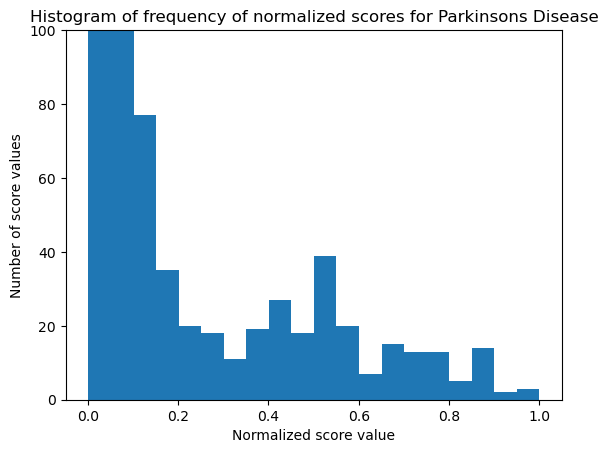

In [141]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.hist(norm_scores, bins=20)

plt.title('Histogram of frequency of normalized scores for Parkinsons Disease')
plt.ylabel('Number of score values')
plt.xlabel('Normalized score value')

plt.ylim(0,100)

From this plot we see that the majority of the norm scores are between ~0 and 0.2. This means that they have very little evidence because maybe the are few sources that have studied this target. 
We see that from 0.4 upwards there are some scores. We can consider that 0.5 in norm data is quite of reliable as  it is the half of the maximum score. 

In [142]:
norm_scores_05 = [i for i in norm_scores if i > 0.5]

print('Number of scores for PD that have a normalized score bigger than 0.5: ', len(norm_scores_05))

Number of scores for PD that have a normalized score bigger than 0.5:  132


In [143]:
scores_05 = []

for score_dicti in score_normscores_dict: # For each normalized value of PD score
    score_dicti_norm = score_normscores_dict[score_dicti] 
    
    if score_dicti_norm in norm_scores_05: # If this value is in the list of scores above 0.5
        scores_05.append(score_dicti) # Append to a list where there will be the interesting ones

In [144]:
len(scores_05)

98

In [145]:
scores_05_unique = list(set(scores_05))

print('Number of unique scores above 0.5 of their normalized value: ', len(scores_05_unique))

Number of unique scores above 0.5 of their normalized value:  98


In [146]:
PD_scorefilter = pd.DataFrame(columns = PD. columns. values) # We create new dataframe to append those targets with
                                                            # a normalized score bigger than 0.5

for i in scores_05_unique: 
    row_to_append = PD[PD['score'] == i]
    PD_scorefilter = pd.concat([PD_scorefilter,row_to_append])

In [147]:
print('Dataframe for Parkinsons Diease targets with a normalized score bigger than 0.5: ')
PD_scorefilter

Dataframe for Parkinsons Diease targets with a normalized score bigger than 0.5: 


,diseaseId,targetId,score,evidenceCount
61,MONDO_0005180,ENSG00000010810,0.367645,11
76,MONDO_0005180,ENSG00000014138,0.369580,1
156,MONDO_0005180,ENSG00000062822,0.369580,1
263,MONDO_0005180,ENSG00000077514,0.369580,1
424,MONDO_0005180,ENSG00000100479,0.369580,1
...,...,...,...,...
1643,MONDO_0005180,ENSG00000152214,0.505624,67
2369,MONDO_0005180,ENSG00000184160,0.555687,10
524,MONDO_0005180,ENSG00000103546,0.561392,24
955,MONDO_0005180,ENSG00000120251,0.358163,13


In [148]:
PD_scorefilter_id_2 = PD_scorefilter['targetId'] # We get the target IDs

In [149]:
len(PD_scorefilter_id_2)

132

In [150]:
#PD_scorefilter_id = PD_scorefilter['targetId'] # We get the target IDs

In [151]:
uniprot_PD = []

for i in PD_scorefilter_id_2: 
    protein_ids = proteincoding_opentarget[proteincoding_opentarget['id'] == i]['proteinIds']
    for j in protein_ids: 
        for m in j:
            if m['source'] =='uniprot_swissprot': # We get the UniProt ID for the specific ENSG ID 
                uniprot = m['id']
                uniprot_PD.append(uniprot)
            if 'uniprot_swissprot' not in str(list(protein_ids)):
                print('These do not have a UniProt ID: ',i)

These do not have a UniProt ID:  ENSG00000263715
These do not have a UniProt ID:  ENSG00000272414
These do not have a UniProt ID:  ENSG00000272414
These do not have a UniProt ID:  ENSG00000272414
These do not have a UniProt ID:  ENSG00000272414
These do not have a UniProt ID:  ENSG00000272414
These do not have a UniProt ID:  ENSG00000272414
These do not have a UniProt ID:  ENSG00000272414


In [152]:
len(uniprot_PD) # Two do not have a uniprot_swissprot source

130

#### C. Intersection between Pharos-OpenTargets Targets and OpenTargets Associations: Druggable with SM activity - Parkinson Diseases

In [153]:
uniprot_druggable_PD = []

for i in Uniprot_SM_pocket_ligand: # We do the intersection between the targetable by druggable by Small Molecule activity 
    if i in uniprot_PD:  # and the targetable for Parkinsons Disease
        uniprot_druggable_PD.append(i) # The common ones, we append it to a list 
        

In [154]:
len(uniprot_druggable_PD)

85

In [155]:
Common_OpenTarget_IntersectionList = []

for i in uniprot_druggable_PD:
    for j in IntersectionList['Entry']: 
        if i ==j: 
            Common_OpenTarget_IntersectionList.append(j)

In [156]:
print('Number of UniProts Druggable by SM and PD :',len(uniprot_druggable_PD))
print('Number of UniProts from the CNS protein list:',len(IntersectionList))
print('Number of UniProts from CNS and Targetable:',len(Common_OpenTarget_IntersectionList))

Number of UniProts Druggable by SM and PD : 85
Number of UniProts from the CNS protein list: 15320
Number of UniProts from CNS and Targetable: 77


#### D. Intersection between druggable with SM activity for PD and CNS protein list

In [157]:
List_OpenTarg_IntersectionCNS_values = IntersectionList['Entry'].isin(Common_OpenTarget_IntersectionList)
List_OpenTarg_IntersectionCNS=IntersectionList[List_OpenTarg_IntersectionCNS_values]
len(List_OpenTarg_IntersectionCNS)

77

In [158]:
List_OpenTarg_IntersectionCNS

,Unnamed: 0.1,Unnamed: 0,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length
151,176,178,9606.ENSP00000176183,P21917,reviewed,DRD4_HUMAN,D(4) dopamine receptor (D(2C) dopamine recepto...,DRD4,Homo sapiens (Human),419
478,551,553,9606.ENSP00000219833,P23975,reviewed,SC6A2_HUMAN,Sodium-dependent noradrenaline transporter (No...,SLC6A2 NAT1 NET1 SLC6A5,Homo sapiens (Human),617
1571,1858,1862,9606.ENSP00000255380,P20309,reviewed,ACM3_HUMAN,Muscarinic acetylcholine receptor M3,CHRM3,Homo sapiens (Human),590
1661,1957,1961,9606.ENSP00000257068,P49286,reviewed,MTR1B_HUMAN,Melatonin receptor type 1B (Mel-1B-R) (Mel1b r...,MTNR1B,Homo sapiens (Human),362
2002,2355,2359,9606.ENSP00000261707,P31645,reviewed,SC6A4_HUMAN,Sodium-dependent serotonin transporter (SERT) ...,SLC6A4 HTT SERT,Homo sapiens (Human),630
...,...,...,...,...,...,...,...,...,...,...
14523,17367,17588,9606.ENSP00000469332,Q9UN88,reviewed,GBRT_HUMAN,Gamma-aminobutyric acid receptor subunit theta...,GABRQ,Homo sapiens (Human),632
14685,17579,17810,9606.ENSP00000477455,Q13224,reviewed,NMDE2_HUMAN,"Glutamate receptor ionotropic, NMDA 2B (GluN2B...",GRIN2B NMDAR2B,Homo sapiens (Human),1484
14833,17761,18006,9606.ENSP00000480012,P29274,reviewed,AA2AR_HUMAN,Adenosine receptor A2a,ADORA2A ADORA2,Homo sapiens (Human),412
14867,17809,18057,9606.ENSP00000480573,P18089,reviewed,ADA2B_HUMAN,Alpha-2B adrenergic receptor (Alpha-2 adrenerg...,ADRA2B ADRA2L1 ADRA2RL1,Homo sapiens (Human),450


##### Save list of CNS proteins that are targetable for SM for PD 

In [159]:
List_OpenTarg_IntersectionCNS.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.1.Opentarget/Drug_SmallMolec/OT_PD_druggable_SM_correct.csv', sep ='\t')

# ___________

#### 2.2. Membrane. Uniprot

##### - Step 1. Import data from UniProt

We import the list from Uniprot including Transmembrane and Intermembrane proteins

In [160]:
path_Uniprot_Membrane = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.2.Membrane_Uniprot/uniprot-compressed_true_download_true_fields_accession_2Creviewed_2C-2023.02.06-12.46.59.48.tsv'

In [161]:
Uniprot_Membrane = pd.read_csv(path_Uniprot_Membrane,delimiter='\t')

In [162]:
path_intersectionlist_optarg='~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.1.Opentarget/Drug_SmallMolec/OT_PD_druggable_SM_correct.csv'

In [163]:
IntersectionListOptarg= pd.read_csv(path_intersectionlist_optarg,delimiter='\t')

##### - Step 2. Intersection between CNS target proteins and membrane proteins

In [164]:
Common_MembIntermemb_IntersectionList = []

for i in Uniprot_Membrane['Entry']: # For each code of Uniprot_Membrane (Uniprot codes with membrane domains)
    for j in IntersectionListOptarg['Entry']: # For each code of IntersectionList (Uniprot code of CNS list)
        if i ==j: # If they are equal
            Common_MembIntermemb_IntersectionList.append(j)

In [165]:
print('Number of UniProts which are Membrane proteins:',len(Uniprot_Membrane))
print('Number of UniProts which are CNS Targetable proteins (with some filters):',len(IntersectionListOptarg))
print('Number of UniProts which are CNS Targetable Membrane proteins:',len(Common_MembIntermemb_IntersectionList))

Number of UniProts which are Membrane proteins: 3963
Number of UniProts which are CNS Targetable proteins (with some filters): 77
Number of UniProts which are CNS Targetable Membrane proteins: 64


In [166]:
# We only select those proteins from the CNS list that are inter/trans membrane

List_Membr_IntersectionCNS_values = IntersectionList['Entry'].isin(Common_MembIntermemb_IntersectionList)
List_Membr_IntersectionCNS=IntersectionList[List_Membr_IntersectionCNS_values]
len(List_Membr_IntersectionCNS)

64

##### - Step 3. Save the list for CNS target membrane proteins

In [167]:
List_Membr_IntersectionCNS.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.2.Membrane_Uniprot/List_CNS_DruggablePD_Mem_Uniprot_correct.csv', sep ='\t')

# ______

#### 2.3. Length sequence > 100 aa. Uniprot

##### - Step 1. Import data

In [168]:
Membrane_CNS_path= '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.2.Membrane_Uniprot/List_CNS_DruggablePD_Mem_Uniprot_correct.csv'


In [169]:
Membrane_CNS=pd.read_csv(Membrane_CNS_path,delimiter='\t')

Membrane_CNS.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length
0,151,176,178,9606.ENSP00000176183,P21917,reviewed,DRD4_HUMAN,D(4) dopamine receptor (D(2C) dopamine recepto...,DRD4,Homo sapiens (Human),419
1,478,551,553,9606.ENSP00000219833,P23975,reviewed,SC6A2_HUMAN,Sodium-dependent noradrenaline transporter (No...,SLC6A2 NAT1 NET1 SLC6A5,Homo sapiens (Human),617
2,1571,1858,1862,9606.ENSP00000255380,P20309,reviewed,ACM3_HUMAN,Muscarinic acetylcholine receptor M3,CHRM3,Homo sapiens (Human),590
3,1661,1957,1961,9606.ENSP00000257068,P49286,reviewed,MTR1B_HUMAN,Melatonin receptor type 1B (Mel-1B-R) (Mel1b r...,MTNR1B,Homo sapiens (Human),362
4,2002,2355,2359,9606.ENSP00000261707,P31645,reviewed,SC6A4_HUMAN,Sodium-dependent serotonin transporter (SERT) ...,SLC6A4 HTT SERT,Homo sapiens (Human),630


In [170]:
print('CNS Targetable Membrane proteins: ',len(Membrane_CNS))


CNS Targetable Membrane proteins:  64


##### - Step 2. Cut-off length aa

In [171]:
# This is a list of the lengths of each protein
Length_aa = Membrane_CNS['Length']

In [172]:
# We get useful information of the Length column in order to set a cut-off
Length_aa.describe()

count      64.000000
mean      777.468750
std       537.180823
min       271.000000
25%       457.500000
50%       497.000000
75%       899.000000
max      2339.000000
Name: Length, dtype: float64

We create a frequency table to know which intervals are more frequent and examine the structure of the protein and see if it has an interesting one (different chains, etc) or a simple one (one helix alpha...) so it is not that much interesting for studying its dynamics.

In [173]:
iw = (Length_aa.max()-Length_aa.min())/200


In [174]:
Abs_frecuency, intervals = np.histogram(Length_aa, bins = 100)


In [175]:
# Create dataframe
freq_table = pd.DataFrame(index = np.linspace(1,100,100), columns = ['start', 'end', 'class_marks','Frec_abs'])
# Assign the intervals
freq_table['start'] = intervals[:-1]
freq_table['end'] = intervals[1:]
# Calculate class marks
freq_table['class_marks'] = (freq_table['start'] + freq_table['end'])/2
# Assing Absolute frecuency
freq_table['Frec_abs'] = Abs_frecuency


In [176]:
freq_table

,start,end,class_marks,Frec_abs
1.0,271.00,291.68,281.34,1
2.0,291.68,312.36,302.02,0
3.0,312.36,333.04,322.70,0
4.0,333.04,353.72,343.38,1
5.0,353.72,374.40,364.06,2
...,...,...,...,...
96.0,2235.60,2256.28,2245.94,0
97.0,2256.28,2276.96,2266.62,0
98.0,2276.96,2297.64,2287.30,0
99.0,2297.64,2318.32,2307.98,0


# ____

#### 2.4. With PDB structure 
 When we have already done filter of length aa of the membrane-intersection cns

##### - Step 1. Filter those proteins that have PDB structure

In [177]:
# We import the list of the filtered length of the aminoacids. 

filter_length = pd.read_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.2.Membrane_Uniprot/List_CNS_DruggablePD_Mem_Uniprot_correct.csv',delimiter='\t')


In [178]:
# We select the Uniprot codes ('Entry')
Uniprot_codes = filter_length['Entry'].to_list()

In [179]:
# We load the document proportionated by lab of P.Aloy
uniprot = pd.read_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Angelo_Alloy_Proteins/uniprot_pdb.tsv',delimiter='\t')

In [180]:
# We do a table of those Uniprot_codes that are found in the SP_PRIMARY column of the file uniprot_pdb
table_PDBs_CNS = uniprot[uniprot['SP_PRIMARY'].isin(Uniprot_codes)]

In [181]:
# We create the columns of the table
table_PDBs_CNS.columns=['Uniprot','PDB']

In [182]:
# We add the values
table_PDBs_CNS['gene_name']=[filter_length[filter_length['Entry']==x]['Gene Names'].to_list()[0] for x in table_PDBs_CNS['Uniprot'].to_list()]

/tmp/ipykernel_18403/1000095070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_PDBs_CNS['gene_name']=[filter_length[filter_length['Entry']==x]['Gene Names'].to_list()[0] for x in table_PDBs_CNS['Uniprot'].to_list()]


In [183]:
# This is the final table where we have all the PDBs codes for each Uniprot belonging to CNS, membrane and length > 100 aa
table_PDBs_CNS

,Uniprot,PDB,gene_name
15784,O14764,7qn7;7qn8;7qn6;7qn5;7qn9;7qnc;7qnd,GABRD
20909,P07550,2r4r;7bz2;6prz;6ps6;4gbr;3nya;5d6l;5x7d;2r4s;6...,ADRB2 ADRB2R B2AR
21077,P08172,4mqt;6oik;5zk3;4mqs;5yc8;5zk8;5zkb;3uon;5zkc;6u1n,CHRM2
21182,P08588,7bu7;7bu6;7bvq;7bts;2lsq,ADRB1 ADRB1R B1AR
21250,P08908,7e2x;7e2y;7e2z,HTR1A ADRB2RL1 ADRBRL1
21253,P08913,1hod;7ejk;6kuy;6kux;7ej0;1hof;1ho9;6k42;7ej8;1...,ADRA2A ADRA2R ADRAR
23157,P11229,6wjc;6zg4;5cxv;6zfz;6zg9;6oij,CHRM1
23780,P14416,6luq;7dfp;7jvr;6cm4;6vms;5aer,DRD2
23861,P14867,6x3u;7pbd;6x3x;6x3t;6d6t;7pc0;6x3s;6d1s;7pbz;7...,GABRA1
24370,P17787,2ksr;6usf;5kxi;2lm2;6cnj;2k58;2k59;6ur8;6cnk,CHRNB2


In [184]:
print('We have: ',len(filter_length),' CNS Targetable Membrane proteins\nWe have: ',len(table_PDBs_CNS),' proteins with PDB structure')

We have:  64  CNS Targetable Membrane proteins
We have:  45  proteins with PDB structure


In [185]:
#print('We have: ',len(filter_length),' CNS Targetable Membrane proteins\nWe have: ',len(table_PDBs_CNS),' proteins with PDB structure')

In [186]:
# We now extract all the PDBs codes that we have: 

PDBs_CNS_possibleduplicates = [] # There may be some duplicates.
table_PDB = list(table_PDBs_CNS['PDB']) 

for i in table_PDB: 
    if ';' in i: 
        for item in i.split(";"):# We split those values that are in the same row.
            PDBs_CNS_possibleduplicates.append(item)      
    else: 
        PDBs_CNS_possibleduplicates.append(i) #If there are not values in the same row, then we append it as it is.

In [187]:
# We now get rid of the duplicates

PDBs_CNS = []

for item in PDBs_CNS_possibleduplicates:
    if item not in PDBs_CNS:
        PDBs_CNS.append(item)

In [188]:
print('Number of PDBs that are from the CNS, Targets, Membrane,length>100, possible dupli:  ',len(PDBs_CNS_possibleduplicates),'PDBs')
print('Number of PDBs that are from the CNS, Targets, Membrane:  ',len(PDBs_CNS),'PDBs')

Number of PDBs that are from the CNS, Targets, Membrane,length>100, possible dupli:   527 PDBs
Number of PDBs that are from the CNS, Targets, Membrane:   449 PDBs


In [189]:
#print('Number of PDBs that are from the CNS, membrane and with a length >100, possible dupli:  ',len(PDBs_CNS_possibleduplicates),'PDBs')
#print('Number of PDBs that are from the CNS, membrane and with a length >100:  ',len(PDBs_CNS),'PDBs')

In [157]:
# Length of the table
#print('Total number of proteins from CNS, membrane, length>100, with PDB structure_possidupli:',len(table_PDBs_CNS), 'proteins')
#print('Number of PDBs that are from the CNS, membrane and with a length >100, possible dupli:  ',len(PDBs_CNS_possibleduplicates),'PDBs')
#print('Total number of PDBs, without dupli: ', len(PDBs_CNS), 'PDBs')

Total number of proteins from CNS, membrane, length>100, with PDB structure_possidupli: 38 proteins
Number of PDBs that are from the CNS, membrane and with a length >100, possible dupli:   446 PDBs
Total number of PDBs, without dupli:  377 PDBs


In [190]:
# Length of the table
print('Total number of proteins from CNS, Targets, Membrane, length>100, PDB structure, possidupli:',len(table_PDBs_CNS), 'proteins')
print('Number of PDBs that are from the CNS, Targets, Membrane, length>100, possible dupli:  ',len(PDBs_CNS_possibleduplicates),'PDBs')
print('Total number of PDBs from CNS, Targets, Membrane, >100 aa proteins, without dupli: ', len(PDBs_CNS), 'PDBs')

Total number of proteins from CNS, Targets, Membrane, length>100, PDB structure, possidupli: 45 proteins
Number of PDBs that are from the CNS, Targets, Membrane, length>100, possible dupli:   527 PDBs
Total number of PDBs from CNS, Targets, Membrane, >100 aa proteins, without dupli:  449 PDBs


In [ ]:
#table_PDBs_CNS.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.4.PDB/List_CNS_DruggablePD_Mem_100aa_PDB_Uniprot.csv')


In [191]:
table_PDBs_CNS.to_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.4.PDB/List_CNS_DruggablePD_Mem_100aa_PDB_Uniprot_correct.csv')


#### 2.4.1. Information about PDB structure

##### Split PDBs and make a table of keys: Uniprot and PDB

In [192]:
table_PDBs_CNS

,Uniprot,PDB,gene_name
15784,O14764,7qn7;7qn8;7qn6;7qn5;7qn9;7qnc;7qnd,GABRD
20909,P07550,2r4r;7bz2;6prz;6ps6;4gbr;3nya;5d6l;5x7d;2r4s;6...,ADRB2 ADRB2R B2AR
21077,P08172,4mqt;6oik;5zk3;4mqs;5yc8;5zk8;5zkb;3uon;5zkc;6u1n,CHRM2
21182,P08588,7bu7;7bu6;7bvq;7bts;2lsq,ADRB1 ADRB1R B1AR
21250,P08908,7e2x;7e2y;7e2z,HTR1A ADRB2RL1 ADRBRL1
21253,P08913,1hod;7ejk;6kuy;6kux;7ej0;1hof;1ho9;6k42;7ej8;1...,ADRA2A ADRA2R ADRAR
23157,P11229,6wjc;6zg4;5cxv;6zfz;6zg9;6oij,CHRM1
23780,P14416,6luq;7dfp;7jvr;6cm4;6vms;5aer,DRD2
23861,P14867,6x3u;7pbd;6x3x;6x3t;6d6t;7pc0;6x3s;6d1s;7pbz;7...,GABRA1
24370,P17787,2ksr;6usf;5kxi;2lm2;6cnj;2k58;2k59;6ur8;6cnk,CHRNB2


In [193]:
Uniprot_id_dict = [] # We create a list of the multiple Uniprot for each PDB that exists

for PDB_id in list(table_PDBs_CNS['PDB']): # For each PDB (can be multiple PDBs)
    count_char = PDB_id.count(';')+1 # We count how many PDBs are in that string, the codes are split with ;
    
    idx = table_PDBs_CNS[table_PDBs_CNS['PDB'] == PDB_id].index.tolist() # We calculate the index of that PDB
    
    if PDB_id ==  list(table_PDBs_CNS.loc[idx[0]])[1]: # If the PDB string is equal to the value of PDBs in the row of the index
        Unid_multiple = (table_PDBs_CNS.loc[idx[0]][0],)*count_char # Then we multiply the id of Uniprot the number of times of PDB codes in that string
        Uniprot_id_dict.append(Unid_multiple) # We save the value in the list

In [194]:
Uniprot_id_dict_nottuple = []

for Uniprot_id_dict_tuple in Uniprot_id_dict: 
    for Uniprot_id_indi in Uniprot_id_dict_tuple: 
        Uniprot_id_dict_nottuple.append(Uniprot_id_indi)
    

In [195]:
genename_dict = [] # We create a list of the multiple genename for each PDB that exists

for PDB_id in list(table_PDBs_CNS['PDB']): # For each PDB (can be multiple PDBs)
    count_char = PDB_id.count(';')+1 # We count how many PDBs are in that string, the codes are split with ;
    
    idx = table_PDBs_CNS[table_PDBs_CNS['PDB'] == PDB_id].index.tolist() # We calculate the index of that PDB
    
    if PDB_id ==  list(table_PDBs_CNS.loc[idx[0]])[1]: # If the PDB string is equal to the value of PDBs in the row of the index
        genename_multiple = (table_PDBs_CNS.loc[idx[0]][2],)*count_char # Then we multiply the id of genename the number of times of PDB codes in that string
        genename_dict.append(genename_multiple) # We save the value in the list
        

In [196]:
genename_dict_nottuple = []

for genename_dict_tuple in genename_dict: 
    for genename_indi in genename_dict_tuple: 
        genename_dict_nottuple.append(genename_indi)
    

In [197]:
len(Uniprot_id_dict_nottuple),len(PDBs_CNS_possibleduplicates),len(genename_dict_nottuple)

(527, 527, 527)

In [198]:
d = {'Uniprot':Uniprot_id_dict_nottuple,'PDB':PDBs_CNS_possibleduplicates,'gene_name':genename_dict_nottuple}
table_PDBs = pd.DataFrame.from_dict(d)

In [199]:
table_PDBs

,Uniprot,PDB,gene_name
0,O14764,7qn7,GABRD
1,O14764,7qn8,GABRD
2,O14764,7qn6,GABRD
3,O14764,7qn5,GABRD
4,O14764,7qn9,GABRD
...,...,...,...
522,Q99250,4jpz,SCN2A NAC2 SCN2A1 SCN2A2
523,Q99250,4rly,SCN2A NAC2 SCN2A1 SCN2A2
524,Q99250,6j8e,SCN2A NAC2 SCN2A1 SCN2A2
525,Q9NY46,7w77,SCN3A KIAA1356 NAC3


In [200]:
len(table_PDBs['PDB'].unique())

449

##### API to get more info

To get the information about the **experimental method** of each PDB. 

In [201]:
import json
import urllib.request
from typing import List

# Given a pdb Id, get its Experimental Obtaining Method

def pdb_info_exp (pdb_id : str) -> List[str]:
    # Request the MMB service to retrieve pdb data
    request_url = 'https://mmb.irbbarcelona.org/api/pdb/' + pdb_id + '/entry'
    try:
        with urllib.request.urlopen(request_url) as response:
            parsed_response = json.loads(response.read().decode("utf-8"))
    # If the accession is not found in the PDB then we can stop here
    except urllib.error.HTTPError as error:
        if error.code == 404:
            return None
        else:
            raise ValueError('Something went wrong with the PDB request: ' + request_url)
    # Get the uniprot accessions
    pdb_expType = parsed_response['expType'] # We get the Experimental Method
    
    return pdb_expType

To get the information about the **experimental resolution** of each PDB. 

In [202]:
import json
import urllib.request
from typing import List

# Given a pdb Id, get its method resolution

def pdb_info_resol (pdb_id : str) -> List[str]:
    # Request the MMB service to retrieve pdb data
    request_url = 'https://mmb.irbbarcelona.org/api/pdb/' + pdb_id + '/entry'
    try:
        with urllib.request.urlopen(request_url) as response:
            parsed_response = json.loads(response.read().decode("utf-8"))
    # If the accession is not found in the PDB then we can stop here
    except urllib.error.HTTPError as error:
        if error.code == 404:
            return None
        else:
            raise ValueError('Something went wrong with the PDB request: ' + request_url)
    # Get the uniprot accessions
    pdb_resol= parsed_response['resol'] # We get the resolution 
    return pdb_resol

To get the information about the **information about chains: type, sequence, fragments** of each PDB. 

In [203]:
import json
import urllib.request
from typing import List

# Given a pdb Id, gets information of each of its chains. 

def pdb_info_chains (pdb_id : str) -> List[str]:
    # Request the MMB service to retrieve pdb data
    request_url = 'https://mmb.irbbarcelona.org/api/pdb/' + pdb_id + '/entry'
    try:
        with urllib.request.urlopen(request_url) as response:
            parsed_response = json.loads(response.read().decode("utf-8"))
    # If the accession is not found in the PDB then we can stop here
    except urllib.error.HTTPError as error:
        if error.code == 404:
            return None
        else:
            raise ValueError('Something went wrong with the PDB request: ' + request_url)
    
    # Get the uniprot accessions
    if parsed_response['chainIds'] != None: # If there are ChainIds: 
        
        chains = [ chain[-1] for chain in parsed_response['chainIds'] ] 
        # We only stay with the last letter of the chain because it indicates the chain type
        

        id_chains = [ chain['_id'] for chain in parsed_response['chains'] ]
        # We get all the id of the chain 
        
        sequence_uniprot = [ chain['sequence'] for chain in parsed_response['chains']]
        # We get the sequence of Uniprot of each chaine if each PDB has different chains. 
        
        
        # To get the fragments we do not do a compressed loop: 
        fragments_all = [] # We create a list to put all the fragments of all chains here
        
        
        for chain in parsed_response['chains']: # We get the fragments of each chain
            if chain['PDBSequence'] != None: # as long as the PDBSequence exists because if not, we would not have fragments
                fragments = chain['PDBSequence']['fragments'] 
                fragments_all.append(fragments)

                
                
        # We want a dictionary with: being the key the chain type ['A'], and the values all the information of
        #this chain for this PDB ex. sequence['AGJEROW'], fragments ['1-22, 133-159']. 
        lista_dicti = []
        
        
        for idx in (range(len(chains))):
            if chain['PDBSequence'] != None: # as long as it exists a PDBSequence
                print(id_chains[idx])
                dicti = {chains[idx]:[sequence_uniprot[idx],fragments_all[idx]]}
                lista_dicti.append(dicti)

        return lista_dicti
    
    else:
        return None


To get the information about the **Chain ID (type)** of each PDB. 

In [204]:
import json
import urllib.request
from typing import List

# Given a pdb Id, get its identifiers chains: 

def pdb_chains (pdb_id : str) -> List[str]:
    # Request the MMB service to retrieve pdb data
    request_url = 'https://mmb.irbbarcelona.org/api/pdb/' + pdb_id + '/entry'
    try:
        with urllib.request.urlopen(request_url) as response:
            parsed_response = json.loads(response.read().decode("utf-8"))
    # If the accession is not found in the PDB then we can stop here
    except urllib.error.HTTPError as error:
        if error.code == 404:
            return None
        else:
            raise ValueError('Something went wrong with the PDB request: ' + request_url)
    
    # Get the uniprot accessions
    if parsed_response['chainIds'] != None: 
        
        chains = [ chain[-1] for chain in parsed_response['chainIds'] ]
        #Here we only get the last letter of the chain id because faster than mining the previous dictionary. 

        return chains
    
    else:
        return None


We run each function. 

In [205]:
pdb_info_exp_list = []

for PDB_id in table_PDBs['PDB']: 
    if PDB_id not in pdb_info_exp_list:
        pdb_info_api = pdb_info_exp(PDB_id)
        print(pdb_info_api)
        pdb_info_exp_list.append(pdb_info_api)

ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
SOLUTION NMR
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
ELECTRON 

ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
ELECTRON MICROSCOPY
X-RAY DIFFRACTION
SOLUTION NMR
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTION
X-RAY DIFFRACTI

In [206]:
pdb_info_resol_list = []

for PDB_id in table_PDBs['PDB']:
    if PDB_id not in pdb_info_resol_list:
        pdb_info_resol_api = pdb_info_resol(PDB_id)
        print(pdb_info_resol_api)
        pdb_info_resol_list.append(pdb_info_resol_api)

N.A.
N.A.
N.A.
N.A.
N.A.
N.A.
N.A.
3.4
N.A.
2.8
2.7
3.99
3.16
3.2
2.7
3.4
2.6
3.7
3.1
2.9
3.2
2.4
3.3
3.2
2.96
2.84
3.4
3.8
3.5
2.79
3.5
N.A.
N.A.
2.5
3.1
3.2
N.A.
2.48
2.84
2.8
2.4
3.2
3.2
3.8
3.4
3.7
3.6
2.6
3.5
2.5
3
2.95
3
2.3
N.A.
2.6
2.7
2.5
3.13
N.A.
3
3
N.A.
N.A.
3.4
3.2
2.7
N.A.
N.A.
N.A.
4.1
3
N.A.
3.6
2.55
2.33
2.7
2.17
2.5
3.3
3.1
3.1
2.8
2.87
3.8
2.19
3.49
3.04
2.92
2.55
3.8
3
3.12
3.2
2.79
N.A.
3.45
3.3
N.A.
N.A.
2.86
N.A.
3.58
3.8
3.23
N.A.
3.87
3.94
N.A.
3.4
N.A.
N.A.
3.71
3.7
4.1
2.9
3.49
3.8
N.A.
3.69
2.92
3.3
N.A.
N.A.
3.12
3.8
3.1
N.A.
2.86
2.55
3.04
3.26
3.58
3.23
2.8
N.A.
N.A.
3
3.8
3
N.A.
N.A.
N.A.
N.A.
N.A.
N.A.
N.A.
N.A.
N.A.
3
2.9
N.A.
3.2
N.A.
N.A.
2.14
1.96
1.8
1.35
1.9
1.3
2.3
1.45
1.34
2.4
1.98
2.8
2.22
1.5
1.6
1.9
2.2
2.3
2.2
1.83
2.2
2.3
2.3
1.7
2
2.4
2.3
3.1
1.7
1.8
1.8
2.2
2.2
2.5
1.7
2.3
1.6
2.42
1.8
2.1
2.07
1.6
2.12
1.65
1.7
1.8
1.9
2.2
2
1.89
1.7
1.7
1.7
2.06
1.7
1.66
1.8
2.3
2.1
2.3
3
1.6
2.4
2.1
1.7
3.4
N.A.
2.6
N.A.
2.6
3.2
3.2
3
2.5
2.45
2.9
2.

In [207]:
pdb_info_chains_list = []

for PDB_id in table_PDBs['PDB']: 
    pdb_info_chain_api = pdb_info_chains(PDB_id)
    print(pdb_info_chain_api)
    pdb_info_chains_list.append(pdb_info_chain_api)

None
None
None
None
None
None
None
2R4R_A
2R4R_L
2R4R_H
[{'A': ['MGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIETLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYANETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLQKIDKSEGRFHVQNLSQVEQDGRTGHGLRRSSKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSG', ['37-59', '61-90', '108-164', '203-242', '264-291', '311-348']]}, {'L': ['DIKMTQSPSSMYASLGERVTITCKASQDINSYLSWFQQKPGKSPKTLIYRANRLVDGVPSRFIGTGSGQDYSLTISSLDYADMGIYYCLQYDEFPYTFGGGTKLEIKRADAAPTVSIFPPSSEQLTSGGASVVCFLNNFYPKDINVKWKIDGSERQNGVLNSWTDQDSKDSTYSMSSTLTLTKDEYERHNSYTCEATHKTSTSPIVKSFNRNEC', ['1-214']]}, {'H': ['EVQLQQSGAELARPGASVKLSCKASGYIFTDYYINWVRQRTGQGFEWIGEIYPGSGNIDYNERFKDKATLTADKSSSTAYMQLSSLTSEDSAVYFCVRGFGYWGQGTTLTVSSAKTTPPSVYPLAPGSAAQTNSAVTLGCLVKGYFPEPVTVTWNSGSLSSGVHTFPAVLQSDLYTLSSSVTVPSSTWPSETVTCNVAHPASSTKVDKKIVPRDCGC', ['1-217']]}]
7BZ2_A
7BZ2_B
7BZ2_G
7

6PS5_A
[{'A': ['MKTIIALSYIFCLVFADYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIWTLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYAEETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKHHHHHH', ['29-230', '1002-342']]}]
3SN6_A
3SN6_B
3SN6_G
3SN6_R
3SN6_N
[{'A': ['MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLLGAGESGKSTIVKQMRILHVNGFNGDSEKATKVQDIKNNLKEAIETIVAAMSNLVPPVELANPENQFRVDYILSVMNVPDFDFPPEFYEHAKALWEDEGVRACYERSNEYQLIDCAQYFLDKIDVIKQDDYVPSDQDLLRCRVLTSGIFETKFQVDKVNFHMFDVGGQRDERRKWIQCFNDVTAIIFVVASSSYNMVIREDNQTNRLQEALNLFKSIWNNRWLRTISVILFLNKQDLLAEKVLAGKSKIEDYFPEFARYTTPEDATPEPGEDPRVTRAKYFIRDEFLRISTASGDGRHYCYPHFTCAVDTENIRRVFNDCRDIIQRMHLRQYELL', ['9-59', '88-202', '20

6KR8_A
[{'A': ['GTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAICKFERLQTVTNYFITSLAVADLVMGLAVVPFGAAHILTKTWTFGNFWCEFWTSIDVLCVTASIWTLCVIAVDRYFAICSPFKYQSLLTKCKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYAEETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLQKIDKSEGRFHVQNVSQVEQDGRTGHGHRRSSKFACKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYSRSPDFRCAFQELLAARRSSVKAHHHHHHHHHH', ['30-341']]}]
7DHI_A
7DHI_B
7DHI_G
7DHI_N
7DHI_R
[{'A': ['SMGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLLGAGESGKSTIVKQMRILHVNGFNGEGGEEDPQAARSNSDGEKATKVQDIKNNLKEAIETIVAAMSNLVPPVELANPENQFRVDYILSVMNVPDFDFPPEFYEHAKALWEDEGVRACYERSNEYQLIDCAQYFLDKIDVIKQADYVPSDQDLLRCRVLTSGIFETKFQVDKVNFHMFDVGGQRDERRKWIQCFNDVTAIIFVVASSSYNMVIREDNQTNRLQEALNLFKSIWNNRWLRTISVILFLNKQDLLAEKVLAGKSKIEDYFPEFARYTTPEDATPEPGEDPRVTRAKYFIRDEFLRISTASGDGRHYCYPHFTCAVDTENIRRVFNDCRDIIQRMHLRQYELL', ['12-57', '208-251', '262-303', '308-326', '330-394']]}, {'B': ['MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRTRRTLRGHLAKIYAMHWGTDSRLLVSASQDGKLIIWDSYTTNKVHAIPLRSSWVMTCAYAPSGNYVACGGLDNICSIY

5D5B_A
[{'A': ['DYKDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIETLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYAEETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSG', ['29-230', '263-342']]}]
3KJ6_A
3KJ6_L
3KJ6_H
[{'A': ['GFGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIETLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYAEETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLQKIDKSEGRFHVQNLSQVEQDGRTGHGLRRSSKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSG', ['35-59', '61-91', '108-164', '203-242', '263-291', '307-

7BU6_A
7BU6_B
[{'A': ['DYKDDDDANIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYAASQQWTAGMGLLMALIVLLIVAGNVLVIVAIAKTPRLQTLTNLFIMSLASADLVMGLLVVPFGATIVVWGRWEYGSFFCELWTSVDVLCVTASIETLCVIALDRYLAITSPFRYQSLLTRARARGLVCTVWAISALVSFLPILMHWWRAESDEARRCYNDPKCCDFVTNRAYAIASSVVSFYVPLCIMAFVYLRVFREAQKQVKKIDSCERRFLGGPARPPSPSPSPVPAPAPPPGPPRPAAAAATAPLANGRAGKRRPSRLVALREQKALKTLGIIMGVFTLCWLPFFLANVVKAFHRELVPDRLFVFFNWLGYANSAFNPIIYCRSPDFRKAFQGLLCCARRAAR', ['884-1255', '1316-1392']]}, {'B': ['QVQLQESGGGLVQAGGSLRLSCAASGSIFALNIMGWYRQAPGKQRELVAAIHSGGTTNYANSVKGRFTISRDNAANTVYLQMNSLKPEDTAVYYCNVKDFGAIIYDYDYWGQGTQVTVSSLEHHHHHH', ['1-120']]}]
7BVQ_A
7BVQ_B
[{'A': ['DYKDDDDANIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYAASQQWTAGMGLLMALIVLLIVAGNVLVIVAIAKTPRLQTLTNLFIMSLASADLVMGLLVVPFGATIVVWGRWEYGSFFCELWTSV

1HLL_A
[{'A': ['TSSIVHLCAISLDRYWSITQAIEYNLKRTPRR', ['1-32']]}]
None
6WJC_A
6WJC_C
[{'A': ['DYKDDDDAAAQTSAPPAVSPQITVLAPGKGPWQVAFIGITTGLLSLATVTGNLLVLISFKVNTELKTVNNYFLLSLACADLIIGTFSMNLYTTYLLMGHWALGTLACDLWLALDYVASQARVMNLLLISFDRYFSVTRPLSYRAKRTPRRAALMIGLAWLVSFVLWAPAILFWQYLVGERTVLAGQCYIQFLSQPIITFGTAMAAFYLPVTVMCTLYWRIYRETENRNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYFSLVKEKKAARTLSAILLAFILTWTPYNIMVLVSTFCKDCVPETLWELGYWLCYVNSTINPMCYALCNKAFRDTFRLLLLCRWDKRRWRKIPKRPGSVHRTPSRQCHHHHHH', ['17-218', '1001-437']]}, {'C': ['GPGSLTCVKSNSIWFPTSEDCPDGQNLCFKRWQYISPRMYDFTRGCAATCPKAEYRDVINCCGTDKCNK', ['-3-65']]}]
[]
5CXV_A
5CXV_C
[{'A': ['MKTIIALSYIFCLVFADYKDDDDAAAQTSAPPAVSPQITVLAPGKGPWQVAFIGITTGLLSLATVTGNLLVLISFKVNTELKTVNNYFLLSLACADLIIGTFSMNLYTTYLLMGHWALGTLACDLWLALDYVASQASVMNLLLISFDRYFSVTRPLSYRAKRTPRRAALMIGLAWLVSFVLWAPAILFWQYLVGERTVLAGQCYIQFLSQPIITFGTAMAAFYLPVTVMCTLYWRIYRETENRNIFEMLRIDEGLRLKIYKD

6X3U_A
6X3U_C
6X3U_B
6X3U_D
6X3U_E
6X3U_I
6X3U_L
6X3U_J
6X3U_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHA

6D6T_A
6D6T_C
6D6T_B
6D6T_D
6D6T_E
6D6T_I
6D6T_L
6D6T_J
6D6T_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVN', ['8-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVN', ['8-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTV

None
6CDU_A
6CDU_B
6CDU_C
6CDU_D
6CDU_E
6CDU_F
6CDU_G
6CDU_H
6CDU_I
6CDU_J
[{'A': ['APADNAADARPVDVSVSIFINKIYGVNTLEQTYKVDGYIVAQWTGKPRKTPGDKPLIVENTQIERWINNGLWVPALEFINVVGSPDTGNKRLMLFPDGRVIYNARFLGSFSNDMDFRLFPFDRQQFVLELEPFSYNNQQLRFSDIQVYTENIDNEEIDEWWIRGKASTHISDIRYDHLSSVQPNQNEFSRITVRIDAVRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGVESVSKIDRLSRIAFPLLFGIFNLVYWATYLN', ['10-199', '222-316', '388-416']]}, {'B': ['APADNAADARPVDVSVSIFINKIYGVNTLEQTYKVDGYIVAQWTGKPRKTPGDKPLIVENTQIERWINNGLWVPALEFINVVGSPDTGNKRLMLFPDGRVIYNARFLGSFSNDMDFRLFPFDRQQFVLELEPFSYNNQQLRFSDIQVYTENIDNEEIDEWWIRGKASTHISDIRYDHLSSVQPNQNEFSRITVRIDAVRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGVESVSKIDRLSRIAFPLLFGIFNLVYWATYLN', ['10-199', '222-316', '388-416']]}, {'C': ['APADNAADARPVDVSVSIFINKIYGVNTLEQTYKVDGYIVAQWTGKPRKTPGDKPLIVENTQIERWINNGLWVPALEFINVVGSPDTGNKRLMLFPDGRVIYNARFLGSFSNDMDFRLFPFDRQQFVLELEPFSYNNQQLRFSDIQVYTENIDNEEIDEWWIRGKASTHISDIR

None
6X40_A
6X40_C
6X40_B
6X40_D
6X40_E
6X40_I
6X40_L
6X40_J
6X40_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFP

6X3Z_A
6X3Z_C
6X3Z_B
6X3Z_D
6X3Z_E
6X3Z_I
6X3Z_L
6X3Z_J
6X3Z_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHA

2LM2_A
[{'A': ['SNAEEEPLFYTINLIIPCVLITSLAILVFYLPSDCGEKMTLCISVLLALTVFLLLISKIVPPTSSDSPSVGEYLMFTMVLVTFSIVTSVCVLNVHHRSPETHTGGGGGIDRLFLWIFVFVCVFGTIGMFLQPLFQEE', ['2-137']]}]
6CNJ_A
6CNJ_D
6CNJ_B
6CNJ_C
6CNJ_E
6CNJ_F
6CNJ_H
6CNJ_J
6CNJ_G
6CNJ_I
6CNJ_K
[{'A': ['SSHVETRAHAEERLLKKLFSGYNKWSRPVANISDVVLVRFGLSIAQLIDVDEKNQMMTTNVWVKQEWHDYKLRWDPADYENVTSIRIPSELIWRPDIVLYNNADGDFAVTHLTKAHLFHDGRVQWTPPAIYKSSCSIDVTFFPFDQQNCTMKFGSWTYDKAKIDLVNMHSRVDQLDFWESGEWVIVDAVGTYNTRKYECCAEIYPDITYAFVIRRLPLFYTINLIIPCLLISCLTVLVFYLPSECGEKITLCISVLLSLTVFLLLITEIIPSTSLVIPLIGEYLLFTMIFVTLSIVITVFVLNVHHRSPRTHTMPTWVRRVFLDIVPRLLLMKRPSVVDTDFERSVKEDWKYVAMVIDRIFLWMFIIVCLLGTVGLFLPPWLAGMI', ['5-334', '342-381']]}, {'D': ['SSHVETRAHAEERLLKKLFSGYNKWSRPVANISDVVLVRFGLSIAQLIDVDEKNQMMTTNVWVKQEWHDYKLRWDPADYENVTSIRIPSELIWRPDIVLYNNADGDFAVTHLTKAHLFHDGRVQWTPPAIYKSSCSIDVTFFPFDQQNCTMKFGSWTYDKAKIDLVNMHSRVDQLDFWESGEWVIVDAVGTYNTRKYECCAEIYPDITYAFVIRRLPLFYTINLIIPCLLISCLTVLVFYLPSECGEKITLCISVLLSLTVFLLLITEIIPSTSLVIPLIGEYLLFTMIFVTLSIVITVFVLNVHHRSPRTHTMPTWVRRVFLD

6X3U_A
6X3U_C
6X3U_B
6X3U_D
6X3U_E
6X3U_I
6X3U_L
6X3U_J
6X3U_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHA

6HUK_A
6HUK_D
6HUK_B
6HUK_E
6HUK_C
6HUK_G
[{'A': ['MKKSPGLSDYLWAWTLFLSTLTGRSYGDYKDDDDKQPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTVDSGIVQSSTGEYVVMTTHFHLKRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGYAWDGKSVVPEKPKKVKDPLIKKNNTYAPTATSYTPNLARGDPGLATIAKSATIEPKEVKPETKPPEPKKTFNSVSKIDRLSRIAFPLLFGIFNLVYWATYLNREPQLKAPTPHQ', ['10-321', '384-418']]}, {'D': ['MKKSPGLSDYLWAWTLFLSTLTGRSYGDYKDDDDKQPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTVDSGIVQSSTGEYVVMTTHFHLKRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGYAWDGKSVVPEKPKKVKDPLIKKNNTYAPTATSYTPNLARGDPGLATIAKSATIEPKEVKPETKPPEPKKTFNSVSKIDRLSRIAFPLLFGIFNLVYWAT

None
6X3S_A
6X3S_C
6X3S_B
6X3S_D
6X3S_E
6X3S_I
6X3S_L
6X3S_J
6X3S_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFP

6X3T_A
6X3T_C
6X3T_B
6X3T_D
6X3T_E
6X3T_I
6X3T_L
6X3T_J
6X3T_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHA

6HUP_A
6HUP_D
6HUP_B
6HUP_E
6HUP_C
6HUP_G
[{'A': ['MKKSPGLSDYLWAWTLFLSTLTGRSYGDYKDDDDKQPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTVDSGIVQSSTGEYVVMTTHFHLKRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGYAWDGKSVVPEKPKKVKDPLIKKNNTYAPTATSYTPNLARGDPGLATIAKSATIEPKEVKPETKPPEPKKTFNSVSKIDRLSRIAFPLLFGIFNLVYWATYLNREPQLKAPTPHQ', ['13-321', '384-418']]}, {'D': ['MKKSPGLSDYLWAWTLFLSTLTGRSYGDYKDDDDKQPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTVDSGIVQSSTGEYVVMTTHFHLKRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGYAWDGKSVVPEKPKKVKDPLIKKNNTYAPTATSYTPNLARGDPGLATIAKSATIEPKEVKPETKPPEPKKTFNSVSKIDRLSRIAFPLLFGIFNLVYWAT

None
None
7CKY_A
7CKY_B
7CKY_G
7CKY_N
7CKY_R
[{'A': ['MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLLGAGESGKSTIVKQMRILHVNGFNGEGGEEDPQAARSNSDGEKATKVQDIKNNLKEAIETIVAAMSNLVPPVELANPENQFRVDYILSVMNVPDFDFPPEFYEHAKALWEDEGVRACYERSNEYQLIDCAQYFLDKIDVIKQADYVPSDQDLLRCRVLTTGIFETKFQVDKVNFHMFDVGAQRDERRKWIQCFNDVTAIIFVVASSSYNMVIREDNQTNRLQEALNLFKSIWNNRWLRTISVILFLNKQDLLAEKVLAGKSKIEDYFPEFARYTTPEDATPEPGEDPRVTRAKYFIRDEFLRISTASGDGRHYCYPHFTCSVDTENIRRVFNDCRDIIQRMHLRQYELL', ['11-63', '205-255', '263-394']]}, {'B': ['MHHHHGSSGSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRTRRTLRGHLAKIYAMHWGTDSRLLVSASQDGKLIIWDSYTTNKVHAIPLRSSWVMTCAYAPSGNYVACGGLDNICSIYNLKTREGNVRVSRELAGHTGYLSCCRFLDDNQIVTSSGDTTCALWDIETGQQTTTFTGHTGDVMSLSLAPDTRLFVSGACDASAKLWDVREGMCRQTFTGHESDINAICFFPNGNAFATGSDDATCRLFDLRADQELMTYSHDNIICGITSVSFSKSGRLLLAGYDDFNCNVWDALKADRAGVLAGHDNRVSCLGVTDDGMAVATGSWDSFLKIWN', ['1-340']]}, {'G': ['MASNNTASIAQARKLVEQLKMEANIDRIKVSKAAADLMAYCEAHAKEDPLLTPVPASENPFREKKFFCAIL', ['5-62']]}, {'N': ['MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSL

5WIU_A
[{'A': ['GGTTMGNRSTADADGLLAGRGPAAGASAGASAGLAGQGAAALVGGVLLIGAVLAGNSLVCVSVATERALQTPTNSFIVSLAAADLLLALLVLPLFVYSEVQGGAWLLSPRLCDALMAMDVMLCTASIFNLCAISVDRFVAVAVPLRYNRQGGSRRQLLLIGATWLLSAAVAAPVLCGLNDVRGRDPAVCRLEDRDYVVYSSVCSFFLPCPLMLLLYWATFRGLQRWEVARRADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAQKATPPKLEDKSPDSPEMKDFRHGFDILVGQIDDALKLANEGKVKEAQAAAEQLKTTRNAYIQKYLAKITGRERKAMRVLPVVVGAFLLCWTPFFVVHITQALCPACSVPPRLVSAVTWLGYVNSALNPVIYTVFNAEFRNVFRKALRACC', ['34-176', '182-227', '1001-1053', '1056-462']]}]
4XUC_A
[{'A': ['NLLAGDTKEQRILNHVLQHAEPGNAQSVLEAIDTYCEQKEWAMNVGDKKGKIVDAVIQEHQPSVLLELGAYCGYSAVRMARLLSPGARLITIEINPDCAAITQRMVDFAGVKDKVTLVVGASQDIIPQLKKKYDVDTLDMVFLDHWKDRYLPDTLLLEECGLLRKGTVLLADNVICPGAPDFLAHVRGSSCFECTHYQSFLEYREVVDGLEKAIYKGP', ['48-265']]}]
4PYI_A
[{'A': ['MGDTKEQRILNHVLQHAEPGNAQSVLEAIDTYCEQKEWAMNVGDKKGKIVDAVIQEHQPSVLLELGAYCGYSAVRMARLLSPGARLITIEINPDCAAITQRMVDFAGVKDKVTLVVGASQDIIPQLKKKYDVDTLDMVFLDHWKDRYLPDTLLLEECGLLRKGTVLLADNVICPGAPDFLAHVRGSSCFECTHYQSFLEYREVVDGLEKAIYKGPGSEAGP', ['54-86', '93-266'

2V61_A
2V61_B
[{'A': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWSGYMEGAVEAGERAAREILHAMGKIPEDEIWQSEPESVDVPAQPITTTFLERHLPSVPGLLRLIGLTTIFSATALGFLAHKRGLLVRV', ['3-501']]}, {'B': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWS

4A7A_A
4A7A_B
[{'A': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWSGYMEGAVEAGERAAREILHAMGKIPEDEIWQSEPESVDVPAQPITTTFLERHLPSVPGLLRLIGLTTIFSATALGFLAHKRGLLVRV', ['3-501']]}, {'B': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWS

5MRL_A
5MRL_B
[{'A': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWSGYMEGAVEAGERAAREILHAMGKIPEDEIWQSEPESVDVPAQPITTTFLERHLPSVPGLLRLIGLTTIFSATALGFLAHKRGLLVRV', ['3-501']]}, {'B': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWS

6FWC_A
6FWC_B
[{'A': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWSGYMEGAVEAGERAAREILHAMGKIPEDEIWQSEPESVDVPAQPITTTFLERHLPSVPGLLRLIGLTTIFSATALGFLAHKRGLLVRV', ['3-501']]}, {'B': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWS

1GOS_A
1GOS_B
[{'A': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWSGYMEGAVEAGERAAREILHAMGKIPEDEIWQSEPESVDVPAQPITTTFLERHLPSVPGLLRLIGLTTIFSATALGFLAHKRGLLVRV', ['4-500']]}, {'B': ['MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTLRNQKVKYVDLGGSYVGPTQNRILRLAKELGLETYKVNEVERLIHHVKGKSYPFRGPFPPVWNPITYLDHNNFWRTMDDMGREIPSDAPWKAPLAEEWDNMTMKELLDKLCWTESAKQLATLFVNLCVTAETHEVSALWFLWYVKQCGGTTRIISTTNGGQERKFVGGSGQVSERIMDLLGDRVKLERPVIYIDQTRENVLVETLNHEMYEAKYVISAIPPTLGMKIHFNPPLPMMRNQMITRVPLGSVIKCIVYYKEPFWRKKDYCGTMIIDGEEAPVAYTLDDTKPEGNYAAIMGFILAHKARKLARLTKEERLKKLCELYAKVLGSLEALEPVHYEEKNWCEEQYSGGCYTTYFPPGILTQYGRVLRQPVDRIYFAGTETATHWS

None
6A93_A
6A93_B
[{'A': ['GGTHLQEKNWSALLTAVVIILTIAGNILVIMAVSLEKKLQNATNYFLMSLAIADMLLGFLVMPVSMLTILYGYRWPLPSKLCAVWIYLDVLFSTAKIWHLCAISLDRYVAIQNPIHHSRFNSRTKAFLKIIAVWTISVGISMPIPVFGLQDDSKVFKEGSCLLADDNFVLIGSFVSFFIPLTIMVITYFLTIKSLQKEAADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAGSGSGDILVGQIDDALKLANEGKVKEAQAAAEQLKTTINAYIQKYGQSISNEQKACKVLGIVFFLFVVMWCPFFITNIMAVICKESCNEDVIGALLNVFVWIGYLSSAVNPLVYTLFNKTYRSAFSRYIQCQYKENK', ['69-265', '1001-1045', '1066-399']]}, {'B': ['GGTHLQEKNWSALLTAVVIILTIAGNILVIMAVSLEKKLQNATNYFLMSLAIADMLLGFLVMPVSMLTILYGYRWPLPSKLCAVWIYLDVLFSTAKIWHLCAISLDRYVAIQNPIHHSRFNSRTKAFLKIIAVWTISVGISMPIPVFGLQDDSKVFKEGSCLLADDNFVLIGSFVSFFIPLTIMVITYFLTIKSLQKEAADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAGSGSGDILVGQIDDALKLANEGKVKEAQAAAEQLKTTINAYIQKYGQSISNEQKACKVLGIVFFLFVVMWCPFFITNIMAVICKESCNEDVIGALLNVFVWIGYLSSAVNPLVYTLFNKTYRSAFSRYIQCQYKENK', ['72-180', '188-265', '1001-1041', '1045-1045', '1066-401']]}]
None
None
6A94_A
6A94_B
[{'A': ['GGTHLQEKNWSALLTAVVIILTIAGNILVIMAVSLEKKLQNATNYFLMSLAIADMLLGFLVMPVSMLTILY

6HUK_A
6HUK_D
6HUK_B
6HUK_E
6HUK_C
6HUK_G
[{'A': ['MKKSPGLSDYLWAWTLFLSTLTGRSYGDYKDDDDKQPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTVDSGIVQSSTGEYVVMTTHFHLKRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGYAWDGKSVVPEKPKKVKDPLIKKNNTYAPTATSYTPNLARGDPGLATIAKSATIEPKEVKPETKPPEPKKTFNSVSKIDRLSRIAFPLLFGIFNLVYWATYLNREPQLKAPTPHQ', ['10-321', '384-418']]}, {'D': ['MKKSPGLSDYLWAWTLFLSTLTGRSYGDYKDDDDKQPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTVDSGIVQSSTGEYVVMTTHFHLKRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGYAWDGKSVVPEKPKKVKDPLIKKNNTYAPTATSYTPNLARGDPGLATIAKSATIEPKEVKPETKPPEPKKTFNSVSKIDRLSRIAFPLLFGIFNLVYWAT

6HUJ_A
6HUJ_D
6HUJ_B
6HUJ_E
6HUJ_C
6HUJ_G
[{'A': ['MKKSPGLSDYLWAWTLFLSTLTGRSYGDYKDDDDKQPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTVDSGIVQSSTGEYVVMTTHFHLKRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGYAWDGKSVVPEKPKKVKDPLIKKNNTYAPTATSYTPNLARGDPGLATIAKSATIEPKEVKPETKPPEPKKTFNSVSKIDRLSRIAFPLLFGIFNLVYWATYLNREPQLKAPTPHQ', ['10-321', '384-418']]}, {'D': ['MKKSPGLSDYLWAWTLFLSTLTGRSYGDYKDDDDKQPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTVDSGIVQSSTGEYVVMTTHFHLKRKIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKRGYAWDGKSVVPEKPKKVKDPLIKKNNTYAPTATSYTPNLARGDPGLATIAKSATIEPKEVKPETKPPEPKKTFNSVSKIDRLSRIAFPLLFGIFNLVYWAT

5O8F_A
5O8F_B
5O8F_C
5O8F_D
5O8F_E
5O8F_K
5O8F_O
5O8F_L
5O8F_M
5O8F_N
[{'A': ['ETGQSVNDPGNMSFVKETVDKLLKGYDIRLRPDFGGPPVCVGMNIDIASIDMVSEVNMDYTLTMYFQQYWRDKRLAYSGIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGGDKAVTGVERIELPQFSIVEHRLVSRNVVFATGAYPRLSLSFRLKRNIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKSQPARAAKIDKMSRIVFPILFGTFNLVYWATYLNREPVIKGATSPKGTTETSQVAPA', ['9-217', '226-322', '393-418']]}, {'B': ['ETGQSVNDPGNMSFVKETVDKLLKGYDIRLRPDFGGPPVCVGMNIDIASIDMVSEVNMDYTLTMYFQQYWRDKRLAYSGIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGGDKAVTGVERIELPQFSIVEHRLVSRNVVFATGAYPRLSLSFRLKRNIGYFVIQTYLPCIMTVILSQVSFWLNRESVPARTVFGVTTVLTMTTLSISARNSLPKVAYATAMDWFIAVCYAFVFSALIEFATVNYFTKSQPARAAKIDKMSRIVFPILFGTFNLVYWATYLNREPVIKGATSPKGTTETSQVAPA', ['9-217', '226-322', '393-418']]}, {'C': ['ETGQSVNDPGNMSFVKETVDKLLKGYDIRLRPDFGGPPVCVGMNIDIASIDMVSEVNMDYTLTMYFQQYWRDKRLAYSGIPLNLTLDNRVADQLW

None
None
3UZC_A
[{'A': ['MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADILVGVLAIPFAITISTGFCAACHGCLFIACFVLVLAQSSIFSLLAIAIDRYIAIAIPLRYNGLVTGTRAAGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKNHSQGCGEGQVACLFEDVVPMNYMVYFNFFACVLVPLLLMLGVYLRIFAAARRQLKQMESQPLPGERARSTLQKEVHAAKSAAIIAGLFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLAHTNSVVNPFIYAYRIREFRQTFRKIIRSHVLRQQEPFKAAAAHHHHHHHHHH', ['7-149', '158-305']]}]
6LPJ_A
[{'A': ['MKTIIALSYIFCLVFADYKDDDDGAPPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADIAVGVLAIPFAITISTGFCAACHGCLFIACFVLVLTQSSIFSLLAIAIDRYIAIRIPLRYNGLVTGTRAKGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKNHSQGCGEGQVACLFEDVVPMNYMVYFNFFACVLVPLLLMLGVYLRIFLAARRQLADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAQKATPPKLEDKSPDSPEMKDFRHGFDILVGQIDDALKLANEGKVKEAQAAAEQLKTTRNAYIQKYLERARSTLQKEVHAAKSLAIIVGLFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLSHTNSVVNPFIYAYRIREFRQTFRKIIRSHVLRQQEPFKAHHHHHHHHHH', ['-1-208', '1001-1042', '1058-307']]}]
2YDV_A
[{'A': ['MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSAAAADILVGVLAIPFAIAISTGFCAACHGCLFIACFVLVLTASSIFSLLA

3PWH_A
[{'A': ['MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADILVGVLAIPFAITISTGFCAACHGCLFIACFVLVLAQSSIFSLLAIAIDRYIAIAIPLRYNGLVTGTRAAGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKNHSQGCGEGQVACLFEDVVPMNYMVYFNFFACVLVPLLLMLGVYLRIFAAARRQLKQMESQPLPGERARSTLQKEVHAAKSAAIIAGLFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLAHTNSVVNPFIYAYRIREFRQTFRKIIRSHVLRQQEPFKAAAAHHHHHHHHHH', ['7-149', '158-305']]}]
[]
[]
3VG9_A
3VG9_B
3VG9_C
[{'A': ['MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADIAVGVLAIPFAITISTGFCAACHGCLFIACFVLVLTQSSIFSLLAIAIDRYIAIRIPLRYNGLVTGTRAKGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKQHSQGCGEGQVACLFEDVVPMNYMVYFNFFACVLVPLLLMLGVYLRIFLAARRQLKQMESQPLPGERARSTLQKEVHAAKSLAIIVGLFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLSHTNSVVNPFIYAYRIREFRQTFRKIIRSHVLRQQEPFKAHHHHHHHHHH', ['6-148', '156-309']]}, {'B': ['DIVMTQSPASLSASVGDTVTITCRASEFIYSSLTWYQQKQGGSPQLLVYAATNLADAVPSRFSGSGSGTQFSLKINRLQPEDFGTYYCQHFYGSTWAFGGGTKLEIKRADAAPTVSIFPPSSEQLTSGGASVVCFLNNFYPKDINVKWKIDGSERQNGVLNSWTDQDSKDSTYSMSSTLTLTKDEYERHNSYTCEATHKTSTSPIVKSFNRNEC', ['1-212']]}, {

2YDO_A
[{'A': ['MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSAAAADILVGVLAIPFAIAISTGFCAACHGCLFIACFVLVLTASSIFSLLAIAIDRYIAIRIPLRYNGLVTGTRAKGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKAHSQGCGEGQVACLFEDVVPMNYMVYFNFFACVLVPLLLMLGVYLRIFLAARRQLKQMESQPLPGERARSTLQKEVHAAKSLAIIVGLFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLSHTNSVVNPFIYAYRIREFRQTFRKIIRSHVLRQQEPFKAAAAENLYFQ', ['6-213', '224-324']]}]
5IUB_A
[{'A': ['DYKDDDDGAPPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADILVGVLAIPFAITISTGFCAACHGCLFIACFVLVLAQSSIFSLLAIAIDRYIAIAIPLRYNGLVTGTRAAGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKAHSQGCGEGQVACLFEDVVPMNYMVYFNFFACVLVPLLLMLGVYLRIFAAARRQLADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAQKATPPKLEDKSPDSPEMKDFRHGFDILVGQIDDALKLANEGKVKEAQAAAEQLKTTRNAYIQKYLERARSTLQKEVHAAKSAAIIAGLFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLAHTNSVVNPFIYAYRIREFRQTFRKIIRSHVLRQQEPFKAAAHHHHHHHHHH', ['-1-208', '1001-1042', '1058-305']]}]
5IU4_A
[{'A': ['DYKDDDDGAPPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADILVGVLAIPFAITISTGFCAACHGCLFIACFVLVLAQSSIFSLLAIAIDRYIAIAIPLRYNGLV

5K2D_A
[{'A': ['MKTIIALSYIFCLVFADYKDDDDGAPPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADIAVGVLAIPFAITISTGFCAACHGCLFIACFVLVLTQSSIFSLLAIAIDRYIAIRIPLRYNGLVTGTRAKGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKNHSQGCGEGQVACLFEDVVPMNYMVYFNFFACVLVPLLLMLGVYLRIFLAARRQLADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAQKATPPKLEDKSPDSPEMKDFRHGFDILVGQIDDALKLANEGKVKEAQAAAEQLKTTRNAYIQKYLERARSTLQKEVHAAKSLAIIVGLFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLSHTNSVVNPFIYAYRIREFRQTFRKIIRSHVLRQQEPFKAHHHHHHHHHH', ['-2-208', '1001-1043', '1056-308']]}]
7KH0_R
7KH0_B
7KH0_A
7KH0_G
7KH0_S
7KH0_N
7KH0_L
[{'R': ['DYKDDDDVDMLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSIVFVAVALSNGLVLAALARRGRRGHWAPIHVFIGHLCLADLAVALFQVLPQLAWKATDRFRGPDALCRAVKYLQMVGMYASSYMILAMTLDRHRAICRPMLAYRHGSGAHWNRPVLVAWAFSLLLSLPQLFIFAQRNVEGGSGVTDCWACFAEPWGRRTYVTWIALMVFVAPTLGIAACQVLIFREIHASLVPGPSERPGGRRRGRRTGSPGEGAHVSAAVAKTVRMTLVIVVVYVLCWAPFFLVQLWAAWDPEAPLEGAPFVLLMLLASLNSCTNPWIYASFSSSVSSELRSLLCCARGRTPPSLGPQDESCTTASSSLAKDTSSAAALEVLFQ', ['32-149', '157-182', '189-241', '264-342']]}

7BB7_A
7BB7_C
7BB7_E
7BB7_F
7BB7_G
7BB7_H
[{'A': ['MKTIIALSYIFCLVFADYKDDDDAENLYFQGASMASTTSAVPGHPSLPSLPSQSSQERPLDLEVLFQGPTRDPLLARAELALLSIVFVAVALSNGLVLAALARRGRRGHWAPIHVFIGHLCLADLAVALFQVLPQLAWKATDRFRGPDALCRAVKYLQMVGMYASSYMILAMTLDRHRAICRPMLAYRHGSGAHWNRPVLVAWAFSLLLSLPQLFIFAQRNVEGGSGVTDCWACFAEPWGRRTYVTWIALMVFVAPTLGIAACQVLIFREIHASLVPGPSERPGGRRRGRRTGSPGEGAHVSAAVAKTVRMTLVIVVVYVLCWAPFFLVQLWAAWDPEAPLEGAPFVLLMLLASLNSCTNPWIYASFSSSVSSELRSLLCCARGLEVLFQGPQDESATTASSSLAKDTSSLEWSHPQFEKGGGSGGGSGGGSWSHPQFEK', ['31-142', '158-235', '263-340']]}, {'C': ['MWSHPQFEKGGGSGGSGGGSWSHPQFEKGSSGSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRTRRTLRGHLAKIYAMHWGTDSRLLVSASQDGKLIIWDSYTTNKVHAIPLRSSWVMTCAYAPSGNYVACGGLDNICSIYNLKTREGNVRVSRELAGHTGYLSCCRFLDDNQIVTSSGDTTCALWDIETGQQTTTFTGHTGDVMSLSLAPDTRLFVSGACDASAKLWDVREGMCRQTFTGHESDINAICFFPNGNAFATGSDDATCRLFDLRADQELMTYSHDNIICGITSVSFSKSGRLLLAGYDDFNCNVWDALKADRAGVLAGHDNRVSCLGVTDDGMAVATGSWDSFLKIWN', ['2-340']]}, {'E': ['MGCLGNSKTEDQRNEEKAQREANKKIEKQLQKDKQVYRATHRLLLLGAGESGKSTIVKQMRILHVNG

[]
[]
6VRH_A
6VRH_C
6VRH_B
[{'A': ['METTPLNSQKQLSACEDGEDCQENGVLQKVVPTPGDKVESGQISNGYSAVPSPGAGDDTRHSIPATTTTLVAELHQGERETWGKKVDFLLSVIGYAVDLGNVWRFPYICYQNGGGAFLLPYTIMAIFGGIPLFYMELALGQYHRNGCISIWRKICPIFKGIGYAICIIAFYIASYYNTIMAWALYYLISSFTDQLPWTSCKNSWNTGNCTNYFSEDNITWTLHSTSPAEEFYTRHVLQIHRSKGLQDLGGISWQLALCIMLIFTVIYFSIWKGVKTSGKVVWVTATFPYIILSVLLVRGATLPGAWRGVLFYLKPNWQKLLETGVWIDAAAQIFFSLGPGFGVLLAFASYNKFNNNCYQDALVTSVVNCMTSFVSGFVIFTVLGYMAEMRNEDVSEVAKDAGPSLLFITYAEAIANMPASTFFAIIFFLMLITLGLDSTFAGLEGVITAVLDEFPHVWAKRRERFVLAVVITCFFGSLVTLTFGGAYVVKLLEEYATGPAVLTVALIEAVAVSWFYGITQFCRDVKEMLGFSPGWFWRICWVAISPLFLLFIICSFLMSPPQLRLFQYNYPYWSIILGYCIGTSSFICIPTYIAYRLIITPGTFKERIIKSITPETPTEIPCGDIRLNAV', ['77-617']]}, {'C': ['DIVMTQSHKFMSTSVGDRVSITCKASQDVSTAVAWYQQKPGQSPKLLIYSASYRYTGVPDRFTGSGSGTDFTFTISSVQAEDLAVYYCQQHYSIPRTFGGGTKLEIKRADAAPTVSIFPPSSEQLTSGGASVVCFLNNFYPKDINVKWKIDGSERQNGVLNSWTDQDSKDSTYSMSSTLTLTKDEYERHNSYTCEATHKTSTSPIVKSFNRNEC', ['21-126']]}, {'B': ['EVQLQQSGPELVKPGASVKISCKASGYTFTDYYMNWVKQSHGKSLEWIGNINPNNGGTSYNQKFKGKATL

6W2C_A
6W2C_B
6W2C_C
[{'A': ['GSQGERETWGKKVDFLLSVIGYAVDLGNVWRFPYICAQNGGGAFLLPYTIMAIFGGIPLFYMELALGQYHRNGCISIWRKICPIFKGIGYAICIIAFYIASYYNTIMAWALYYLISSFTDQLPWTSCKNSWNTGNCTNYFSEDNITWTLHSTSPAEEFYTRHVLQIHRSKGLQDLGGISWQLALCIMLIFTVIYFSIWKGVKTSGKVVWVTATFPYIALSVLLVRGATLPGAWRGVLFYLKPNWQKLLETGVWIDAAAQIFFSLGPGFGVLLAFASYNKFNNNCYQDALVTSVVNCMTSFVSGFVIFTVLGYMAEMRNEDVSEVAKDAGPSLLFITYAEAIANMPASTFFAIIFFLMLITLGLDSTFAGLEGVITAVLDEFPHVWAKRRERFVLAVVITCFFGSLVTLTFGGAYVVKLLEEYATGPAVLTVALIEAVAVSWFYGITQFCRDVKEMLGFSPGWFWRICWVAISPLFLLFIIASFLMSPPQLRLFQYNYPYWSIILGYAIGTSSFICIPTYIAYRLIITPGTFKERIIKSITPETPTLVPR', ['74-617']]}, {'B': ['EVQLQQSGPELVKPGASVKISCKASGYTFTDYYMNWVKQSHGKSLEWIGNINPNNGGTSYNQKFKGKATLTVDKSSTTAYMELRSLTSEDSAVYYCTRSPVRPYYFDYWGQGTTLTVSSAKTTPPSVYPLAPGCGDTTGSSVTLGCLVKGYFPESVTVTWNSGSLSSSVHTFPALLQSGLYTMSSSVTVPSSTWPSQTVTCSVAHPASSTTVDKKLEPRGSHHHHHHHH', ['20-237']]}, {'C': ['DIVMTQSHKFMSTSVGDRVSITCKASQDVSTAVAWYQQKPGQSPKLLIYSASYRYTGVPDRFTGSGSGTDFTFTISSVQAEDLAVYYCQQHYSIPRTFGGGTKLEIKRADAAPTVSIFPPSSEQLTSGGASVVCFLNNFYPK

6AWQ_A
6AWQ_B
6AWQ_C
[{'A': ['GSQGERETWGKKVDFLLSVIGYAVDLGNVWRFPYICAQNGGGAFLLPYTIMAIFGGIPLFYMELALGQYHRNGCISIWRKICPIFKGIGYAICIIAFYIASYYNTIMAWALYYLISSFTDQLPWTSCKNSWNTGNCTNYFSEDNITWTLHSTSPAEEFYTRHVLQIHRSKGLQDLGGISWQLALCIMLIFTVIYFSIWKGVKTSGKVVWVTATFPYIALSVLLVRGATLPGAWRGVLFYLKPNWQKLLETGVWIDAAAQIFFSLGPGFGVLLAFASYNKFNNNCYQDALVTSVVNCMTSFVSGFVIFTVLGYMAEMRNEDVSEVAKDAGPSLLFITYAEAIANMPASTFFAIIFFLMLITLGLDSSFAGLEGVITAVLDEFPHVWAKRRERFVLAVVITCFFGSLVTLTFGGAYVVKLLEEYATGPAVLTVALIEAVAVSWFYGITQFCRDVKEMLGFSPGWFWRICWVAISPLFLLFIIASFLMSPPQLRLFQYNYPYWSIILGYAIGTSSFICIPTYIAYRLIITPGTFKERIIKSITPETPTLVPR', ['74-617']]}, {'B': ['EVQLQQSGPELVKPGASVKISCKASGYTFTDYYMNWVKQSHGKSLEWIGNINPNNGGTSYNQKFKGKATLTVDKSSTTAYMELRSLTSEDSAVYYCTRSPVRPYYFDYWGQGTTLTVSSAKTTPPSVYPLAPGCGDTTGSSVTLGCLVKGYFPESVTVTWNSGSLSSSVHTFPALLQSGLYTMSSSVTVPSSTWPSQTVTCSVAHPASSTTVDKKLEPRGSHHHHHHHH', ['20-237']]}, {'C': ['DIVMTQSHKFMSTSVGDRVSITCKASQDVSTAVAWYQQKPGQSPKLLIYSASYRYTGVPDRFTGSGSGTDFTFTISSVQAEDLAVYYCQQHYSIPRTFGGGTKLEIKRADAAPTVSIFPPSSEQLTSGGASVVCFLNNFYPK

5ZG3_A
5ZG3_B
5ZG3_C
5ZG3_D
5ZG3_E
5ZG3_F
[{'A': ['GSNKTVVVTTILESPYVMMKKNHEMLEGNERYEGYCVDLAAEIAKHCGFKYKLTIVGDGKYGARDADTKIWNGMVGELVYGKADIAIAPLTITLVREEVIDFSKPFMSLGISIMIKKGTPIESAEDLSKQTEIAYGTLDSGSTKEFFRRSKIAVFDKMWTYMRSAEPSVFVRTTAEGVARVRKSKGKYAYLLESTMNEYIEQRKPCDTMKVGGNLDSKGYGIATPKGSSLRNAVNLAVLKLNEQGLLDKLKNKWWYDKGECGS', ['413-527', '641-642', '653-795']]}, {'B': ['GSNKTVVVTTILESPYVMMKKNHEMLEGNERYEGYCVDLAAEIAKHCGFKYKLTIVGDGKYGARDADTKIWNGMVGELVYGKADIAIAPLTITLVREEVIDFSKPFMSLGISIMIKKGTPIESAEDLSKQTEIAYGTLDSGSTKEFFRRSKIAVFDKMWTYMRSAEPSVFVRTTAEGVARVRKSKGKYAYLLESTMNEYIEQRKPCDTMKVGGNLDSKGYGIATPKGSSLRNAVNLAVLKLNEQGLLDKLKNKWWYDKGECGS', ['413-527', '641-642', '653-795']]}, {'C': ['GSNKTVVVTTILESPYVMMKKNHEMLEGNERYEGYCVDLAAEIAKHCGFKYKLTIVGDGKYGARDADTKIWNGMVGELVYGKADIAIAPLTITLVREEVIDFSKPFMSLGISIMIKKGTPIESAEDLSKQTEIAYGTLDSGSTKEFFRRSKIAVFDKMWTYMRSAEPSVFVRTTAEGVARVRKSKGKYAYLLESTMNEYIEQRKPCDTMKVGGNLDSKGYGIATPKGSSLRNAVNLAVLKLNEQGLLDKLKNKWWYDKGECGS', ['413-527', '641-642', '653-795']]}, {'D': ['GSNKTVVVTTILESPY

5ZG0_A
5ZG0_B
5ZG0_C
5ZG0_D
5ZG0_E
5ZG0_F
[{'A': ['GSNKTVVVTTILESPYVMMKKNHEMLEGNERYEGYCVDLAAEIAKHCGFKYKLTIVGDGKYGARDADTKIWNGMVGELVYGKADIAIAPLTITLVREEVIDFSKPFMSLGISIMIKKGTPIESAEDLSKQTEIAYGTLDSGSTKEFFRRSKIAVFDKMWTYMRSAEPSVFVRTTAEGVARVRKSKGKYAYLLESTMNEYIEQRKPCDTMKVGGNLDSKGYGIATPKGSSLRNAVNLAVLKLNEQGLLDKLKNKWWYDKGECGS', ['413-527', '641-642', '653-795']]}, {'B': ['GSNKTVVVTTILESPYVMMKKNHEMLEGNERYEGYCVDLAAEIAKHCGFKYKLTIVGDGKYGARDADTKIWNGMVGELVYGKADIAIAPLTITLVREEVIDFSKPFMSLGISIMIKKGTPIESAEDLSKQTEIAYGTLDSGSTKEFFRRSKIAVFDKMWTYMRSAEPSVFVRTTAEGVARVRKSKGKYAYLLESTMNEYIEQRKPCDTMKVGGNLDSKGYGIATPKGSSLRNAVNLAVLKLNEQGLLDKLKNKWWYDKGECGS', ['413-527', '641-642', '653-795']]}, {'C': ['GSNKTVVVTTILESPYVMMKKNHEMLEGNERYEGYCVDLAAEIAKHCGFKYKLTIVGDGKYGARDADTKIWNGMVGELVYGKADIAIAPLTITLVREEVIDFSKPFMSLGISIMIKKGTPIESAEDLSKQTEIAYGTLDSGSTKEFFRRSKIAVFDKMWTYMRSAEPSVFVRTTAEGVARVRKSKGKYAYLLESTMNEYIEQRKPCDTMKVGGNLDSKGYGIATPKGSSLRNAVNLAVLKLNEQGLLDKLKNKWWYDKGECGS', ['413-527', '641-642', '653-795']]}, {'D': ['GSNKTVVVTTILESPY

6CNJ_A
6CNJ_D
6CNJ_B
6CNJ_C
6CNJ_E
6CNJ_F
6CNJ_H
6CNJ_J
6CNJ_G
6CNJ_I
6CNJ_K
[{'A': ['SSHVETRAHAEERLLKKLFSGYNKWSRPVANISDVVLVRFGLSIAQLIDVDEKNQMMTTNVWVKQEWHDYKLRWDPADYENVTSIRIPSELIWRPDIVLYNNADGDFAVTHLTKAHLFHDGRVQWTPPAIYKSSCSIDVTFFPFDQQNCTMKFGSWTYDKAKIDLVNMHSRVDQLDFWESGEWVIVDAVGTYNTRKYECCAEIYPDITYAFVIRRLPLFYTINLIIPCLLISCLTVLVFYLPSECGEKITLCISVLLSLTVFLLLITEIIPSTSLVIPLIGEYLLFTMIFVTLSIVITVFVLNVHHRSPRTHTMPTWVRRVFLDIVPRLLLMKRPSVVDTDFERSVKEDWKYVAMVIDRIFLWMFIIVCLLGTVGLFLPPWLAGMI', ['5-334', '342-381']]}, {'D': ['SSHVETRAHAEERLLKKLFSGYNKWSRPVANISDVVLVRFGLSIAQLIDVDEKNQMMTTNVWVKQEWHDYKLRWDPADYENVTSIRIPSELIWRPDIVLYNNADGDFAVTHLTKAHLFHDGRVQWTPPAIYKSSCSIDVTFFPFDQQNCTMKFGSWTYDKAKIDLVNMHSRVDQLDFWESGEWVIVDAVGTYNTRKYECCAEIYPDITYAFVIRRLPLFYTINLIIPCLLISCLTVLVFYLPSECGEKITLCISVLLSLTVFLLLITEIIPSTSLVIPLIGEYLLFTMIFVTLSIVITVFVLNVHHRSPRTHTMPTWVRRVFLDIVPRLLLMKRPSVVDTDFERSVKEDWKYVAMVIDRIFLWMFIIVCLLGTVGLFLPPWLAGMI', ['5-334', '342-381']]}, {'B': ['TDTEERLVEHLLDPSRYNKLIRPATNGSELVTVQLMVSLAQLISVHEREQIMTTNVWLTQEWEDYRLTWKPE

6X40_A
6X40_C
6X40_B
6X40_D
6X40_E
6X40_I
6X40_L
6X40_J
6X40_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHA

6X3W_A
6X3W_C
6X3W_B
6X3W_D
6X3W_E
6X3W_I
6X3W_L
6X3W_J
6X3W_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHA

6X3Z_A
6X3Z_C
6X3Z_B
6X3Z_D
6X3Z_E
6X3Z_I
6X3Z_L
6X3Z_J
6X3Z_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVNVDGSGATNFSLLKQAGDVEENPG', ['7-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHA

6D6U_A
6D6U_C
6D6U_B
6D6U_D
6D6U_E
6D6U_I
6D6U_L
6D6U_J
6D6U_K
[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVN', ['8-340']]}, {'C': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVAVGMNIDIASIDMVSEVNMDYTLTMYFQQAWRDKRLSYNVIPLNLTLDNRVADQLWVPDTYFLNDKKSFVHGVTVKNRMIRLHPDGTVLYGLRITTTAACMMDLRRYPLDEQNCTLEIESYGYTTDDIEFYWRGDDNAVTGVTKIELPQFSIVDYKLITKKVVFSTGSYPRLSLSFKLKRNIGYFILQTYMPSILITILSWVSFWINYDASAARVALGITTVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFSQPARAAAIDRWSRIFFPVVFSFFNIVYWLYYVN', ['8-340']]}, {'B': ['QPSLQDELKDNTTVFTRILDRLLDGYDNRLRPGLGERVTEVKTDIFVTSFGPVSDHDMEYTIDVFFRQSWKDERLKFKGPMTVLRLNNLMASKIWTPDTFFHNGKKSVAHNMTMPNKLLRITEDGTLLYTMRLTVRAECPMHLEDFPMDAHACPLKFGSYAYTRAEVVYEWTREPARSVVVAEDGSRLNQYDLLGQTV

[]
7MIX_A
7MIX_B
7MIX_D
7MIX_C
[{'A': ['MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYKQSIAQRARTMALYNPIPVKQNCFTVNRSLFVFSEDNVVRKYAKRITEWPPFEYMILATIIANCIVLALEQHLPDGDKTPMSERLDDTEPYFIGIFCFEAGIKIIALGFVFHKGSYLRNGWNVMDFVVVLTGILATAGTDFDLRTLRAVRVLRPLKLVSGIPSLQVVLKSIMKAMVPLLQIGLLLFFAILMFAIIGLEFYMGKFHKACFPNSTDAEPVGDFPCGKEAPARLCEGDTECREYWPGPNFGITNFDNILFAILTVFQCITMEGWTDILYNTNDAAGNTWNWLYFIPLIIIGSFFMLNLVLGVLSGEFAKERERVENRRAFLKLRRQQQIERELNGYLEWIFKAEEVMLAEEDRNAEEKSPLDVLKRAATKKSRNDLIHAEEGEDRFADLCAVGSPFARASLKSGKTESSSYFRRKEKMFRFFIRRMVKAQSFYWVVLCVVALNTLCVAMVHYNQPRRLTTTLYFAEFVFLGLFLTEMSLKMYGLGPRSYFRSSFNCFDFGVIVGSVFEVVWAAIKPGSSFGISVLRALRLLRIFKVTKYWSSLRNLVVSLLNSMKSIISLLFLLFLFIVVFALLGMQLFGGQFNFQDETPTTNFDTFPAAILTVFQILTGEDWNAVMYHGIESQGGVSKGMFSSFYFIVLTLFGNYTLLNVFLAIAVDNLANAQELTKDEEEMEEAANQKLALQKAKEVAEVSPMSAANISIAARQQNSAKARSVWEQRASQLRLQNLRASCEALYSEMDPEERLRFATTRHLRPDMKTHLDRPLVVELGRDGARGPVGGKARPEAAEAPEGVDPPRRHHRHRDKDKTPAAGDQDRAEAPKAESGEPGAREERPRPHRSHSKEAAGPPEARSERGRGPGPEGGRRHHRRGSPEEAAEREPRRHRAHRHQDPSKECAGAKGERRARHRG

[]
[]
None
None
5I2K_B
5I2K_A
[{'B': ['GSMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKGTRITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDS', ['3-99', '103-291']]}, {'A': ['GSPDDNHLSIVTLEEAPFVIVEDIDPLTETCVRNTVPCRKFVKINNSTNEGMNVKKCCKGFCIDILKKLSRTVKFTYDLYLVTNGKHGKKVNNVWNGMIGEVVYQRAVMAVGSLTINEERSEVVDFSVPFVETGISVMVSRGTQVTGLSDKKFQRPHDYSPPFRFGTVPNGSTERNIRNNYPYMHQYMTKFNQKGVEDALVSLKTGKLDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKGSPWKRQIDLALLQFVGDGEMEELETLWLTGICHN', ['6-26', '29-283']]}]
7EU7_A
7EU7_C
7EU7_B
7EU7_D
[{'A': ['MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRKHEQMFREAVNQANKRHGSWKIQLNATSVTHKPNAIQMALSVCEDLISSQVYAILVSHPPTPNDHFTPTPVSYTAGFYRIPVLGLTTRMSIYSDKSIHLSFLRTVPPYSHQSSVWFEMMRVYSWNHIILLVSDDHEGRAAQKRLETLLEERESKAEKVLQFDPGTKNVTALLMEAKELEARVIILSASEDDAATVYRAAAMLNMTGSGYVWLVGEREISGNALRYAPDGILGLQLINGKNESAHISDAVGV

7EU8_A
7EU8_C
7EU8_B
7EU8_D
[{'A': ['MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRKHEQMFREAVNQANKRHGSWKIQLNATSVTHKPNAIQMALSVCEDLISSQVYAILVSHPPTPNDHFTPTPVSYTAGFYRIPVLGLTTRMSIYSDKSIHLSFLRTVPPYSHQSSVWFEMMRVYSWNHIILLVSDDHEGRAAQKRLETLLEERESKAEKVLQFDPGTKNVTALLMEAKELEARVIILSASEDDAATVYRAAAMLNMTGSGYVWLVGEREISGNALRYAPDGILGLQLINGKNESAHISDAVGVVAQAVHELLEKENITDPPRGCVGNTNIWKTGPLFKRVLMSSKYADGVTGRVEFNEDGDRKFANYSIMNLQNRKLVQVGIYNGTHVIPNDRKIIWPGGETEKPRGYQMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKEIPRSTLDSFMQPFQSTLWLLVGLSVHVVAVMLYLLDRFSPFGRFKVNSEEEEEDALTLSSAMWFSWGVLLNSGIGEGAPRSFSARILGMVWAGFAMIIVASYTANLAAFLVLDRPEERITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDSRSNAPATLTFENMAGVFMLVAGGIVAGIFLIFIEIAYKRHKDARRKQ', ['28-52', '58-186', '189-489', '496-545', '552-582', '603-618', '626-799', '807-841']]}, {'C': ['MSTMRLLTLALLFSCS

6IRA_D
6IRA_B
6IRA_A
6IRA_C
[{'D': ['MGRVGYWTLLVLPALLVWRGPAPSAAAEKGPPALNIAVMLGHSHDVTERELRTLWGPEQAAGLPLDVNVVALLMNRTDPKSLITHVCDLMSGARIHGLVFGDDTDQEAVAQMLDFISSHTFVPILGIHGGASMIMADKDPTSTFFQFGASIQQQATVMLKIMQDYDWHVFSLVTTIFPGYREFISFVKTTVDNSFVGWDMQNVITLDTSFEDAKTQVQLKKIHSSVILLYCSKDEAVLILSEARSLGLTGYDFFWIVPSLVSGNTELIPKEFPSGLISVSYDDWDYSLEARVRDGIGILTTAASSMLEKFSYIPEAKASCYGQMERPEVPMHTLHPFMVNVTWDGKDLSFTEEGYQVHPRLVVIVLNKDREWEKVGKWENHTLSLRHAVWPRYKSFSDCEPDDNHLSIVTLEEAPFVIVEDIDPLTETCVRNTVPCRKFVKINNSTNEGMNVKKCCKGFCIDILKKLSRTVKFTYDLYLVTNGKHGKKVNNVWNGMIGEVVYQRAVMAVGSLTINEERSEVVDFSVPFVETGISVMVSRSNGTVSPSAFLEPFSASVWVMMFVMLLIVSAIAVFVFEYFSPVGYNRNLAKGKAPHGPSFTIGKAIWLLWGLVFNNSVPVQNPKGTTSKIMVSVWAFFAVIFLASYTANLAAFMIQRRFVDQVTGLSDKKFQRPHDYSPPFRFGTVPNGSTERNIRNNYPYMHQYMTKFNQKGVEDALVSLKTGKLDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKGSPWKRQIDLALLQFVGDGEMEELETLWLTGICHNEKNEVMSSQLDIDNMAGVFYMLAAAMALSLITFIWEHLFYKSRAEAKRMKG', ['34-398', '401-538', '557-582', '598-613', '625-655', '660-759', '763-809', '814-841']]}, {'B': ['MGRVGYWT

5H8H_B
5H8H_A
[{'B': ['GSMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKGTRITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDS', ['3-99', '103-287']]}, {'A': ['GSPDDNHLSIVTLEEAPFVIVEDIDPLTETCVRNTVPCRKFVKINNSTNEGMNVKKCCKGFCIDILKKLSRTVKFTYDLYLVTNGKHGKKVNNVWNGMIGEVVYQRAVMAVGSLTINEERSEVVDFSVPFVETGISVMVSRGTQVTGLSDKKFQRPHDYSPPFRFGTVPNGSTERNIRNNYPYMHQYMTKFNQKGVEDALVSLKTGKLDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKGSPWKRQIDLALLQFVGDGEMEELETLWLTGICHN', ['5-26', '29-283']]}]
5I2N_B
5I2N_A
[{'B': ['GSMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKGTRITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDS', ['3-99', '103-287']]}

5I2K_B
5I2K_A
[{'B': ['GSMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKGTRITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDS', ['3-99', '103-291']]}, {'A': ['GSPDDNHLSIVTLEEAPFVIVEDIDPLTETCVRNTVPCRKFVKINNSTNEGMNVKKCCKGFCIDILKKLSRTVKFTYDLYLVTNGKHGKKVNNVWNGMIGEVVYQRAVMAVGSLTINEERSEVVDFSVPFVETGISVMVSRGTQVTGLSDKKFQRPHDYSPPFRFGTVPNGSTERNIRNNYPYMHQYMTKFNQKGVEDALVSLKTGKLDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKGSPWKRQIDLALLQFVGDGEMEELETLWLTGICHN', ['6-26', '29-283']]}]
5H8Q_A
5H8Q_B
[{'A': ['GSPDDNHLSIVTLEEAPFVIVEDIDPLTETCVRNTVPCRKFVKINNSTNEGMNVKKCCKGFCIDILKKLSRTVKFTYDLYLVTNGKHGKKVNNVWNGMIGEVVYQRAVMAVGSLTINEERSEVVDFSVPFVETGISVMVSRGTQVTGLSDKKFQRPHDYSPPFRFGTVPNGSTERNIRNNYPYMHQYMTKFNQKGVEDALVSLKTGKLDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKGSPWKRQIDLALLQFVGDGEMEELETLWLTGICHN', ['6-26', '29-283']]}, {'B': [

5I2N_B
5I2N_A
[{'B': ['GSMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKGTRITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDS', ['3-99', '103-287']]}, {'A': ['GSPDDNHLSIVTLEEAPFVIVEDIDPLTETCVRNTVPCRKFVKINNSTNEGMNVKKCCKGFCIDILKKLSRTVKFTYDLYLVTNGKHGKKVNNVWNGMIGEVVYQRAVMAVGSLTINEERSEVVDFSVPFVETGISVMVSRGTQVTGLSDKKFQRPHDYSPPFRFGTVPNGSTERNIRNNYPYMHQYMTKFNQKGVEDALVSLKTGKLDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKGSPWKRQIDLALLQFVGDGEMEELETLWLTGICHN', ['5-26', '29-283']]}]
7EOR_A
7EOR_C
7EOR_B
7EOR_D
[{'A': ['MGRVGYWTLLVLPALLVWRGPAPSAAAEKGPPALNIAVMLGHSHDVTERELRTLWGPEQAAGLPLDVNVVALLMNRTDPKSLITHVCDLMSGARIHGLVFGDDTDQEAVAQMLDFISSHTFVPILGIHGGASMIMADKDPTSTFFQFGASIQQQATVMLKIMQDYDWHVFSLVTTIFPGYREFISFVKTTVDNSFVGWDMQNVITLDTSFEDAKTQVQLKKIHSSVILLYCSKDEAVLILSEARSLGLTGYDFFWIVPSLVSGNTELIPKEFPSGLISVSYDDWDYSLEARVRDGIGILTTAA

6IRH_C
6IRH_A
6IRH_D
6IRH_B
[{'C': ['MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRKHEQMFREAVNQANKRHGSWKIQLNATSVTHKPNAIQMALSVCEDLISSQVYAILVSHPPTPNDHFTPTPVSYTAGFYRIPVLGLTTRMSIYSDKSIHLSFLRTVPPYSHQSSVWFEMMRVYSWNHIILLVSDDHEGRAAQKRLETLLEERESKAEKVLQFDPGTKNVTALLMEAKELEARVIILSASEDDAATVYRAAAMLNMTGSGYVWLVGEREISGNALRYAPDGILGLQLINGKNESAHISDAVGVVAQAVHELLEKENITDPPRGCVGNTNIWKTGPLFKRVLMSSKYADGVTGRVEFNEDGDRKFANYSIMNLQNRKLVQVGIYNGTHVIPNDRKIIWPGGETEKPRGYQMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKEIPRSTLDSFMQPFQSTLWLLVGLSVHVVAVMLYLLDRFSPFGRFKVNSEEEEEDALTLSSAMWFSWRVLLNSGIGEGAPRSFSARILGMVWAGFAMIIVASYTANLAAFLVLDRPEERITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDSRSNAPATLTFENMAGVFMLVAGGIVAGIFLIFIEIAYKRHKDARRKQ', ['25-548', '553-584', '601-622', '626-658', '663-802', '810-844']]}, {'A': ['MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTR

5KCJ_B
5KCJ_A
[{'B': ['GSMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKGTRITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDS', ['5-99', '103-287']]}, {'A': ['GSPDDNHLSIVTLEEAPFVIVEDIDPLTETCVRNTVPCRKFVKINNSTNEGMNVKKCCKGFCIDILKKLSRTVKFTYDLYLVTNGKHGKKVNNVWNGMIGEVVYQRAVMAVGSLTINEERSEVVDFSVPFVETGISVMVSRGTQVTGLSDKKFQRPHDYSPPFRFGTVPNGSTERNIRNNYPYMHQYMTKFNQKGVEDALVSLKTGKLDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKGSPWKRQIDLALLQFVGDGEMEELETLWLTGICHN', ['5-283']]}]
3NFL_A
3NFL_B
3NFL_C
3NFL_D
3NFL_E
3NFL_F
3NFL_G
3NFL_H
[{'A': ['GSSPEKPTPNGGIPHDNLVLIRMKPDENGRFGFNVKGGYDQKMPVIVSRVAPGTPADLCVPRLNEGDQVVLINGRDIAEHTHDQVVLFIKASCERHSGELMLLVRPN', ['512-603']]}, {'B': ['GSSPEKPTPNGGIPHDNLVLIRMKPDENGRFGFNVKGGYDQKMPVIVSRVAPGTPADLCVPRLNEGDQVVLINGRDIAEHTHDQVVLFIKASCERHSGELMLLVRPN', ['512-590', '594-603']]}, {'C': ['GSSPEKP

None
7EU8_A
7EU8_C
7EU8_B
7EU8_D
[{'A': ['MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRKHEQMFREAVNQANKRHGSWKIQLNATSVTHKPNAIQMALSVCEDLISSQVYAILVSHPPTPNDHFTPTPVSYTAGFYRIPVLGLTTRMSIYSDKSIHLSFLRTVPPYSHQSSVWFEMMRVYSWNHIILLVSDDHEGRAAQKRLETLLEERESKAEKVLQFDPGTKNVTALLMEAKELEARVIILSASEDDAATVYRAAAMLNMTGSGYVWLVGEREISGNALRYAPDGILGLQLINGKNESAHISDAVGVVAQAVHELLEKENITDPPRGCVGNTNIWKTGPLFKRVLMSSKYADGVTGRVEFNEDGDRKFANYSIMNLQNRKLVQVGIYNGTHVIPNDRKIIWPGGETEKPRGYQMSTRLKIVTIHQEPFVYVKPTLSDGTCKEEFTVNGDPVKKVICTGPNDTSPGSPRHTVPQCCYGFCIDLLIKLARTMNFTYEVHLVADGKFGTQERVNNSNKKEWNGMMGELLSGQADMIVAPLTINNERAQYIEFSKPFKYQGLTILVKKEIPRSTLDSFMQPFQSTLWLLVGLSVHVVAVMLYLLDRFSPFGRFKVNSEEEEEDALTLSSAMWFSWGVLLNSGIGEGAPRSFSARILGMVWAGFAMIIVASYTANLAAFLVLDRPEERITGINDPRLRNPSDKFIYATVKQSSVDIYFRRQVELSTMYRHMEKHNYESAAEAIQAVRDNKLHAFIWDSAVLEFEASQKCDLVTTGELFFRSGFGIGMRKDSPWKQNVSLSILKSHENGFMEDLDKTWVRYQECDSRSNAPATLTFENMAGVFMLVAGGIVAGIFLIFIEIAYKRHKDARRKQ', ['28-52', '58-186', '189-489', '496-545', '552-582', '603-618', '626-799', '807-841']]}, {'C': ['MSTMRLLTLAL

4DCK_B
4DCK_A
4DCK_C
[{'B': ['MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK', ['5-21', '28-56', '62-149']]}, {'A': ['ENFSVATEESTEPLSEDDFDMFYEIWEKFDPEATQFIEYSVLSDFADALSEPLRIAKPNQISLINMDLPMVSGDRIHCMDILFAFTKRVLGESGEMDALKIQMEEKFMAANPSKISYEPITTTLRRKHEEVSAMVIQRAFRRHLLQRSLKHASFLFRQQAGSGLSEED', ['1776-1928']]}, {'C': ['MALLRKSYSEPQLKGIVTKLYSRQGYHLQLQADGTIDGTKDEDSTYTLFNLIPVGLRVVAIQGVQTKLYLAMNSEGYLYTSELFTPECKFKESVFENYYVTYSSMIYRQQQSGRGWYLGLNKEGEIMKGNHVKKNKPAAHFLPKPLKVAMYKEPSLHDLTEFSRSGSGTPTKSRSVSGVLNGGKSMSHNEST', ['11-158']]}]
2KBI_A
[{'A': ['GPGSENFSVATEESTEPLSEDDFDMFYEIWEKFDPEATQFIEYSVLSDFADALSEPLRIAKPNQISLINMDLPMVSGDRIHCMDILFAFTKRVLGES', ['-4--1']]}]
7DTC_A
[{'A': ['MASWSHPQFEKGGGARGGSGGGSWSHPQFEKGFDYKDDDDKGTMANFLLPRGTSSFRRFTRESLAAIEKRMAEKQARGSTTLQESREGLPEEEAPRPQLDLQASKKLPDLYGNPPQELIGEPLEDLDPFYSTQKTFIVLNKGKTIFRFSATNALYVLSPFHPIRRAAVKILVHSLFNMLIMCTILTNCVFMAQHDPPPWTKYVEYTFTAIYTFESLVKILARGFCLHAF

6N4R_B
6N4R_C
6N4R_D
6N4R_A
6N4R_E
6N4R_F
6N4R_G
6N4R_H
6N4R_I
6N4R_K
6N4R_J
6N4R_L
[{'B': ['MDYKDDDDKGSLVPRGSHMYLRITNIVESSFFTKFIIYLIVLNTLFMAMEHHPMTEEFKNVLAIGNLVFTGIFAIEIILRIYVHRISFFKDPWSLFDSLIVTLSLVELFLADVEGLSVLRSFRLLRVFRLVTAVPQMRKIVSALISVIPGMLSVIALMTLFFYIFAIMATQLFGERFPEWFGTLGESFYTLFQVMTLESWSMGIVRPLMEVYPYAWVFFIPFIFVVTFVMINLVVAICVDAMAILNQKEEQHIIDEVQSHEDNINNEIIKLREEIVELKELIKTSLKN', ['720-944']]}, {'C': ['MDYKDDDDKGSLVPRGSHMYLRITNIVESSFFTKFIIYLIVLNTLFMAMEHHPMTEEFKNVLAIGNLVFTGIFAIEIILRIYVHRISFFKDPWSLFDSLIVTLSLVELFLADVEGLSVLRSFRLLRVFRLVTAVPQMRKIVSALISVIPGMLSVIALMTLFFYIFAIMATQLFGERFPEWFGTLGESFYTLFQVMTLESWSMGIVRPLMEVYPYAWVFFIPFIFVVTFVMINLVVAICVDAMAILNQKEEQHIIDEVQSHEDNINNEIIKLREEIVELKELIKTSLKN', ['720-962']]}, {'D': ['MDYKDDDDKGSLVPRGSHMYLRITNIVESSFFTKFIIYLIVLNTLFMAMEHHPMTEEFKNVLAIGNLVFTGIFAIEIILRIYVHRISFFKDPWSLFDSLIVTLSLVELFLADVEGLSVLRSFRLLRVFRLVTAVPQMRKIVSALISVIPGMLSVIALMTLFFYIFAIMATQLFGERFPEWFGTLGESFYTLFQVMTLESWSMGIVRPLMEVYPYAWVFFIPFIFVVTFVMINLVVAICVDAMAILNQKEEQHIIDEVQSHEDNINNEIIKLREEIVELK

6J8H_C
6J8H_A
6J8H_B
[{'C': ['MHRDAWLPRPAFSLTGLSLFFSLVPPGRSMEVTVPATLNVLNGSDARLPCTFNSCYTVNHKQFSLNWTYQECNNCSEEMFLQFRMKIINLKLERFQDRVEFSGNPSKYDVSVMLRNVQPEDEGIYNCYIMNPPDRHRGHGKIHLQVLMEEPPERDSTVAVIVGASVGGFLAVVILVLMVVKCVRRKKEQKLSTDDLKTEEEGKTDGEGNPDDGAK', ['29-148']]}, {'A': ['MASWSHPQFEKGGGARGGSGGGSWSHPQFEKGFDYKDDDDKGTMAMLPPPGPQSFVHFTKQSLALIEQRIAERKSKEPKEEKKDDDEEAPKPSSDLEAGKQLPFIYGDIPPGMVSEPLEDLDPYYADKKTFIVLNKGKTIFRFNATPALYMLSPFSPLRRISIKILVHSLFSMLIMCTILTNCIFMTMNNPPDWTKNVEYTFTGIYTFESLVKILARGFCVGEFTFLRDPWNWLDFVVIVFAYLTEFVNLGNVSALRTFRVLRALKTISVIPGLKTIVGALIQSVKKLSDVMILTVFCLSVFALIGLQLFMGNLKHKCFRNSLENNETLESIMNTLESEEDFRKYFYYLEGSKDALLCGFSTDSGQCPEGYTCVKIGRNPDYGYTSFDTFSWAFLALFRLMTQDYWENLYQQTLRAAGKTYMIFFVVVIFLGSFYLINLILAVVAMAYKEQNQANIEEAKQKELEFQQMLDRLKKEQEEAEAIAAAAAEYTSIRRSRIMGLSESSSETSKLSSKSAKERRNRRKKKNQKKLSSGEEKGDAEKLSKSESEDSIRRKSFHLGVEGHRRAHEKRLSTPNQSPLSIRGSLFSARRSSRTSLFSFKGRGRDIGSETEFADDEHSIFGDNESRRGSLFVPHRPQERRSSNISQASRSPPMLPVNGKMHSAVDCNGVVSLVDGRSALMLPNGQLLPEVIIDKATSDDSGTTNQIHKKRRCSSYLLSEDMLNDPNLRQ

In [208]:
pdb_chains_list = []

for PDB_id in table_PDBs['PDB']: 
    pdb_chain_api = pdb_chains(PDB_id)
    print(pdb_chain_api)
    pdb_chains_list.append(pdb_chain_api)

None
None
None
None
None
None
None
['A', 'L', 'H']
['A', 'B', 'G', 'N', 'R']
['A']
['A']
['A', 'B']
['A']
['A']
['A']
['A', 'L', 'H']
['A']
['A', 'B']
['A']
['A']
['A', 'B', 'G', 'R', 'N']
['A']
['A', 'B']
['A']
['A', 'N']
['A']
['A']
['A', 'B', 'G', 'R', 'N']
['A', 'B']
['A', 'B']
['A']
['A']
['A', 'B', 'G', 'N', 'R']
['A']
['A', 'B']
['A', 'B']
['A', 'B', 'G', 'N', 'R']
['A']
['A']
['A']
['A']
['A', 'B']
['A', 'B', 'D', 'C']
['A']
['A', 'L', 'H']
['A', 'B']
['R', 'A', 'B', 'G', 'H']
['A']
['A', 'B']
['A']
['A']
['A']
['A']
['A']
['R', 'C', 'H', 'L']
['A', 'B']
['A', 'B']
['A', 'B']
['A', 'B']
['A']
['A', 'B', 'G', 'R']
['A', 'B', 'G', 'R']
['A', 'B', 'G', 'R']
['A']
None
['A']
['A']
None
['A']
['A']
['A', 'B', 'G', 'R', 'H']
None
['A']
None
['A', 'C']
['A']
['A', 'C']
['A']
['A']
['A', 'R', 'H', 'B', 'G']
['A']
['A', 'B', 'C']
['R', 'A', 'B', 'C', 'E']
['A']
['A', 'B', 'C', 'E', 'R']
['A', 'B', 'C']
['A', 'C', 'B', 'D', 'E', 'I', 'L', 'J', 'K']
None
['A', 'C', 'B', 'D', 'E', 'I', 'L'

['A']
['C', 'A', 'D']
None
None


We create the table of all the things above: 

In [209]:
data = {'Uniprot':Uniprot_id_dict_nottuple,'PDB':PDBs_CNS_possibleduplicates,'Chains':pdb_chains_list,'Info Chains: chain, seq, fragments':pdb_info_chains_list,'Experimental method':pdb_info_exp_list,'Experimental Resolution':pdb_info_resol_list,'gene_name':genename_dict_nottuple}
table_proteins_PDB_CNS_membrane_l100 = pd.DataFrame.from_dict(data)

In [210]:
table_proteins_PDB_CNS_membrane_l100

,Uniprot,PDB,Chains,"Info Chains: chain, seq, fragments",Experimental method,Experimental Resolution,gene_name
0,O14764,7qn7,None,None,ELECTRON MICROSCOPY,N.A.,GABRD
1,O14764,7qn8,None,None,ELECTRON MICROSCOPY,N.A.,GABRD
2,O14764,7qn6,None,None,ELECTRON MICROSCOPY,N.A.,GABRD
3,O14764,7qn5,None,None,ELECTRON MICROSCOPY,N.A.,GABRD
4,O14764,7qn9,None,None,ELECTRON MICROSCOPY,N.A.,GABRD
...,...,...,...,...,...,...,...
522,Q99250,4jpz,"[A, E, B, H, C, I]",[{'A': ['MALLRKSYSEPQLKGIVTKLYSRQGYHLQLQADGTID...,X-RAY DIFFRACTION,3.02,SCN2A NAC2 SCN2A1 SCN2A2
523,Q99250,4rly,[A],[{'A': ['GSTVTVPIAVGESDFENLNTEGSLVPRGSKSDSNASF...,X-RAY DIFFRACTION,2.5,SCN2A NAC2 SCN2A1 SCN2A2
524,Q99250,6j8e,"[C, A, D]",[{'C': ['GRSMEVTVPATLNVLNGSDARLPCTFNSCYTVNHKQF...,ELECTRON MICROSCOPY,3,SCN2A NAC2 SCN2A1 SCN2A2
525,Q9NY46,7w77,None,None,ELECTRON MICROSCOPY,N.A.,SCN3A KIAA1356 NAC3


In [211]:
table_proteins_PDB_CNS_membrane_l100.to_csv('PD_0_NOT_and_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100_correct.csv', index=False)

In [ ]:
#table_proteins_PDB_CNS_membrane_l100.to_csv('PD_0_NOT_and_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100.csv', index=False)

In [212]:
table_proteins_PDB_CNS_membrane_l100 = pd.read_csv('PD_0_NOT_and_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100_correct.csv')

In [213]:
table_proteins_PDB_CNS_membrane_l100

,Uniprot,PDB,Chains,"Info Chains: chain, seq, fragments",Experimental method,Experimental Resolution,gene_name
0,O14764,7qn7,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
1,O14764,7qn8,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
2,O14764,7qn6,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
3,O14764,7qn5,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
4,O14764,7qn9,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
...,...,...,...,...,...,...,...
522,Q99250,4jpz,"['A', 'E', 'B', 'H', 'C', 'I']",[{'A': ['MALLRKSYSEPQLKGIVTKLYSRQGYHLQLQADGTID...,X-RAY DIFFRACTION,3.02,SCN2A NAC2 SCN2A1 SCN2A2
523,Q99250,4rly,['A'],[{'A': ['GSTVTVPIAVGESDFENLNTEGSLVPRGSKSDSNASF...,X-RAY DIFFRACTION,2.5,SCN2A NAC2 SCN2A1 SCN2A2
524,Q99250,6j8e,"['C', 'A', 'D']",[{'C': ['GRSMEVTVPATLNVLNGSDARLPCTFNSCYTVNHKQF...,ELECTRON MICROSCOPY,3,SCN2A NAC2 SCN2A1 SCN2A2
525,Q9NY46,7w77,NaN,NaN,ELECTRON MICROSCOPY,N.A.,SCN3A KIAA1356 NAC3


##### Review they are from CNS

We are going to review it with the HPA brain database, although Bgee and Tissues also would work. 

In [214]:

HPA_raw = pd.read_csv('~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/2.HPA/NOT.tsv',delimiter='\t')


In [215]:
Uniprot_HPA = HPA_raw['Uniprot']

In [216]:
Uniprot_df_notunique = table_proteins_PDB_CNS_membrane_l100['Uniprot']

In [217]:
def unique_values(x):
    return list(dict.fromkeys(x))

Uniprot_df_unique = unique_values(table_proteins_PDB_CNS_membrane_l100['Uniprot'])


In [218]:
n = 0
for i in Uniprot_df_unique:
    if i in list(Uniprot_HPA):
        n = n+1

In [219]:
print('If the workflow was well done, all the proteins that we have in our list df should be from the CNS,and therefore\nshould be in the HPA')
print()
print('This means that the length of the unique Uniprot values of our list should be equal to the ones of this list into\nthe HPA brain database ')

If the workflow was well done, all the proteins that we have in our list df should be from the CNS,and therefore
should be in the HPA

This means that the length of the unique Uniprot values of our list should be equal to the ones of this list into
the HPA brain database 


In [220]:
print('Number of Uniprot_df_unique: ',len(Uniprot_df_unique),'\nNumber of proteins found in HPA: ',n)

Number of Uniprot_df_unique:  45 
Number of proteins found in HPA:  45


# ______

#### 2.5. In MemProtMD

##### API to know all info contained in MemprotMD

In [221]:
MEMPROTMD_ROOT_URI = "http://memprotmd.bioch.ox.ac.uk/"

In [222]:
# Definition of function to collect all the MemProtMD simulations

def get_all_memprotmd_simulations():
    return requests.post(MEMPROTMD_ROOT_URI + "api/simulations/all").json()

get_all_memprotmd_simulations()[0]

{'_id': '7z0a_default_dppc',
 'db': 'PDB',
 'accession': '7z0a',
 'sim_validate': {'n_frames': 801},
 'composition': {'DPPC': 100}}

In [223]:
all_memprotmd_simulations = pd.DataFrame.from_records(get_all_memprotmd_simulations())

In [224]:
all_memprotmd_simulations

,_id,db,accession,sim_validate,composition
0,7z0a_default_dppc,PDB,7z0a,{'n_frames': 801},{'DPPC': 100}
1,6m68_default_dppc,PDB,6m68,{'n_frames': 4001},{'DPPC': 100}
2,6x9z_default_dppc,PDB,6x9z,{'n_frames': 4001},{'DPPC': 100}
3,1mm5_default_dppc,PDB,1mm5,{'n_frames': 4001},{'DPPC': 100}
4,7mdj_default_dppc,PDB,7mdj,{'n_frames': 801},{'DPPC': 100}
...,...,...,...,...,...
6347,4b61_default_dppc,PDB,4b61,{'n_frames': 4001},{'DPPC': 100}
6348,4zll_default_dppc,PDB,4zll,{'n_frames': 4001},{'DPPC': 100}
6349,7piv_default_dppc,PDB,7piv,{'n_frames': 801},{'DPPC': 100}
6350,5v57_default_dppc,PDB,5v57,{'n_frames': 4001},{'DPPC': 100}


In [225]:
# Codes of PDB that are in the database MemProtMD
pdb_codes_memprotmd = all_memprotmd_simulations['accession']

In [226]:
# We now have to import the list of PDBs of Central Nervous System

In [227]:
path_PDB_CNS = '~/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.4.PDB/List_CNS_DruggablePD_Mem_100aa_PDB_Uniprot_correct.csv'

In [228]:
PDB_CNS = pd.read_csv (path_PDB_CNS,delimiter=',')

In [229]:
PDB_CNS

,Unnamed: 0,Uniprot,PDB,gene_name
0,15784,O14764,7qn7;7qn8;7qn6;7qn5;7qn9;7qnc;7qnd,GABRD
1,20909,P07550,2r4r;7bz2;6prz;6ps6;4gbr;3nya;5d6l;5x7d;2r4s;6...,ADRB2 ADRB2R B2AR
2,21077,P08172,4mqt;6oik;5zk3;4mqs;5yc8;5zk8;5zkb;3uon;5zkc;6u1n,CHRM2
3,21182,P08588,7bu7;7bu6;7bvq;7bts;2lsq,ADRB1 ADRB1R B1AR
4,21250,P08908,7e2x;7e2y;7e2z,HTR1A ADRB2RL1 ADRBRL1
5,21253,P08913,1hod;7ejk;6kuy;6kux;7ej0;1hof;1ho9;6k42;7ej8;1...,ADRA2A ADRA2R ADRAR
6,23157,P11229,6wjc;6zg4;5cxv;6zfz;6zg9;6oij,CHRM1
7,23780,P14416,6luq;7dfp;7jvr;6cm4;6vms;5aer,DRD2
8,23861,P14867,6x3u;7pbd;6x3x;6x3t;6d6t;7pc0;6x3s;6d1s;7pbz;7...,GABRA1
9,24370,P17787,2ksr;6usf;5kxi;2lm2;6cnj;2k58;2k59;6ur8;6cnk,CHRNB2


In [230]:
# We collect all the PDBs of the CNS, separating those that are in the same row also

PDBs_CNS_possibleduplicates = []
table_PDB = list(PDB_CNS['PDB'])

for i in table_PDB: 
    if ';' in i: 
        for item in i.split(";"):
            PDBs_CNS_possibleduplicates.append(item)      
    else: 
        PDBs_CNS_possibleduplicates.append(i)

In [231]:
# We remove duplicates PDBs of the CNS

PDBs_CNS = []
for item in PDBs_CNS_possibleduplicates:
    if item not in PDBs_CNS:
        PDBs_CNS.append(item)

In [232]:
len(PDBs_CNS)

449

In [233]:
list_codes_PDB_CNS = list(PDB_CNS['PDB'])

In [234]:
# We do the intersection between the MemProtMD codes and the CNS codes of PDB. There may be some duplicates

codes_MemProtMD_CNS_possibleduplicates =  []

for PDB_MemProtMD in pdb_codes_memprotmd:
    for j in list_codes_PDB_CNS:
        if PDB_MemProtMD in j:
            codes_MemProtMD_CNS_possibleduplicates.append(PDB_MemProtMD)


In [235]:
len(codes_MemProtMD_CNS_possibleduplicates)

318

In [236]:
# We remove the duplicates of the previous list
# So we have the codes of the MemProtMD of the CNS 

codes_MemProtMD_CNS = set(codes_MemProtMD_CNS_possibleduplicates)
len(codes_MemProtMD_CNS)

260

In [237]:
print('Number of PDBs of CNS with all filters, no dupli (unique):',len(PDBs_CNS),'\nNumber of PDBs of CNS with all filters in MemProtMD (unique)',len(codes_MemProtMD_CNS))

Number of PDBs of CNS with all filters, no dupli (unique): 449 
Number of PDBs of CNS with all filters in MemProtMD (unique) 260


##### Download the data of MemProt relative to CNS' PDBs already filtered

We do it with APIs. From PDB to MemProtMD

In [238]:
import json
import urllib.request
from typing import List


def get_all_zip_memprotmd_simulations (pdb_id : str):

    # Request the MMB service to retrieve pdb data
    request_url = 'http://memprotmd.bioch.ox.ac.uk/data/memprotmd/simulations/'+pdb_id +'_default_dppc/files/run/at.zip'
    
    try:
        with urllib.request.urlopen(request_url) as response:
            parsed_response = requests.get(request_url, allow_redirects=True)
            # Write the content to disk
            open('/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.5.MemprotMD/Memprot_DruggablePD/'+pdb_id+'_default_dppc-atomistic-simulation_extra.zip', 'wb').write(parsed_response.content)
            
    # If the accession is not found in the PDB then we can stop here
    except urllib.error.HTTPError as error:
        if error.code == 404:
            return None
        else:
            raise ValueError('Something went wrong with the PDB request: ' + request_url)
    except Exception as error:
        print(request_url)
        print(error)            

In [240]:

for pdb_id in codes_MemProtMD_CNS:
    output_file = '/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.5.MemprotMD/Memprot_DruggablePD/'+pdb_id+'_default_dppc-atomistic-simulation.zip'
    output_file_extra = '/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.5.MemprotMD/Memprot_DruggablePD/'+pdb_id+'_default_dppc-atomistic-simulation_extra.zip'
    if not os.path.exists(output_file) and not os.path.exists(output_file_extra):
        print('Requesting ' + pdb_id)
        get_all_zip_memprotmd_simulations(pdb_id)
        

Requesting 5i71
Requesting 2ydv
Requesting 3uon
Requesting 5i75


In [241]:
len(codes_MemProtMD_CNS)

260

In [242]:
path_PDB_download = "/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.5.MemprotMD/Memprot_DruggablePD"
path_PDB_download_items = os.listdir(path_PDB_download)

for PDB_downloaded in path_PDB_download_items:
    
    split_string = PDB_downloaded.split('_')
    name = split_string[0]
    
    path_PDB =path_PDB_download+'/'+PDB_downloaded
    
    
    if os.path.getsize(path_PDB) != 0: # If size of the file downloaded is different to 0
        
        if name not in codes_MemProtMD_CNS and len(name) ==4: # If the name is not in the codes we have collected from CNS and filters

            #os.remove(path_PDB) # We remove the file. This is to be sure that the downloaded ones are from the CNS and filters list. 
            print('Does not make sense the downloaded of this PDB, it is not from our interest list (CNS and filters): ', name)
            
            
    else: # If size of the file downloaded is equal to 0, it was not correctly downloaded and we remove it: 
        
        print('Not correctly downloaded',name)
        os.remove(path_PDB) 
    

Not correctly downloaded 3uon
Not correctly downloaded 2ydv
Not correctly downloaded 5i75
Not correctly downloaded 5i71


In [243]:
PDBs_MemProtMD_correctlydownloaded = [i for i in os.listdir(path_PDB_download) if i != 'ToStudy_NonRepeatedSequences']

In [244]:
len(PDBs_MemProtMD_correctlydownloaded)

256

#### 2.5.1. Select those that are in MemProtMD

In [274]:
len(PDBs_MemProtMD_correctlydownloaded)

256

In [275]:
PDBs_MemProtMD_correctlydownloaded_id = []

for pdb_at in PDBs_MemProtMD_correctlydownloaded:
    pdb_id = pdb_at[0:4]
    PDBs_MemProtMD_correctlydownloaded_id.append(pdb_id)
    

In [276]:
UniprotMD_list = []
PDBMD_list = []
ChainsMD_list = []
InfoChainsMD_list = []
MethodMD_list = []
ResolutionMD_list = []
gene_nameMD_list = []

for idx in range(len(PDBs_MemProtMD_correctlydownloaded_id)):
    if PDBs_MemProtMD_correctlydownloaded_id[idx] in list(table_proteins_PDB_CNS_membrane_l100['PDB']): 
        
        UniprotMD_indi = list(table_proteins_PDB_CNS_membrane_l100[table_proteins_PDB_CNS_membrane_l100['PDB'] == PDBs_MemProtMD_correctlydownloaded_id[idx]][table_proteins_PDB_CNS_membrane_l100.columns[0]])
        PDBMD_indi = list(table_proteins_PDB_CNS_membrane_l100[table_proteins_PDB_CNS_membrane_l100['PDB'] == PDBs_MemProtMD_correctlydownloaded_id[idx]][table_proteins_PDB_CNS_membrane_l100.columns[1]])
        ChainsMD_indi=list(table_proteins_PDB_CNS_membrane_l100[table_proteins_PDB_CNS_membrane_l100['PDB'] == PDBs_MemProtMD_correctlydownloaded_id[idx]][table_proteins_PDB_CNS_membrane_l100.columns[2]])
        InfoChainsMD_indi = list(table_proteins_PDB_CNS_membrane_l100[table_proteins_PDB_CNS_membrane_l100['PDB'] == PDBs_MemProtMD_correctlydownloaded_id[idx]][table_proteins_PDB_CNS_membrane_l100.columns[3]])
        MethodMD_indi = list(table_proteins_PDB_CNS_membrane_l100[table_proteins_PDB_CNS_membrane_l100['PDB'] == PDBs_MemProtMD_correctlydownloaded_id[idx]][table_proteins_PDB_CNS_membrane_l100.columns[4]])
        ResolutionMD_indi = list(table_proteins_PDB_CNS_membrane_l100[table_proteins_PDB_CNS_membrane_l100['PDB'] == PDBs_MemProtMD_correctlydownloaded_id[idx]][table_proteins_PDB_CNS_membrane_l100.columns[5]])
        gene_nameMD_indi = list(table_proteins_PDB_CNS_membrane_l100[table_proteins_PDB_CNS_membrane_l100['PDB'] == PDBs_MemProtMD_correctlydownloaded_id[idx]][table_proteins_PDB_CNS_membrane_l100.columns[6]])
        
        
        UniprotMD_list.append(UniprotMD_indi)
        PDBMD_list.append(PDBMD_indi)
        ChainsMD_list.append(ChainsMD_indi)
        InfoChainsMD_list.append(InfoChainsMD_indi)
        MethodMD_list.append(MethodMD_indi)
        ResolutionMD_list.append(ResolutionMD_indi)
        gene_nameMD_list.append(gene_nameMD_indi)

In [277]:
ready_UniprotMD_list = [item for sublist in UniprotMD_list for item in sublist]
ready_PDBMD_list = [item for sublist in PDBMD_list for item in sublist]
ready_ChainsMD_list = [item for sublist in ChainsMD_list for item in sublist]
ready_InfoChainsMD_list = [item for sublist in InfoChainsMD_list for item in sublist]
ready_MethodMD_list = [item for sublist in MethodMD_list for item in sublist]
ready_ResolutionMD_list = [item for sublist in ResolutionMD_list for item in sublist]
ready_gene_nameMD_list = [item for sublist in gene_nameMD_list for item in sublist]

In [278]:
data_MemProt= {'Uniprot':ready_UniprotMD_list,'PDB':ready_PDBMD_list,'Chains':ready_ChainsMD_list,'Info Chains: chain, seq, fragments':ready_InfoChainsMD_list,'Experimental method':ready_MethodMD_list,'Experimental Resolution':ready_ResolutionMD_list,'gene_name':ready_gene_nameMD_list}
table_proteins_PDB_CNS_membrane_l100_MemProtMD = pd.DataFrame.from_dict(data_MemProt)

In [279]:
table_proteins_PDB_CNS_membrane_l100_MemProtMD.sort_values(by = ['Uniprot','PDB'])

,Uniprot,PDB,Chains,"Info Chains: chain, seq, fragments",Experimental method,Experimental Resolution,gene_name
272,O14764,7qn5,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
62,O14764,7qn6,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
244,O14764,7qn7,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
128,O14764,7qn8,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
107,O14764,7qn9,NaN,NaN,ELECTRON MICROSCOPY,N.A.,GABRD
...,...,...,...,...,...,...,...
266,Q15858,6w6o,"['A', 'D', 'F', 'H', 'C', 'E', 'G', 'I']",[{'A': ['MKMEARQKQNSFTSKMQKIVNHRAFTFTVIALILFNA...,ELECTRON MICROSCOPY,3.2,SCN9A NENA
145,Q15858,7k48,"['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']",[{'A': ['MKIEEGKLVIWINGDKGYNGLAEVGKKFEKDTGIKVT...,ELECTRON MICROSCOPY,3.6,SCN9A NENA
202,Q99250,6j8e,"['C', 'A', 'D']",[{'C': ['GRSMEVTVPATLNVLNGSDARLPCTFNSCYTVNHKQF...,ELECTRON MICROSCOPY,3,SCN2A NAC2 SCN2A1 SCN2A2
125,Q9NY46,7w77,NaN,NaN,ELECTRON MICROSCOPY,N.A.,SCN3A KIAA1356 NAC3


In [280]:
Uniprot_unique = table_proteins_PDB_CNS_membrane_l100_MemProtMD['Uniprot'].unique()

uniprots_length = []
length_list = []

for i in Uniprot_unique: 
    
    length = len(table_proteins_PDB_CNS_membrane_l100_MemProtMD[table_proteins_PDB_CNS_membrane_l100_MemProtMD['Uniprot'] == i])
    uniprots_length.append(i)
    length_list.append(length)

In [281]:
max_leng_idx = length_list.index(max(length_list))
print(max(length_list))

52


In [271]:
uniprots_length[max_leng_idx]

'P29274'

In [ ]:
#table_proteins_PDB_CNS_membrane_l100_MemProtMD.to_csv('1_DruggablePD_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100.csv', index=False)

In [273]:
table_proteins_PDB_CNS_membrane_l100_MemProtMD.to_csv('1_DruggablePD_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100_correct_2.csv', index=False)

#### 2.5.2. Select those not in MemProtMD

In [282]:
PDB_id_Memprot_copy = table_proteins_PDB_CNS_membrane_l100_MemProtMD['PDB']
Uniprot_id_Memprot_copy = table_proteins_PDB_CNS_membrane_l100_MemProtMD['Uniprot']

In [283]:
table_proteins_PDB_CNS_membrane_l100_notMemProt = table_proteins_PDB_CNS_membrane_l100

for PDB_id_Memprot,Uniprot_id_Memprot in zip(PDB_id_Memprot_copy,Uniprot_id_Memprot_copy): 
    table_proteins_PDB_CNS_membrane_l100_notMemProt.drop(table_proteins_PDB_CNS_membrane_l100_notMemProt[(table_proteins_PDB_CNS_membrane_l100_notMemProt['PDB'] == PDB_id_Memprot) & (table_proteins_PDB_CNS_membrane_l100_notMemProt['Uniprot'] == Uniprot_id_Memprot)].index,inplace=True)
    

In [284]:
table_proteins_PDB_CNS_membrane_l100_notMemProt.sort_values(by = ['Uniprot','PDB'])

,Uniprot,PDB,Chains,"Info Chains: chain, seq, fragments",Experimental method,Experimental Resolution,gene_name
29,P07550,4lde,"['A', 'B']",[{'A': ['DYKDDDDAENLYFQGNIFEMLRIDEGLRLKIYKDTEG...,X-RAY DIFFRACTION,2.79,ADRB2 ADRB2R B2AR
34,P07550,4ldl,"['A', 'B']",[{'A': ['DYKDDDDAENLYFQGNIFEMLRIDEGLRLKIYKDTEG...,X-RAY DIFFRACTION,3.1,ADRB2 ADRB2R B2AR
35,P07550,4ldo,"['A', 'B']",[{'A': ['DYKDDDDAENLYFQGNIFEMLRIDEGLRLKIYKDTEG...,X-RAY DIFFRACTION,3.2,ADRB2 ADRB2R B2AR
22,P07550,4qkx,"['A', 'B']",[{'A': ['DYKDDDDAENLYFQGNIFEMLRIDEGLRLKIYKDTEG...,X-RAY DIFFRACTION,3.3,ADRB2 ADRB2R B2AR
24,P07550,6mxt,"['A', 'N']",[{'A': ['GNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSP...,X-RAY DIFFRACTION,2.96,ADRB2 ADRB2R B2AR
...,...,...,...,...,...,...,...
519,Q7L0J3,4v11,"['A', 'B']",[{'A': ['KLGDICFSLRYVPTAGKLTVVILEAKNLKKMDVGGLS...,X-RAY DIFFRACTION,1.95,SV2A KIAA0736 PSEC0174
520,Q99250,2kav,['A'],[{'A': ['MGSSHHHHHHSSGLVPRGSHMASENFSVATEESAEPL...,SOLUTION NMR,N.A.,SCN2A NAC2 SCN2A1 SCN2A2
522,Q99250,4jpz,"['A', 'E', 'B', 'H', 'C', 'I']",[{'A': ['MALLRKSYSEPQLKGIVTKLYSRQGYHLQLQADGTID...,X-RAY DIFFRACTION,3.02,SCN2A NAC2 SCN2A1 SCN2A2
523,Q99250,4rly,['A'],[{'A': ['GSTVTVPIAVGESDFENLNTEGSLVPRGSKSDSNASF...,X-RAY DIFFRACTION,2.5,SCN2A NAC2 SCN2A1 SCN2A2


In [285]:
#table_proteins_PDB_CNS_membrane_l100_notMemProt.to_csv('2_DruggablePD_NOT_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100.csv', index=False)

In [286]:
table_proteins_PDB_CNS_membrane_l100_notMemProt.to_csv('2_DruggablePD_NOT_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100_correct_2.csv', index=False)

#### 2.5.3. Only PDB table (not Uniprot) and non-repeated

In [287]:
list1 = pd.read_csv('1_DruggablePD_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100_correct_2.csv')

In [288]:
list1.drop('Uniprot', inplace=True, axis=1)

In [289]:
list1_noduplisPDB = list1.drop_duplicates(subset=['PDB'])

In [290]:
list1_noduplisPDB.to_csv('1_DruggablePD_nodupliPDB_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100_correct_2.csv', index=False)

In [291]:
#list1_noduplisPDB.to_csv('1_DruggablePD_nodupliPDB_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100.csv', index=False)

In [292]:
len(list1_noduplisPDB)

256

In [293]:
list2 = pd.read_csv('2_DruggablePD_NOT_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100_correct_2.csv')

In [294]:
list2.drop('Uniprot', inplace=True, axis=1)

In [295]:
list2_noduplisPDB = list2.drop_duplicates(subset=['PDB'])

In [296]:
len(list2_noduplisPDB)

193

In [297]:
list2_noduplisPDB.to_csv('2_DruggablePDB_nodupliPDB_NOT_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100_correct_2.csv', index=False)

In [298]:
#list2_noduplisPDB.to_csv('2_DruggablePDB_nodupliPDB_NOT_IN_MEMPROTMD_table_proteins_PDB_CNS_membrane_l100.csv', index=False)

### 3. PDBs not equal-selection

##### From PD and Memprot

In [299]:
table_proteins_PDB_CNS_membrane_l100_MemProtMD

,Uniprot,PDB,Chains,"Info Chains: chain, seq, fragments",Experimental method,Experimental Resolution,gene_name
0,P14867,6x3u,"['A', 'C', 'B', 'D', 'E', 'I', 'L', 'J', 'K']",[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVA...,ELECTRON MICROSCOPY,3.49,GABRA1
1,P18507,6x3u,"['A', 'C', 'B', 'D', 'E', 'I', 'L', 'J', 'K']",[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVA...,ELECTRON MICROSCOPY,3.49,GABRG2
2,P47870,6x3u,"['A', 'C', 'B', 'D', 'E', 'I', 'L', 'J', 'K']",[{'A': ['QSVNDPSNMSLVKETVDRLLKGYDIRLRPDFGGPPVA...,ELECTRON MICROSCOPY,3.49,GABRB2
3,P21728,7jvq,"['R', 'A', 'B', 'G', 'N']",[{'R': ['DYKDDDDVDMGQPGNGSAFLLAPNGSHAPDHDVTQQR...,ELECTRON MICROSCOPY,3,DRD1
4,P28335,6bqh,['A'],[{'A': ['MKTIIALSYIFCLVFADYKDDDDGAPTSDGGRFKFPD...,X-RAY DIFFRACTION,2.7,HTR2C HTR1C
...,...,...,...,...,...,...,...
309,Q12879,6irh,"['C', 'A', 'D', 'B']",[{'C': ['MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRK...,ELECTRON MICROSCOPY,7.8,GRIN2A NMDAR2A
310,P28223,6a93,"['A', 'B']",[{'A': ['GGTHLQEKNWSALLTAVVIILTIAGNILVIMAVSLEK...,X-RAY DIFFRACTION,3,HTR2A HTR2
311,P07550,6prz,['A'],[{'A': ['MKTIIALSYIFCLVFADYKDDDDAMGQPGNGSAFLLA...,X-RAY DIFFRACTION,2.8,ADRB2 ADRB2R B2AR
312,P29274,6s0l,['A'],[{'A': ['DYKDDDDGAPPIMGSSVYITVELAIAVLAILGNVLVC...,X-RAY DIFFRACTION,2.65,ADORA2A ADORA2


In [300]:
uniprots_memprot = table_proteins_PDB_CNS_membrane_l100_MemProtMD['Uniprot'].unique()

In [301]:
PDBs_memprot_for_uniqueUniprot =[]

for i in uniprots_memprot: 
    PDBs_ = list(table_proteins_PDB_CNS_membrane_l100_MemProtMD[table_proteins_PDB_CNS_membrane_l100_MemProtMD['Uniprot'] ==i]['PDB'])
    PDBs_memprot_for_uniqueUniprot.append(PDBs_)

In [302]:
PDBs_memprot_for_uniqueUniprot

[['6x3u',
  '6x3x',
  '6x3z',
  '6d1s',
  '6d6u',
  '6x3w',
  '6d6t',
  '6x3v',
  '6i53',
  '6x3t',
  '6x3s',
  '6hup',
  '6x40'],
 ['6x3u',
  '6x3x',
  '6huj',
  '6x3z',
  '6d6u',
  '6x3w',
  '6d6t',
  '6x3v',
  '6i53',
  '6x3t',
  '6huo',
  '6x3s',
  '6hup',
  '6hug',
  '6x40',
  '6huk'],
 ['6x3u',
  '6x3x',
  '6x3z',
  '6d6u',
  '6x3w',
  '6d6t',
  '6x3v',
  '6x3t',
  '6x3s',
  '6x40'],
 ['7jvq',
  '7ljd',
  '7ckw',
  '7ckz',
  '7crh',
  '7ckx',
  '7jvp',
  '7jv5',
  '7cky',
  '7ljc'],
 ['6bqh', '6bqg'],
 ['4gbr',
  '7dhr',
  '6ni3',
  '6ps5',
  '3p0g',
  '6e67',
  '6kr8',
  '5d5b',
  '3pds',
  '2r4s',
  '5jqh',
  '2rh1',
  '3nya',
  '3ny8',
  '5x7d',
  '5d6l',
  '3ny9',
  '3d4s',
  '6oba',
  '5d5a',
  '7bz2',
  '6ps2',
  '3kj6',
  '6ps3',
  '6ps1',
  '3sn6',
  '6ps4',
  '6ps0',
  '7dhi',
  '6ps6',
  '2r4r',
  '6prz'],
 ['6wgt',
  '7wc5',
  '7vod',
  '6a94',
  '6wha',
  '7wc9',
  '7wc4',
  '6wh4',
  '7wc8',
  '7voe',
  '7wc6',
  '7wc7',
  '6a93'],
 ['5vra',
  '6lpk',
  '5iu8',
  '5o

In [303]:

# Given a pdb id return the explicit sequence
def get_pdb_seq (pdb_id : str) -> list:
    # Request the MMB service to retrieve pdb data
    request_url = 'https://mmb.irbbarcelona.org/api/pdb/' + pdb_id + '/entry'
    try:
        with urllib.request.urlopen(request_url) as response:
            parsed_response = json.loads(response.read().decode("utf-8"))
    # If the accession is not found in the PDB then we can stop here
    except urllib.error.HTTPError as error:
        if error.code == 404:
            print('NOT FOUND')
            return {pdb_id:None}
        else:
            raise ValueError('Something went wrong with the PDB request: ' + request_url)
    
    # If there are no chains we are done
    if parsed_response['chainIds'] == None:
        print('NO CHAINS ' + pdb_id)
        return {pdb_id:None}

    seqs = [] # Conjunto de secuencia de PDB para cada cadena. [1 --> seq cadena A, 2--> seq cadena B...]
    for chain in parsed_response['chains']:
        if chain['PDBSequence'] != None: 
            #chain_id = chain['_id'][-1]
            seq = chain['PDBSequence']['sequence'] # Cogemos la secuencia del PDB de cada cadena
            seqs.append(seq)

    return {pdb_id:seqs} # Devuelve lista de secuencias. 

In [304]:
# Set a special iteration system
# Return one value of the array and a new array with all other values for each value
def otherwise (values : list) -> Generator[tuple, None, None]: # Pondremos la lista (listo) como argumento
    for v, value in enumerate(values): # de cada listi dentro de esta lista, seleccionamos su índice dentro de la lista y tal cual la listi. 
        others = values[v+1:] # Seleccionamos todas aquellas listis dentro de la lista diferentes a la iterada (diferentes a la del PDB). 
        yield value, others # Devolvemos la listi iterada y el resto de listis. 

In [305]:
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

In [317]:
pdb_to_study = []
pdbs_disc = []

for sample in PDBs_memprot_for_uniqueUniprot: 
    
    #print('SAMPLE: ',sample)
    #print([ get_pdb_seq(s) for s in sample ])
    
    seqs = [ get_pdb_seq(s).get(s) for s in sample ] # Para cada PDB, hacemos una lista de listas de cada cadena. Esto para cada UniProt
    #print('SECUENCIA ????',seqs)
    seqs = [ s for s in seqs if s ] # Descartamos aquellas que son None (con falsy). 
    #print('SECUENCIA',seqs)


    # seqs es una lista (listo) de listas (listi) donde dentro de esta listi cada elemento es una cadena de ese PDB y cada
    # elemento de la lista (listo) es un PDB distinto. 

    
    discarded = [] # Lista de secuencias descartadas

    for i, (seq_set, other_seq_sets) in enumerate(otherwise(seqs)): # Aplicamos la funcion otherwise a todos los eleementos
                                                                    # de la lista seqs. 
                                                                    # Seq_set será una lista de listas de todas las cadenas de ese PDB
                                                                    # o si tiene una cadena será solo esa cadena del PDB
                                                                    # Other_seq_sets será una lista de listas de todas las otras cadenas del resto de PDBs
                                                                    # o si solo tiene 1 cadena ese PDB, una lista de esa cadena en los distintos PDBs. 

        if i in discarded: # Si el índice de esa cadena ya lo hemos descartado antes, pues nada, continua. 
            continue

        #1r filtro de longitud
        for j, other_seq_set in enumerate(other_seq_sets): # Para cada 'other' secuencia
            # Compare sequences one by one
            if len(seq_set) != len(other_seq_set): # Si la longitud de la cadena/s seleccionada es diferent a la del resto(s) de cadena, entonces ya queda
                                                    # sabemos que serán diferentes entre ellas, entonces coninúamos. 
                continue
            mismatch = False # Atribuímos el valor False a la variable mismatch


            for seq in seq_set: # Para cada secuencia (cada cadena) de ese PDB 
                if seq not in other_seq_set: # si la secuencia no se encuentra en la lista de las otras secuencias
                    mismatch = True # Le damos el valor de True a la variable mismatch
                    break # y dejamos el bucle porque si no se encuentra eso es que es diferente y por lo tanto nos interesa. 
                          # nos interesan aquellos PDBs que tienen alguna de sus cadenas diferentes al resto. 
            if mismatch: # si el mismatch es True
                continue # se sigue
            # Current seqs are repeated
            discarded.append(i+j+1) # en el caso de que la len sea igual, y la secuencia se encuentre en la lista de las otras
                                    # añadimos el índice del PDB 


    unique_seqs = [ s for i, s in enumerate(seqs) if i not in discarded ] # de la lista de secuencias, hacemos 
                                                                            # una lista de aquellas que no han sido 
                                                                            # descartadas
    discard_seq = [s for i, s in enumerate(seqs) if i in discarded ]
    
    dic =[ get_pdb_seq(s) for s in sample ] # definimos el diccionario de antes. Es una lista de muchos diccionarios

    result = {} # Hacemos que la lista de diccionarios sea 1D, es decir, una única lista de 1 diccionario
    for d in dic:
        result.update(d)
     
    
    pdbs_with_same_seq= [] 

    for i in unique_seqs: #Para cada secuencia única de PDB que hemos encontrado
        keys = get_keys_from_value(result,i) # De esta secuencia, nos devuelve el PDB (la key del diccionario). 
                                            # Tenemos secuencias que son únicas pertenecientes a un solo PDB
                                            # Pero también tenemos aquella secuencia que se repite en varios PDBs
                                            # Si varios PDBs la tienen, solo la queremos estudiar 1 vez, 
                                            # por eso haremos lo siguiente: 
        pdbs_with_same_seq.append(keys)
    

    for pdb in pdbs_with_same_seq:
        pdb_stu = pdb[0] # De la lista de listas de PDBs, cogemos el primero. Es indiferent cuál PDB cogemos porque 
                        # si se repite la secuencia en varios, será el PDB pero con distinto nombre. 
        pdb_to_study.append(pdb_stu)
        

    
    
    for i in discard_seq:
        keys = get_keys_from_value(result,i)
        pdbs_disc.append(keys)
        


NO CHAINS 7wc5
NO CHAINS 7wc9
NO CHAINS 7wc4
NO CHAINS 7wc8
NO CHAINS 7wc6
NO CHAINS 7wc7
NO CHAINS 7wc5
NO CHAINS 7wc9
NO CHAINS 7wc4
NO CHAINS 7wc8
NO CHAINS 7wc6
NO CHAINS 7wc7
NO CHAINS 7px4
NO CHAINS 7px4
NO CHAINS 7vgy
NO CHAINS 7vgz
NO CHAINS 7vgy
NO CHAINS 7vgz
NO CHAINS 7qn6
NO CHAINS 7qnd
NO CHAINS 7qn9
NO CHAINS 7qna
NO CHAINS 7qn8
NO CHAINS 7qne
NO CHAINS 7qnb
NO CHAINS 7qn7
NO CHAINS 7qnc
NO CHAINS 7qn5
NO CHAINS 7qn6
NO CHAINS 7qnd
NO CHAINS 7qn9
NO CHAINS 7qna
NO CHAINS 7qn8
NO CHAINS 7qne
NO CHAINS 7qnb
NO CHAINS 7qn7
NO CHAINS 7qnc
NO CHAINS 7qn5
NO CHAINS 7ej0
NO CHAINS 7eja
NO CHAINS 7ejk
NO CHAINS 7ej8
NO CHAINS 7ej0
NO CHAINS 7eja
NO CHAINS 7ejk
NO CHAINS 7ej8
NO CHAINS 7qn6
NO CHAINS 7qnd
NO CHAINS 7qn9
NO CHAINS 7qn8
NO CHAINS 7qn7
NO CHAINS 7qnc
NO CHAINS 7qn5
NO CHAINS 7qn6
NO CHAINS 7qnd
NO CHAINS 7qn9
NO CHAINS 7qn8
NO CHAINS 7qn7
NO CHAINS 7qnc
NO CHAINS 7qn5
NO CHAINS 7w7f
NO CHAINS 7w77
NO CHAINS 7w7f
NO CHAINS 7w77
NO CHAINS 7vh0
NO CHAINS 7vh0
NO CHAINS 

In [318]:
pdbs_disc

[['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6huo', '6hup'],
 ['6x3u', '6x3x', '6x3z', '6x3w', '6x3v', '6x3t', '6x3s', '6x40'],
 ['6hug', '6huk'],
 ['6x3u', '6x3x', '6x3z'

In [308]:
pdb_to_study

['6x3u',
 '6d1s',
 '6d6u',
 '6d6t',
 '6i53',
 '6hup',
 '6x3u',
 '6huj',
 '6d6u',
 '6d6t',
 '6i53',
 '6huo',
 '6hug',
 '6x3u',
 '6d6u',
 '6d6t',
 '7jvq',
 '7ljd',
 '7ckw',
 '7ckz',
 '7jvp',
 '7jv5',
 '7cky',
 '7ljc',
 '6bqh',
 '6bqg',
 '4gbr',
 '7dhr',
 '6ni3',
 '6ps5',
 '3p0g',
 '6e67',
 '6kr8',
 '5d5b',
 '3pds',
 '2r4s',
 '5jqh',
 '3nya',
 '5x7d',
 '7bz2',
 '6ps2',
 '3kj6',
 '3sn6',
 '6ps0',
 '7dhi',
 '6wgt',
 '6a94',
 '6wha',
 '6wh4',
 '6a93',
 '5vra',
 '5iu8',
 '5om4',
 '3pwh',
 '6gt3',
 '5uvi',
 '3qak',
 '5iu7',
 '6ps7',
 '5nlx',
 '3vg9',
 '4ug2',
 '2ydo',
 '3vga',
 '5om1',
 '5g53',
 '6aqf',
 '6gdg',
 '5iua',
 '4eiy',
 '5olo',
 '6zdr',
 '6jzh',
 '5uig',
 '5jtb',
 '5n2r',
 '4uhr',
 '3eml',
 '5wf6',
 '5mzp',
 '5olh',
 '6zdv',
 '5wf5',
 '5yc8',
 '6oik',
 '5zk8',
 '4mqs',
 '5zk3',
 '5zkb',
 '4mqt',
 '7miy',
 '7mix',
 '6wjc',
 '5cxv',
 '6oij',
 '7cmu',
 '3pbl',
 '6nt4',
 '6nt3',
 '6n4q',
 '7k48',
 '6vxo',
 '6n4r',
 '6j8h',
 '5ek0',
 '6w6o',
 '6ps8',
 '6me5',
 '6me2',
 '6me3',
 '7eos',
 

In [309]:
len(pdb_to_study)

185

In [311]:
pdb_to_study_unique = list(set(pdb_to_study))

In [312]:
len(pdb_to_study_unique)

157

In [271]:
#len(pdb_to_study_unique)

134

In [313]:
len(table_proteins_PDB_CNS_membrane_l100_MemProtMD['Uniprot'].unique())

37

In [263]:
#len(table_proteins_PDB_CNS_membrane_l100_MemProtMD['Uniprot'].unique())

32

In [314]:
table_proteins_PDB_CNS_membrane_l100_MemProtMD['PDB'].unique()

array(['6x3u', '7jvq', '6bqh', '6x3x', '4gbr', '6wgt', '5vra', '5yc8',
       '6lpk', '7ljd', '7miy', '5iu8', '7dhr', '6ni3', '6ps5', '3p0g',
       '6wjc', '7cmu', '3pbl', '5om4', '6nt4', '6ps8', '7wc5', '6e67',
       '7eos', '7ckw', '3pwh', '7dtd', '7vod', '5o8f', '5i73', '6kr8',
       '7e2y', '6gt3', '7vfw', '7jvr', '5uvi', '3qak', '5kxi', '6wqa',
       '6nt3', '6huj', '5d5b', '5zkc', '6me5', '7eot', '5olv', '7kh0',
       '6vrl', '6cnj', '7dtc', '7ej0', '7qn6', '7qnd', '3pds', '6oik',
       '7w7f', '6x3z', '6d1s', '5iu7', '6ps7', '6mh8', '7dfp', '6n4q',
       '5nlx', '6bqg', '6d6u', '2r4s', '6vrk', '7e2z', '7vfv', '7cmv',
       '5zk8', '6me2', '6awo', '7ckz', '7bb7', '3vg9', '5olz', '5jqh',
       '6x3w', '4mqs', '2rh1', '7vh0', '7vgy', '6vrh', '7tj8', '6a94',
       '3nya', '7qn9', '4ug2', '6awp', '7mix', '6w2c', '2ydo', '7eja',
       '2lly', '3vga', '6irg', '5om1', '5g53', '7qna', '6aqf', '7w77',
       '3rey', '6wha', '7qn8', '6d6t', '7crh', '3ny8', '5x7d', '7li8',
      

In [322]:
pdb_to_study_unique.sort()
pdb_to_study_unique

['2k58',
 '2ksr',
 '2lly',
 '2lm2',
 '2r4s',
 '2ydo',
 '3eml',
 '3kj6',
 '3nya',
 '3p0g',
 '3pbl',
 '3pds',
 '3pwh',
 '3qak',
 '3rze',
 '3sn6',
 '3vg9',
 '3vga',
 '4cof',
 '4eiy',
 '4gbr',
 '4mqs',
 '4mqt',
 '4ug2',
 '4uhr',
 '5cxv',
 '5d5b',
 '5ek0',
 '5g53',
 '5i6z',
 '5i73',
 '5i74',
 '5iu7',
 '5iu8',
 '5iua',
 '5jqh',
 '5jtb',
 '5kxi',
 '5mzp',
 '5n2r',
 '5nlx',
 '5o8f',
 '5ojm',
 '5olh',
 '5olo',
 '5om1',
 '5om4',
 '5uig',
 '5uvi',
 '5vra',
 '5wf5',
 '5wf6',
 '5wiu',
 '5wiv',
 '5x7d',
 '5yc8',
 '5zk3',
 '5zk8',
 '5zkb',
 '6a93',
 '6a94',
 '6a96',
 '6aqf',
 '6awo',
 '6bqg',
 '6bqh',
 '6cm4',
 '6cnj',
 '6cnk',
 '6d1s',
 '6d6t',
 '6d6u',
 '6dzv',
 '6dzw',
 '6dzy',
 '6dzz',
 '6e67',
 '6gdg',
 '6gt3',
 '6hug',
 '6huj',
 '6huo',
 '6hup',
 '6i53',
 '6ira',
 '6irg',
 '6irh',
 '6j8e',
 '6j8h',
 '6jzh',
 '6k41',
 '6k42',
 '6kr8',
 '6kuw',
 '6kux',
 '6kuy',
 '6me2',
 '6me3',
 '6me5',
 '6me8',
 '6n4q',
 '6n4r',
 '6ni3',
 '6nt3',
 '6nt4',
 '6oij',
 '6oik',
 '6ps0',
 '6ps2',
 '6ps5',
 '6ps7',
 

In [323]:
path_PDB_download = "/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.5.MemprotMD/Memprot_DruggablePD"
path_PDB_down_tocopy = '/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.5.MemprotMD/Memprot_DruggablePD/ToStudy_NonRepeatedSequences'

path_PDB_download_items = os.listdir(path_PDB_download)


for PDB_downloaded in path_PDB_download_items:
    
    split_string = PDB_downloaded.split('_')
    name = split_string[0]
    
    if name in pdb_to_study_unique:
        path_PDB_copy =path_PDB_down_tocopy+'/'+PDB_downloaded
        path_PDB = path_PDB_download + '/' +PDB_downloaded
        if not os.path.exists(path_PDB_copy):
            print(PDB_downloaded)
            shutil.copyfile(path_PDB, path_PDB_copy)


7ckw_default_dppc-atomistic-simulation_extra.zip


In [324]:
zips = []
import os
for file in os.listdir(path_PDB_down_tocopy): 
    file_splitted = file.split('_')
    if len(file_splitted[0]) == 4: 
        zips.append(file)

In [325]:
len(zips)

158

In [326]:
path_PDB_down_tocopy_unzipped = path_PDB_down_tocopy+'/'+'unzipped'
pdbs_ids_unzipped = []

for file_unzipped in os.listdir(path_PDB_down_tocopy_unzipped): 
    pdb_id_unzip = file_unzipped.split('_') 
    pdbs_ids_unzipped.append(pdb_id_unzip[0])

In [327]:
len(pdbs_ids_unzipped)

158

In [328]:
import zipfile

for file in os.listdir(path_PDB_down_tocopy):
    
    
    pdb_file_zip = file.split('_')
    pdb_id_zipped = pdb_file_zip[0]
    
    if pdb_id_zipped not in pdbs_ids_unzipped and len(pdb_id_zipped) == 4:
        print(file)
        with zipfile.ZipFile('/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.5.MemprotMD/Memprot_DruggablePD/ToStudy_NonRepeatedSequences/'+file, 'r') as zip_ref:
            zip_ref.extractall('/home/imartinv/Escritorio/TFG/1.LIST_PROTEINS/Isa_List_proteins/AllJupyters/2.Filters/2.5.MemprotMD/Memprot_DruggablePD/ToStudy_NonRepeatedSequences/unzipped/'+pdb_id_zipped+'_default_dppc-atomistic-simulation_extra')

7ckw_default_dppc-atomistic-simulation_extra.zip
